In [2]:
import tensorflow as tf

import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.layers import Activation, Dense, Dropout
from tensorflow.keras import optimizers
from pandas import Series
import math
import numpy
from tensorflow.keras.layers import *
from tensorflow.keras import layers
import pandas as pd

data = pd.read_csv("https://raw.githubusercontent.com/ikwak2/hj19_timeseries/main/bike_pm2.5/SeoulBikeData%20(1).csv?token=ATB7FV6GLEVCS62TXOW6BKLBN6GSI")

In [3]:
def gradient_importance(seq, model):

    seq = tf.Variable(seq[np.newaxis,:,:], dtype=tf.float32)

    with tf.GradientTape() as tape:
        predictions = model(seq)

    grads = tape.gradient(predictions, seq)
    grads = tf.reduce_mean(grads, axis=1).numpy()[0]
    
    return grads

def gradient_weight(seq, model):

    seq = tf.Variable(seq[np.newaxis,:,:], dtype=tf.float32)

    with tf.GradientTape() as tape:
        predictions = model(seq)

    grad = tape.gradient(predictions, seq)
    #gr=grads
    #grads = tf.reduce_mean(grads, axis=1).numpy()[0]
    
    return grad


def activation_grad(seq, model):
    
    seq = seq[np.newaxis,:,:]
    grad_model = Model([model.inputs], 
                       [model.get_layer('extractor').output, 
                        model.output])

    # Obtain the predicted value and the intermediate filters
    with tf.GradientTape() as tape:
        seq_outputs, predictions = grad_model(seq)

    # Extract filters and gradients
    output = seq_outputs[0]
    grads = tape.gradient(predictions, seq_outputs)[0]

    # Average gradients spatially
    weights = tf.reduce_mean(grads, axis=0)
    
    # Get a ponderated map of filters according to grad importance
    cam = np.ones(output.shape[0], dtype=np.float32)
    for index, w in enumerate(weights):
        cam += w * output[:, index]

    time = int(seq.shape[1]/output.shape[0])
    cam = zoom(cam.numpy(), time, order=1)
    heatmap = (cam - cam.min())/(cam.max() - cam.min())
    
    return heatmap

In [4]:
import numpy as np

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [5]:
data

,Date,Rented Bike Count,Hour,Temperature,Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature,Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,30/11/2018,1003,19,4.2,34,2.6,1894,-10.3,0.0,0.0,0.0,Autumn,No Holiday,Yes
8756,30/11/2018,764,20,3.4,37,2.3,2000,-9.9,0.0,0.0,0.0,Autumn,No Holiday,Yes
8757,30/11/2018,694,21,2.6,39,0.3,1968,-9.9,0.0,0.0,0.0,Autumn,No Holiday,Yes
8758,30/11/2018,712,22,2.1,41,1.0,1859,-9.8,0.0,0.0,0.0,Autumn,No Holiday,Yes


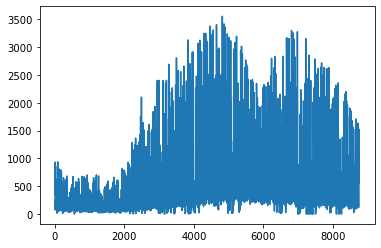

In [6]:
plt.plot(data['Rented Bike Count'])

In [7]:
cols=data.columns[1:-3]
cols=cols.drop(['Hour'])

In [8]:
cols

Index(['Rented Bike Count', 'Temperature', 'Humidity(%)', 'Wind speed (m/s)',
       'Visibility (10m)', 'Dew point temperature', 'Solar Radiation (MJ/m2)',
       'Rainfall(mm)', 'Snowfall (cm)'],
      dtype='object')

In [9]:
date_time = pd.to_datetime(data.pop('Date'), format='%d/%m/%Y')


In [10]:
SMALL_SIZE = 20
MEDIUM_SIZE = 23
BIGGER_SIZE = 25

plt.rc('font', size=SMALL_SIZE) # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE) # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE) # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE) # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE) # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE) # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE) # fontsize of the figure title

Index(['Rented Bike Count', 'Temperature', 'Humidity(%)', 'Wind speed (m/s)',
       'Visibility (10m)', 'Dew point temperature', 'Solar Radiation (MJ/m2)',
       'Rainfall(mm)', 'Snowfall (cm)'],
      dtype='object')
      Rented Bike Count  Hour  Temperature  Humidity(%)  Wind speed (m/s)  \
0                   254     0         -5.2           37               2.2   
1                   204     1         -5.5           38               0.8   
2                   173     2         -6.0           39               1.0   
3                   107     3         -6.2           40               0.9   
4                    78     4         -6.0           36               2.3   
...                 ...   ...          ...          ...               ...   
8755               1003    19          4.2           34               2.6   
8756                764    20          3.4           37               2.3   
8757                694    21          2.6           39               0.3   
8758      

<Figure size 1440x1080 with 0 Axes>

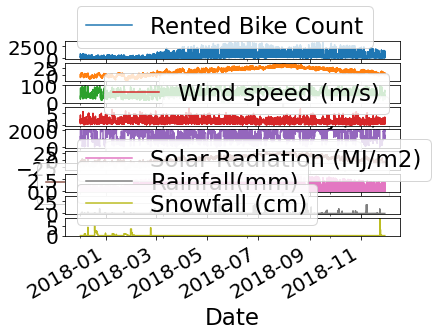

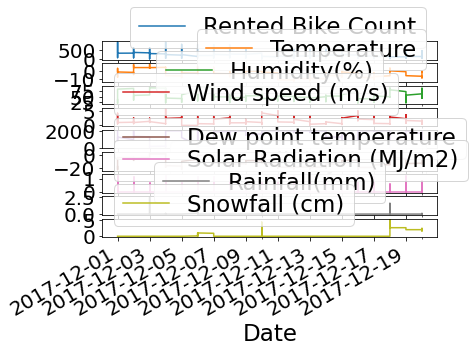

In [11]:
plt.figure(figsize=(20,15))

plot_cols = cols
df=data
print(cols)
print(data)

plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True)

In [12]:
from sklearn.preprocessing import MinMaxScaler
values = data[cols].values.reshape(-1,9)
values = values.astype('float32')
#scaler = MinMaxScaler(feature_range=(0, 1))
scaled = (values-(np.min(values)))/(np.max(values)-(np.min(values)))
#scaled = (values - np.mean(values))/np.std(values)
#scaled=scaler.fit_transform(values)

In [13]:
def fill_missing(values):
    one_day = 7 * 24
    for row in range(values.shape[0]):
        for col in range(values.shape[1]):
            if values[row,0]==0:
                values[row,0] = values[row - one_day,0]

In [14]:
fill_missing(values)


In [15]:
#scaled = (values-(np.min(values)))/(np.max(values)-(np.min(values)))

In [16]:
train_size = int(len(scaled) * 0.80)
val_size = int(len(scaled) * 0.10)

test_size = len(scaled) - train_size-val_size
train,val, test = scaled[0:train_size,:],scaled[train_size:train_size+val_size,:], scaled[train_size+val_size:,:]
print(len(train),len(val), len(test))

7008 876 876


In [17]:
def create_dataset_mul(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    print(len(dataY))
    return np.array(dataX), np.array(dataY)

In [18]:
look_back = 24
trainX, trainY = create_dataset_mul(train, look_back)
valX, valY = create_dataset_mul(val, look_back)
testX, testY = create_dataset_mul(test, look_back)


6984
852
852


In [19]:
trainY

array([0.09998327, 0.09440695, 0.08158144, ..., 0.00853176, 0.00853176,
       0.00853176], dtype=float32)

trainX = np.reshape(trainX, (trainX.shape[0],1, trainX.shape[1], trainX.shape[2]))
valX = np.reshape(valX, (valX.shape[0],1, valX.shape[1],valX.shape[2]))
testX = np.reshape(testX, (testX.shape[0],1,testX.shape[1], testX.shape[2] ))

look_back = 24
trainX, trainY = create_dataset_im(train, look_back)
valX, valY = create_dataset_im(val, look_back)
testX, testY = create_dataset_im(test, look_back)

In [20]:
print(trainX.shape)
print(trainY.shape)

(6984, 24, 9)
(6984,)


## LSTM-resCNN

In [97]:
first_input = Input(shape=(24,9))


in0=LSTM(64,return_sequences=True)(first_input)
#in1=add([first_input,in0])
in0=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in0)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

in1=add([in0,in1])
#ad=MaxPooling1D(pool_size=2)(ad)

#ad=Dropout(0.5)(ad)
#in0=LSTM(64,return_sequences=True)(ad)
#in1=add([first_input,in0])
in0=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in0)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same',name='extractor')(in1)
#in1= BatchNormalization(scale=False)(in1)

in1=add([in0,in1])

#ad1=MaxPooling1D(pool_size=2)(ad1)
#in0=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(ad1)
#in1= BatchNormalization(scale=False)(in0)

#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

#in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

#in1=add([ad1,in1],name='extractor2')
#in0=Conv1D(filters=64, kernel_size=5, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in0)

#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

#in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

#in1=add([in0,in1])

#attn_layer = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([in1,in1])

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([in1, attn_out])
#in1=MaxPooling1D(pool_size=2, name='extractor')(in1)
in1=Flatten()(in1)
in1=Dropout(0.5)(in1)
#in1=Dense(100, activation='relu')(in1)
out=Dense(1,'relu')(in1)
model=tf.keras.Model(inputs=[first_input],outputs=[out])
model.compile(optimizer='adam', loss='mse')

model.summary()

checkpoint_path = "C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/bike_onestep_lstm-rescnn(1).hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)

history=model.fit(trainX, trainY, epochs=200, batch_size=100, validation_data=(valX, valY), verbose=1,callbacks=[cb])

Model: "functional_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 24, 9)]      0                                            
__________________________________________________________________________________________________
lstm_6 (LSTM)                   (None, 24, 64)       18944       input_7[0][0]                    
__________________________________________________________________________________________________
conv1d_30 (Conv1D)              (None, 24, 64)       12352       lstm_6[0][0]                     
__________________________________________________________________________________________________
conv1d_31 (Conv1D)              (None, 24, 64)       8256        conv1d_30[0][0]                  
______________________________________________________________________________________

Epoch 17/200
67/70 [===========================>..] - ETA: 0s - loss: 0.0020
Epoch 00017: val_loss did not improve from 0.00257
70/70 [==============================] - 1s 18ms/step - loss: 0.0020 - val_loss: 0.0026
Epoch 18/200
67/70 [===========================>..] - ETA: 0s - loss: 0.0020
Epoch 00018: val_loss improved from 0.00257 to 0.00253, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights\bike_onestep_lstm-rescnn(1).hdf5
70/70 [==============================] - 1s 19ms/step - loss: 0.0020 - val_loss: 0.0025
Epoch 19/200
70/70 [==============================] - ETA: 0s - loss: 0.0019
Epoch 00019: val_loss improved from 0.00253 to 0.00243, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights\bike_onestep_lstm-rescnn(1).hdf5
70/70 [==============================] - 1s 19ms/step - loss: 0.0019 - val_loss: 0.0024
Epoch 20/200
67/70 [===========================>..] - ETA: 0s - loss: 0.0020
Epoch 00020: val_loss improve

Epoch 51/200
70/70 [==============================] - ETA: 0s - loss: 0.0016
Epoch 00051: val_loss did not improve from 0.00223
70/70 [==============================] - 1s 18ms/step - loss: 0.0016 - val_loss: 0.0027
Epoch 52/200
67/70 [===========================>..] - ETA: 0s - loss: 0.0015
Epoch 00052: val_loss did not improve from 0.00223
70/70 [==============================] - 1s 18ms/step - loss: 0.0015 - val_loss: 0.0022
Epoch 53/200
67/70 [===========================>..] - ETA: 0s - loss: 0.0016
Epoch 00053: val_loss improved from 0.00223 to 0.00207, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights\bike_onestep_lstm-rescnn(1).hdf5
70/70 [==============================] - 1s 19ms/step - loss: 0.0016 - val_loss: 0.0021
Epoch 54/200
70/70 [==============================] - ETA: 0s - loss: 0.0016
Epoch 00054: val_loss did not improve from 0.00207
70/70 [==============================] - 1s 18ms/step - loss: 0.0016 - val_loss: 0.0023
Epoch 55/200


70/70 [==============================] - ETA: 0s - loss: 0.0012
Epoch 00124: val_loss did not improve from 0.00201
70/70 [==============================] - 1s 18ms/step - loss: 0.0012 - val_loss: 0.0022
Epoch 125/200
67/70 [===========================>..] - ETA: 0s - loss: 0.0011
Epoch 00125: val_loss did not improve from 0.00201
70/70 [==============================] - 1s 18ms/step - loss: 0.0011 - val_loss: 0.0024
Epoch 126/200
70/70 [==============================] - ETA: 0s - loss: 0.0011
Epoch 00126: val_loss did not improve from 0.00201
70/70 [==============================] - 1s 18ms/step - loss: 0.0011 - val_loss: 0.0021
Epoch 127/200
69/70 [============================>.] - ETA: 0s - loss: 0.0011
Epoch 00127: val_loss improved from 0.00201 to 0.00194, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights\bike_onestep_lstm-rescnn(1).hdf5
70/70 [==============================] - 1s 19ms/step - loss: 0.0011 - val_loss: 0.0019
Epoch 128/200
70/70 [==

Epoch 161/200
70/70 [==============================] - ETA: 0s - loss: 9.7764e-04
Epoch 00161: val_loss did not improve from 0.00194
70/70 [==============================] - 1s 19ms/step - loss: 9.7764e-04 - val_loss: 0.0023
Epoch 162/200
67/70 [===========================>..] - ETA: 0s - loss: 9.4482e-04
Epoch 00162: val_loss did not improve from 0.00194
70/70 [==============================] - 1s 18ms/step - loss: 9.6430e-04 - val_loss: 0.0029
Epoch 163/200
70/70 [==============================] - ETA: 0s - loss: 9.9331e-04
Epoch 00163: val_loss did not improve from 0.00194
70/70 [==============================] - 1s 19ms/step - loss: 9.9331e-04 - val_loss: 0.0023
Epoch 164/200
70/70 [==============================] - ETA: 0s - loss: 9.6312e-04
Epoch 00164: val_loss did not improve from 0.00194
70/70 [==============================] - 1s 18ms/step - loss: 9.6312e-04 - val_loss: 0.0022
Epoch 165/200
70/70 [==============================] - ETA: 0s - loss: 9.2309e-04
Epoch 00165: val_l

Epoch 198/200
67/70 [===========================>..] - ETA: 0s - loss: 8.3080e-04
Epoch 00198: val_loss did not improve from 0.00194
70/70 [==============================] - 1s 18ms/step - loss: 8.3322e-04 - val_loss: 0.0021
Epoch 199/200
70/70 [==============================] - ETA: 0s - loss: 8.0504e-04
Epoch 00199: val_loss did not improve from 0.00194
70/70 [==============================] - 1s 18ms/step - loss: 8.0504e-04 - val_loss: 0.0024
Epoch 200/200
70/70 [==============================] - ETA: 0s - loss: 8.7845e-04
Epoch 00200: val_loss did not improve from 0.00194
70/70 [==============================] - 1s 19ms/step - loss: 8.7845e-04 - val_loss: 0.0025


In [98]:
first_input = Input(shape=(24,9))


in0=LSTM(64,return_sequences=True)(first_input)
#in1=add([first_input,in0])
in0=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in0)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

in1=add([in0,in1])
#ad=MaxPooling1D(pool_size=2)(ad)

#ad=Dropout(0.5)(ad)
#in0=LSTM(64,return_sequences=True)(ad)
#in1=add([first_input,in0])
in0=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in0)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same',name='extractor')(in1)
#in1= BatchNormalization(scale=False)(in1)

in1=add([in0,in1])

#ad1=MaxPooling1D(pool_size=2)(ad1)
#in0=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(ad1)
#in1= BatchNormalization(scale=False)(in0)

#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

#in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

#in1=add([ad1,in1],name='extractor2')
#in0=Conv1D(filters=64, kernel_size=5, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in0)

#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

#in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

#in1=add([in0,in1])

#attn_layer = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([in1,in1])

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([in1, attn_out])
#in1=MaxPooling1D(pool_size=2, name='extractor')(in1)
in1=Flatten()(in1)
in1=Dropout(0.5)(in1)
#in1=Dense(100, activation='relu')(in1)
out=Dense(1,'relu')(in1)
model=tf.keras.Model(inputs=[first_input],outputs=[out])
model.compile(optimizer='adam', loss='mse')

model.summary()

checkpoint_path = "C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/bike_onestep_lstm-rescnn(2).hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)

history=model.fit(trainX, trainY, epochs=200, batch_size=100, validation_data=(valX, valY), verbose=1,callbacks=[cb])

Model: "functional_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 24, 9)]      0                                            
__________________________________________________________________________________________________
lstm_7 (LSTM)                   (None, 24, 64)       18944       input_8[0][0]                    
__________________________________________________________________________________________________
conv1d_35 (Conv1D)              (None, 24, 64)       12352       lstm_7[0][0]                     
__________________________________________________________________________________________________
conv1d_36 (Conv1D)              (None, 24, 64)       8256        conv1d_35[0][0]                  
______________________________________________________________________________________

70/70 [==============================] - ETA: 0s - loss: 0.0021
Epoch 00017: val_loss did not improve from 0.00254
70/70 [==============================] - 1s 19ms/step - loss: 0.0021 - val_loss: 0.0027
Epoch 18/200
67/70 [===========================>..] - ETA: 0s - loss: 0.0021
Epoch 00018: val_loss did not improve from 0.00254
70/70 [==============================] - 1s 18ms/step - loss: 0.0020 - val_loss: 0.0027
Epoch 19/200
70/70 [==============================] - ETA: 0s - loss: 0.0021
Epoch 00019: val_loss did not improve from 0.00254
70/70 [==============================] - 1s 19ms/step - loss: 0.0021 - val_loss: 0.0028
Epoch 20/200
67/70 [===========================>..] - ETA: 0s - loss: 0.0020
Epoch 00020: val_loss did not improve from 0.00254
70/70 [==============================] - 1s 18ms/step - loss: 0.0020 - val_loss: 0.0028
Epoch 21/200
70/70 [==============================] - ETA: 0s - loss: 0.0018
Epoch 00021: val_loss improved from 0.00254 to 0.00247, saving model to 

Epoch 51/200
70/70 [==============================] - ETA: 0s - loss: 0.0015
Epoch 00051: val_loss did not improve from 0.00223
70/70 [==============================] - 1s 19ms/step - loss: 0.0015 - val_loss: 0.0026
Epoch 52/200
70/70 [==============================] - ETA: 0s - loss: 0.0014
Epoch 00052: val_loss did not improve from 0.00223
70/70 [==============================] - 1s 19ms/step - loss: 0.0014 - val_loss: 0.0023
Epoch 53/200
70/70 [==============================] - ETA: 0s - loss: 0.0014
Epoch 00053: val_loss improved from 0.00223 to 0.00221, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights\bike_onestep_lstm-rescnn(2).hdf5
70/70 [==============================] - 1s 19ms/step - loss: 0.0014 - val_loss: 0.0022
Epoch 54/200
70/70 [==============================] - ETA: 0s - loss: 0.0015
Epoch 00054: val_loss did not improve from 0.00221
70/70 [==============================] - 1s 19ms/step - loss: 0.0015 - val_loss: 0.0024
Epoch 55/200


Epoch 86/200
70/70 [==============================] - ETA: 0s - loss: 0.0013
Epoch 00086: val_loss did not improve from 0.00204
70/70 [==============================] - 1s 19ms/step - loss: 0.0013 - val_loss: 0.0022
Epoch 87/200
67/70 [===========================>..] - ETA: 0s - loss: 0.0012
Epoch 00087: val_loss did not improve from 0.00204
70/70 [==============================] - 1s 18ms/step - loss: 0.0012 - val_loss: 0.0022
Epoch 88/200
70/70 [==============================] - ETA: 0s - loss: 0.0013
Epoch 00088: val_loss did not improve from 0.00204
70/70 [==============================] - 1s 18ms/step - loss: 0.0013 - val_loss: 0.0022
Epoch 89/200
67/70 [===========================>..] - ETA: 0s - loss: 0.0013
Epoch 00089: val_loss did not improve from 0.00204
70/70 [==============================] - 1s 19ms/step - loss: 0.0013 - val_loss: 0.0022
Epoch 90/200
67/70 [===========================>..] - ETA: 0s - loss: 0.0012
Epoch 00090: val_loss did not improve from 0.00204
70/70 [=

70/70 [==============================] - ETA: 0s - loss: 8.8549e-04
Epoch 00160: val_loss did not improve from 0.00197
70/70 [==============================] - 1s 19ms/step - loss: 8.8549e-04 - val_loss: 0.0022
Epoch 161/200
70/70 [==============================] - ETA: 0s - loss: 9.1093e-04
Epoch 00161: val_loss did not improve from 0.00197
70/70 [==============================] - 1s 19ms/step - loss: 9.1093e-04 - val_loss: 0.0024
Epoch 162/200
70/70 [==============================] - ETA: 0s - loss: 9.2809e-04
Epoch 00162: val_loss did not improve from 0.00197
70/70 [==============================] - 1s 19ms/step - loss: 9.2809e-04 - val_loss: 0.0022
Epoch 163/200
70/70 [==============================] - ETA: 0s - loss: 8.3733e-04
Epoch 00163: val_loss did not improve from 0.00197
70/70 [==============================] - 1s 19ms/step - loss: 8.3733e-04 - val_loss: 0.0022
Epoch 164/200
70/70 [==============================] - ETA: 0s - loss: 8.7052e-04
Epoch 00164: val_loss did not im

Epoch 197/200
70/70 [==============================] - ETA: 0s - loss: 7.7714e-04
Epoch 00197: val_loss did not improve from 0.00197
70/70 [==============================] - 1s 19ms/step - loss: 7.7714e-04 - val_loss: 0.0024
Epoch 198/200
70/70 [==============================] - ETA: 0s - loss: 7.7130e-04
Epoch 00198: val_loss did not improve from 0.00197
70/70 [==============================] - 1s 19ms/step - loss: 7.7130e-04 - val_loss: 0.0022
Epoch 199/200
70/70 [==============================] - ETA: 0s - loss: 8.0238e-04
Epoch 00199: val_loss did not improve from 0.00197
70/70 [==============================] - 1s 19ms/step - loss: 8.0238e-04 - val_loss: 0.0024
Epoch 200/200
70/70 [==============================] - ETA: 0s - loss: 7.6787e-04
Epoch 00200: val_loss did not improve from 0.00197
70/70 [==============================] - 1s 19ms/step - loss: 7.6787e-04 - val_loss: 0.0023


In [99]:
first_input = Input(shape=(24,9))


in0=LSTM(64,return_sequences=True)(first_input)
#in1=add([first_input,in0])
in0=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in0)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

in1=add([in0,in1])
#ad=MaxPooling1D(pool_size=2)(ad)

#ad=Dropout(0.5)(ad)
#in0=LSTM(64,return_sequences=True)(ad)
#in1=add([first_input,in0])
in0=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in0)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same',name='extractor')(in1)
#in1= BatchNormalization(scale=False)(in1)

in1=add([in0,in1])

#ad1=MaxPooling1D(pool_size=2)(ad1)
#in0=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(ad1)
#in1= BatchNormalization(scale=False)(in0)

#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

#in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

#in1=add([ad1,in1],name='extractor2')
#in0=Conv1D(filters=64, kernel_size=5, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in0)

#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

#in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

#in1=add([in0,in1])

#attn_layer = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([in1,in1])

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([in1, attn_out])
#in1=MaxPooling1D(pool_size=2, name='extractor')(in1)
in1=Flatten()(in1)
in1=Dropout(0.5)(in1)
#in1=Dense(100, activation='relu')(in1)
out=Dense(1,'relu')(in1)
model=tf.keras.Model(inputs=[first_input],outputs=[out])
model.compile(optimizer='adam', loss='mse')

model.summary()

checkpoint_path = "C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/bike_onestep_lstm-rescnn(3).hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)

history=model.fit(trainX, trainY, epochs=200, batch_size=100, validation_data=(valX, valY), verbose=1,callbacks=[cb])

Model: "functional_17"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 24, 9)]      0                                            
__________________________________________________________________________________________________
lstm_8 (LSTM)                   (None, 24, 64)       18944       input_9[0][0]                    
__________________________________________________________________________________________________
conv1d_40 (Conv1D)              (None, 24, 64)       12352       lstm_8[0][0]                     
__________________________________________________________________________________________________
conv1d_41 (Conv1D)              (None, 24, 64)       8256        conv1d_40[0][0]                  
______________________________________________________________________________________

Epoch 53/200
70/70 [==============================] - ETA: 0s - loss: 0.0015
Epoch 00053: val_loss improved from 0.00221 to 0.00217, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights\bike_onestep_lstm-rescnn(3).hdf5
70/70 [==============================] - 1s 19ms/step - loss: 0.0015 - val_loss: 0.0022
Epoch 54/200
70/70 [==============================] - ETA: 0s - loss: 0.0015
Epoch 00054: val_loss improved from 0.00217 to 0.00201, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights\bike_onestep_lstm-rescnn(3).hdf5
70/70 [==============================] - 1s 20ms/step - loss: 0.0015 - val_loss: 0.0020
Epoch 55/200
70/70 [==============================] - ETA: 0s - loss: 0.0014
Epoch 00055: val_loss did not improve from 0.00201
70/70 [==============================] - 1s 19ms/step - loss: 0.0014 - val_loss: 0.0022
Epoch 56/200
70/70 [==============================] - ETA: 0s - loss: 0.0014
Epoch 00056: val_loss did not

Epoch 90/200
70/70 [==============================] - ETA: 0s - loss: 0.0011
Epoch 00090: val_loss did not improve from 0.00201
70/70 [==============================] - 1s 19ms/step - loss: 0.0011 - val_loss: 0.0022
Epoch 91/200
70/70 [==============================] - ETA: 0s - loss: 0.0012
Epoch 00091: val_loss did not improve from 0.00201
70/70 [==============================] - 1s 19ms/step - loss: 0.0012 - val_loss: 0.0024
Epoch 92/200
70/70 [==============================] - ETA: 0s - loss: 0.0012
Epoch 00092: val_loss did not improve from 0.00201
70/70 [==============================] - 1s 19ms/step - loss: 0.0012 - val_loss: 0.0024
Epoch 93/200
70/70 [==============================] - ETA: 0s - loss: 0.0012
Epoch 00093: val_loss did not improve from 0.00201
70/70 [==============================] - 1s 19ms/step - loss: 0.0012 - val_loss: 0.0023
Epoch 94/200
70/70 [==============================] - ETA: 0s - loss: 0.0012
Epoch 00094: val_loss did not improve from 0.00201
70/70 [=

Epoch 128/200
70/70 [==============================] - ETA: 0s - loss: 0.0011
Epoch 00128: val_loss did not improve from 0.00201
70/70 [==============================] - 1s 20ms/step - loss: 0.0011 - val_loss: 0.0025
Epoch 129/200
70/70 [==============================] - ETA: 0s - loss: 9.6180e-04
Epoch 00129: val_loss did not improve from 0.00201
70/70 [==============================] - 1s 19ms/step - loss: 9.6180e-04 - val_loss: 0.0026
Epoch 130/200
70/70 [==============================] - ETA: 0s - loss: 0.0011
Epoch 00130: val_loss did not improve from 0.00201
70/70 [==============================] - 1s 19ms/step - loss: 0.0011 - val_loss: 0.0024
Epoch 131/200
70/70 [==============================] - ETA: 0s - loss: 0.0011
Epoch 00131: val_loss did not improve from 0.00201
70/70 [==============================] - 1s 19ms/step - loss: 0.0011 - val_loss: 0.0024
Epoch 132/200
70/70 [==============================] - ETA: 0s - loss: 0.0011
Epoch 00132: val_loss did not improve from 0.0

Epoch 165/200
70/70 [==============================] - ETA: 0s - loss: 8.9100e-04
Epoch 00165: val_loss did not improve from 0.00201
70/70 [==============================] - 1s 19ms/step - loss: 8.9100e-04 - val_loss: 0.0023
Epoch 166/200
70/70 [==============================] - ETA: 0s - loss: 8.3888e-04
Epoch 00166: val_loss did not improve from 0.00201
70/70 [==============================] - 1s 19ms/step - loss: 8.3888e-04 - val_loss: 0.0024
Epoch 167/200
70/70 [==============================] - ETA: 0s - loss: 8.5787e-04
Epoch 00167: val_loss did not improve from 0.00201
70/70 [==============================] - 1s 19ms/step - loss: 8.5787e-04 - val_loss: 0.0025
Epoch 168/200
69/70 [============================>.] - ETA: 0s - loss: 9.6835e-04
Epoch 00168: val_loss did not improve from 0.00201
70/70 [==============================] - 1s 19ms/step - loss: 9.6601e-04 - val_loss: 0.0024
Epoch 169/200
70/70 [==============================] - ETA: 0s - loss: 8.5205e-04
Epoch 00169: val_l

In [100]:
first_input = Input(shape=(24,9))


in0=LSTM(64,return_sequences=True)(first_input)
#in1=add([first_input,in0])
in0=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in0)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

in1=add([in0,in1])
#ad=MaxPooling1D(pool_size=2)(ad)

#ad=Dropout(0.5)(ad)
#in0=LSTM(64,return_sequences=True)(ad)
#in1=add([first_input,in0])
in0=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in0)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same',name='extractor')(in1)
#in1= BatchNormalization(scale=False)(in1)

in1=add([in0,in1])

#ad1=MaxPooling1D(pool_size=2)(ad1)
#in0=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(ad1)
#in1= BatchNormalization(scale=False)(in0)

#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

#in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

#in1=add([ad1,in1],name='extractor2')
#in0=Conv1D(filters=64, kernel_size=5, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in0)

#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

#in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

#in1=add([in0,in1])

#attn_layer = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([in1,in1])

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([in1, attn_out])
#in1=MaxPooling1D(pool_size=2, name='extractor')(in1)
in1=Flatten()(in1)
in1=Dropout(0.5)(in1)
#in1=Dense(100, activation='relu')(in1)
out=Dense(1,'relu')(in1)
model=tf.keras.Model(inputs=[first_input],outputs=[out])
model.compile(optimizer='adam', loss='mse')

model.summary()

checkpoint_path = "C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/bike_onestep_lstm-rescnn(4).hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)

history=model.fit(trainX, trainY, epochs=200, batch_size=100, validation_data=(valX, valY), verbose=1,callbacks=[cb])

Model: "functional_19"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 24, 9)]      0                                            
__________________________________________________________________________________________________
lstm_9 (LSTM)                   (None, 24, 64)       18944       input_10[0][0]                   
__________________________________________________________________________________________________
conv1d_45 (Conv1D)              (None, 24, 64)       12352       lstm_9[0][0]                     
__________________________________________________________________________________________________
conv1d_46 (Conv1D)              (None, 24, 64)       8256        conv1d_45[0][0]                  
______________________________________________________________________________________

Epoch 18/200
69/70 [============================>.] - ETA: 0s - loss: 0.0020
Epoch 00018: val_loss did not improve from 0.00255
70/70 [==============================] - 1s 18ms/step - loss: 0.0020 - val_loss: 0.0029
Epoch 19/200
70/70 [==============================] - ETA: 0s - loss: 0.0019- ETA: 0s - loss: 0.001
Epoch 00019: val_loss did not improve from 0.00255
70/70 [==============================] - 1s 18ms/step - loss: 0.0019 - val_loss: 0.0027
Epoch 20/200
68/70 [============================>.] - ETA: 0s - loss: 0.0019
Epoch 00020: val_loss did not improve from 0.00255
70/70 [==============================] - 1s 18ms/step - loss: 0.0019 - val_loss: 0.0026
Epoch 21/200
68/70 [============================>.] - ETA: 0s - loss: 0.0019
Epoch 00021: val_loss did not improve from 0.00255
70/70 [==============================] - 1s 18ms/step - loss: 0.0019 - val_loss: 0.0026
Epoch 22/200
68/70 [============================>.] - ETA: 0s - loss: 0.0019
Epoch 00022: val_loss did not improv

Epoch 55/200
67/70 [===========================>..] - ETA: 0s - loss: 0.0015
Epoch 00055: val_loss did not improve from 0.00230
70/70 [==============================] - 1s 18ms/step - loss: 0.0015 - val_loss: 0.0025
Epoch 56/200
69/70 [============================>.] - ETA: 0s - loss: 0.0014
Epoch 00056: val_loss did not improve from 0.00230
70/70 [==============================] - 1s 18ms/step - loss: 0.0014 - val_loss: 0.0023
Epoch 57/200
68/70 [============================>.] - ETA: 0s - loss: 0.0015
Epoch 00057: val_loss did not improve from 0.00230
70/70 [==============================] - 1s 18ms/step - loss: 0.0015 - val_loss: 0.0024
Epoch 58/200
67/70 [===========================>..] - ETA: 0s - loss: 0.0015
Epoch 00058: val_loss did not improve from 0.00230
70/70 [==============================] - 1s 18ms/step - loss: 0.0015 - val_loss: 0.0025
Epoch 59/200
69/70 [============================>.] - ETA: 0s - loss: 0.0013
Epoch 00059: val_loss did not improve from 0.00230
70/70 [=

Epoch 91/200
68/70 [============================>.] - ETA: 0s - loss: 0.0011
Epoch 00091: val_loss did not improve from 0.00205
70/70 [==============================] - 1s 18ms/step - loss: 0.0011 - val_loss: 0.0022
Epoch 92/200
68/70 [============================>.] - ETA: 0s - loss: 0.0011
Epoch 00092: val_loss did not improve from 0.00205
70/70 [==============================] - 1s 18ms/step - loss: 0.0011 - val_loss: 0.0023
Epoch 93/200
69/70 [============================>.] - ETA: 0s - loss: 0.0011
Epoch 00093: val_loss did not improve from 0.00205
70/70 [==============================] - 1s 18ms/step - loss: 0.0011 - val_loss: 0.0030
Epoch 94/200
68/70 [============================>.] - ETA: 0s - loss: 0.0011
Epoch 00094: val_loss did not improve from 0.00205
70/70 [==============================] - 1s 18ms/step - loss: 0.0011 - val_loss: 0.0024
Epoch 95/200
68/70 [============================>.] - ETA: 0s - loss: 0.0011
Epoch 00095: val_loss did not improve from 0.00205
70/70 [=

Epoch 129/200
70/70 [==============================] - ETA: 0s - loss: 9.7748e-04
Epoch 00129: val_loss did not improve from 0.00205
70/70 [==============================] - 1s 18ms/step - loss: 9.7748e-04 - val_loss: 0.0023
Epoch 130/200
70/70 [==============================] - ETA: 0s - loss: 9.4967e-04
Epoch 00130: val_loss did not improve from 0.00205
70/70 [==============================] - 1s 18ms/step - loss: 9.4967e-04 - val_loss: 0.0024
Epoch 131/200
70/70 [==============================] - ETA: 0s - loss: 9.7873e-04
Epoch 00131: val_loss did not improve from 0.00205
70/70 [==============================] - 1s 18ms/step - loss: 9.7873e-04 - val_loss: 0.0026
Epoch 132/200
70/70 [==============================] - ETA: 0s - loss: 9.9043e-04
Epoch 00132: val_loss did not improve from 0.00205
70/70 [==============================] - 1s 18ms/step - loss: 9.9043e-04 - val_loss: 0.0026
Epoch 133/200
67/70 [===========================>..] - ETA: 0s - loss: 9.8827e-04
Epoch 00133: val_l

Epoch 166/200
68/70 [============================>.] - ETA: 0s - loss: 8.0759e-04
Epoch 00166: val_loss did not improve from 0.00202
70/70 [==============================] - 1s 18ms/step - loss: 8.1069e-04 - val_loss: 0.0025
Epoch 167/200
70/70 [==============================] - ETA: 0s - loss: 8.8718e-04
Epoch 00167: val_loss did not improve from 0.00202
70/70 [==============================] - 1s 18ms/step - loss: 8.8718e-04 - val_loss: 0.0024
Epoch 168/200
68/70 [============================>.] - ETA: 0s - loss: 8.3025e-04
Epoch 00168: val_loss improved from 0.00202 to 0.00199, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights\bike_onestep_lstm-rescnn(4).hdf5
70/70 [==============================] - 1s 18ms/step - loss: 8.2457e-04 - val_loss: 0.0020
Epoch 169/200
67/70 [===========================>..] - ETA: 0s - loss: 8.0163e-04
Epoch 00169: val_loss did not improve from 0.00199
70/70 [==============================] - 1s 18ms/step - loss: 8.0291e

In [101]:
first_input = Input(shape=(24,9))


in0=LSTM(64,return_sequences=True)(first_input)
#in1=add([first_input,in0])
in0=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in0)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

in1=add([in0,in1])
#ad=MaxPooling1D(pool_size=2)(ad)

#ad=Dropout(0.5)(ad)
#in0=LSTM(64,return_sequences=True)(ad)
#in1=add([first_input,in0])
in0=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in0)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same',name='extractor')(in1)
#in1= BatchNormalization(scale=False)(in1)

in1=add([in0,in1])

#ad1=MaxPooling1D(pool_size=2)(ad1)
#in0=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(ad1)
#in1= BatchNormalization(scale=False)(in0)

#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

#in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

#in1=add([ad1,in1],name='extractor2')
#in0=Conv1D(filters=64, kernel_size=5, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in0)

#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

#in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

#in1=add([in0,in1])

#attn_layer = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([in1,in1])

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([in1, attn_out])
#in1=MaxPooling1D(pool_size=2, name='extractor')(in1)
in1=Flatten()(in1)
in1=Dropout(0.5)(in1)
#in1=Dense(100, activation='relu')(in1)
out=Dense(1,'relu')(in1)
model=tf.keras.Model(inputs=[first_input],outputs=[out])
model.compile(optimizer='adam', loss='mse')

model.summary()

checkpoint_path = "C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/bike_onestep_lstm-rescnn(5).hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)

history=model.fit(trainX, trainY, epochs=200, batch_size=100, validation_data=(valX, valY), verbose=1,callbacks=[cb])

Model: "functional_21"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 24, 9)]      0                                            
__________________________________________________________________________________________________
lstm_10 (LSTM)                  (None, 24, 64)       18944       input_11[0][0]                   
__________________________________________________________________________________________________
conv1d_50 (Conv1D)              (None, 24, 64)       12352       lstm_10[0][0]                    
__________________________________________________________________________________________________
conv1d_51 (Conv1D)              (None, 24, 64)       8256        conv1d_50[0][0]                  
______________________________________________________________________________________

Epoch 54/200
69/70 [============================>.] - ETA: 0s - loss: 0.0015
Epoch 00054: val_loss did not improve from 0.00199
70/70 [==============================] - 1s 21ms/step - loss: 0.0015 - val_loss: 0.0025
Epoch 55/200
70/70 [==============================] - ETA: 0s - loss: 0.0014
Epoch 00055: val_loss did not improve from 0.00199
70/70 [==============================] - 1s 20ms/step - loss: 0.0014 - val_loss: 0.0023
Epoch 56/200
70/70 [==============================] - ETA: 0s - loss: 0.0015
Epoch 00056: val_loss did not improve from 0.00199
70/70 [==============================] - 1s 20ms/step - loss: 0.0015 - val_loss: 0.0021
Epoch 57/200
70/70 [==============================] - ETA: 0s - loss: 0.0015
Epoch 00057: val_loss did not improve from 0.00199
70/70 [==============================] - 1s 19ms/step - loss: 0.0015 - val_loss: 0.0023
Epoch 58/200
70/70 [==============================] - ETA: 0s - loss: 0.0015
Epoch 00058: val_loss did not improve from 0.00199
70/70 [=

Epoch 92/200
70/70 [==============================] - ETA: 0s - loss: 0.0012
Epoch 00092: val_loss did not improve from 0.00199
70/70 [==============================] - 1s 19ms/step - loss: 0.0012 - val_loss: 0.0021
Epoch 93/200
70/70 [==============================] - ETA: 0s - loss: 0.0013
Epoch 00093: val_loss did not improve from 0.00199
70/70 [==============================] - 1s 19ms/step - loss: 0.0013 - val_loss: 0.0023
Epoch 94/200
70/70 [==============================] - ETA: 0s - loss: 0.0012
Epoch 00094: val_loss did not improve from 0.00199
70/70 [==============================] - 1s 19ms/step - loss: 0.0012 - val_loss: 0.0024
Epoch 95/200
70/70 [==============================] - ETA: 0s - loss: 0.0012
Epoch 00095: val_loss did not improve from 0.00199
70/70 [==============================] - 1s 19ms/step - loss: 0.0012 - val_loss: 0.0022
Epoch 96/200
70/70 [==============================] - ETA: 0s - loss: 0.0012
Epoch 00096: val_loss did not improve from 0.00199
70/70 [=

Epoch 130/200
70/70 [==============================] - ETA: 0s - loss: 0.0010   
Epoch 00130: val_loss did not improve from 0.00199
70/70 [==============================] - 1s 19ms/step - loss: 0.0010 - val_loss: 0.0021
Epoch 131/200
70/70 [==============================] - ETA: 0s - loss: 0.0010
Epoch 00131: val_loss did not improve from 0.00199
70/70 [==============================] - 1s 19ms/step - loss: 0.0010 - val_loss: 0.0022
Epoch 132/200
70/70 [==============================] - ETA: 0s - loss: 0.0011
Epoch 00132: val_loss did not improve from 0.00199
70/70 [==============================] - 1s 19ms/step - loss: 0.0011 - val_loss: 0.0025
Epoch 133/200
70/70 [==============================] - ETA: 0s - loss: 0.0010  
Epoch 00133: val_loss did not improve from 0.00199
70/70 [==============================] - 1s 19ms/step - loss: 0.0010 - val_loss: 0.0023
Epoch 134/200
70/70 [==============================] - ETA: 0s - loss: 0.0011
Epoch 00134: val_loss did not improve from 0.0019

Epoch 167/200
70/70 [==============================] - ETA: 0s - loss: 8.8119e-04
Epoch 00167: val_loss did not improve from 0.00199
70/70 [==============================] - 1s 20ms/step - loss: 8.8119e-04 - val_loss: 0.0024
Epoch 168/200
70/70 [==============================] - ETA: 0s - loss: 8.7216e-04
Epoch 00168: val_loss did not improve from 0.00199
70/70 [==============================] - 1s 19ms/step - loss: 8.7216e-04 - val_loss: 0.0021
Epoch 169/200
70/70 [==============================] - ETA: 0s - loss: 8.5111e-04
Epoch 00169: val_loss did not improve from 0.00199
70/70 [==============================] - 1s 19ms/step - loss: 8.5111e-04 - val_loss: 0.0020
Epoch 170/200
70/70 [==============================] - ETA: 0s - loss: 8.5213e-04
Epoch 00170: val_loss did not improve from 0.00199
70/70 [==============================] - 1s 19ms/step - loss: 8.5213e-04 - val_loss: 0.0022
Epoch 171/200
70/70 [==============================] - ETA: 0s - loss: 8.8542e-04
Epoch 00171: val_l

In [102]:
first_input = Input(shape=(24,9))


in0=LSTM(64,return_sequences=True)(first_input)
#in1=add([first_input,in0])
in0=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in0)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

in1=add([in0,in1])
#ad=MaxPooling1D(pool_size=2)(ad)

#ad=Dropout(0.5)(ad)
#in0=LSTM(64,return_sequences=True)(ad)
#in1=add([first_input,in0])
in0=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in0)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same',name='extractor')(in1)
#in1= BatchNormalization(scale=False)(in1)

in1=add([in0,in1])

#ad1=MaxPooling1D(pool_size=2)(ad1)
#in0=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(ad1)
#in1= BatchNormalization(scale=False)(in0)

#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

#in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

#in1=add([ad1,in1],name='extractor2')
#in0=Conv1D(filters=64, kernel_size=5, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in0)

#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

#in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

#in1=add([in0,in1])

#attn_layer = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([in1,in1])

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([in1, attn_out])
#in1=MaxPooling1D(pool_size=2, name='extractor')(in1)
in1=Flatten()(in1)
in1=Dropout(0.5)(in1)
#in1=Dense(100, activation='relu')(in1)
out=Dense(1,'relu')(in1)
model=tf.keras.Model(inputs=[first_input],outputs=[out])
model.compile(optimizer='adam', loss='mse')

model.summary()

checkpoint_path = "C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/bike_onestep_lstm-rescnn(6).hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)

history=model.fit(trainX, trainY, epochs=200, batch_size=100, validation_data=(valX, valY), verbose=1,callbacks=[cb])

Model: "functional_23"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 24, 9)]      0                                            
__________________________________________________________________________________________________
lstm_11 (LSTM)                  (None, 24, 64)       18944       input_12[0][0]                   
__________________________________________________________________________________________________
conv1d_55 (Conv1D)              (None, 24, 64)       12352       lstm_11[0][0]                    
__________________________________________________________________________________________________
conv1d_56 (Conv1D)              (None, 24, 64)       8256        conv1d_55[0][0]                  
______________________________________________________________________________________

Epoch 54/200
70/70 [==============================] - ETA: 0s - loss: 0.0016
Epoch 00054: val_loss did not improve from 0.00214
70/70 [==============================] - 1s 19ms/step - loss: 0.0016 - val_loss: 0.0022
Epoch 55/200
70/70 [==============================] - ETA: 0s - loss: 0.0015
Epoch 00055: val_loss improved from 0.00214 to 0.00211, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights\bike_onestep_lstm-rescnn(6).hdf5
70/70 [==============================] - 1s 20ms/step - loss: 0.0015 - val_loss: 0.0021
Epoch 56/200
70/70 [==============================] - ETA: 0s - loss: 0.0015
Epoch 00056: val_loss did not improve from 0.00211
70/70 [==============================] - 1s 19ms/step - loss: 0.0015 - val_loss: 0.0027
Epoch 57/200
70/70 [==============================] - ETA: 0s - loss: 0.0015
Epoch 00057: val_loss did not improve from 0.00211
70/70 [==============================] - 1s 19ms/step - loss: 0.0015 - val_loss: 0.0023
Epoch 58/200


Epoch 89/200
70/70 [==============================] - ETA: 0s - loss: 0.0012
Epoch 00089: val_loss did not improve from 0.00189
70/70 [==============================] - 1s 19ms/step - loss: 0.0012 - val_loss: 0.0025
Epoch 90/200
70/70 [==============================] - ETA: 0s - loss: 0.0012
Epoch 00090: val_loss did not improve from 0.00189
70/70 [==============================] - 1s 20ms/step - loss: 0.0012 - val_loss: 0.0021
Epoch 91/200
70/70 [==============================] - ETA: 0s - loss: 0.0011
Epoch 00091: val_loss did not improve from 0.00189
70/70 [==============================] - 1s 20ms/step - loss: 0.0011 - val_loss: 0.0021
Epoch 92/200
70/70 [==============================] - ETA: 0s - loss: 0.0013
Epoch 00092: val_loss did not improve from 0.00189
70/70 [==============================] - 1s 19ms/step - loss: 0.0013 - val_loss: 0.0021
Epoch 93/200
70/70 [==============================] - ETA: 0s - loss: 0.0012
Epoch 00093: val_loss did not improve from 0.00189
70/70 [=

Epoch 127/200
70/70 [==============================] - ETA: 0s - loss: 0.0011
Epoch 00127: val_loss did not improve from 0.00189
70/70 [==============================] - 1s 19ms/step - loss: 0.0011 - val_loss: 0.0020
Epoch 128/200
70/70 [==============================] - ETA: 0s - loss: 0.0010 
Epoch 00128: val_loss did not improve from 0.00189
70/70 [==============================] - 1s 20ms/step - loss: 0.0010 - val_loss: 0.0022
Epoch 129/200
70/70 [==============================] - ETA: 0s - loss: 0.0010
Epoch 00129: val_loss did not improve from 0.00189
70/70 [==============================] - 1s 19ms/step - loss: 0.0010 - val_loss: 0.0023
Epoch 130/200
70/70 [==============================] - ETA: 0s - loss: 0.0010
Epoch 00130: val_loss did not improve from 0.00189
70/70 [==============================] - 1s 20ms/step - loss: 0.0010 - val_loss: 0.0025
Epoch 131/200
70/70 [==============================] - ETA: 0s - loss: 0.0011
Epoch 00131: val_loss did not improve from 0.00189
70

Epoch 164/200
70/70 [==============================] - ETA: 0s - loss: 8.4039e-04
Epoch 00164: val_loss did not improve from 0.00189
70/70 [==============================] - 1s 20ms/step - loss: 8.4039e-04 - val_loss: 0.0021
Epoch 165/200
70/70 [==============================] - ETA: 0s - loss: 9.1232e-04
Epoch 00165: val_loss did not improve from 0.00189
70/70 [==============================] - 1s 20ms/step - loss: 9.1232e-04 - val_loss: 0.0022
Epoch 166/200
70/70 [==============================] - ETA: 0s - loss: 9.1029e-04
Epoch 00166: val_loss did not improve from 0.00189
70/70 [==============================] - 1s 19ms/step - loss: 9.1029e-04 - val_loss: 0.0025
Epoch 167/200
70/70 [==============================] - ETA: 0s - loss: 9.5102e-04
Epoch 00167: val_loss did not improve from 0.00189
70/70 [==============================] - 1s 19ms/step - loss: 9.5102e-04 - val_loss: 0.0023
Epoch 168/200
70/70 [==============================] - ETA: 0s - loss: 8.6808e-04
Epoch 00168: val_l

In [103]:
first_input = Input(shape=(24,9))


in0=LSTM(64,return_sequences=True)(first_input)
#in1=add([first_input,in0])
in0=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in0)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

in1=add([in0,in1])
#ad=MaxPooling1D(pool_size=2)(ad)

#ad=Dropout(0.5)(ad)
#in0=LSTM(64,return_sequences=True)(ad)
#in1=add([first_input,in0])
in0=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in0)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same',name='extractor')(in1)
#in1= BatchNormalization(scale=False)(in1)

in1=add([in0,in1])

#ad1=MaxPooling1D(pool_size=2)(ad1)
#in0=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(ad1)
#in1= BatchNormalization(scale=False)(in0)

#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

#in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

#in1=add([ad1,in1],name='extractor2')
#in0=Conv1D(filters=64, kernel_size=5, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in0)

#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

#in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

#in1=add([in0,in1])

#attn_layer = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([in1,in1])

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([in1, attn_out])
#in1=MaxPooling1D(pool_size=2, name='extractor')(in1)
in1=Flatten()(in1)
in1=Dropout(0.5)(in1)
#in1=Dense(100, activation='relu')(in1)
out=Dense(1,'relu')(in1)
model=tf.keras.Model(inputs=[first_input],outputs=[out])
model.compile(optimizer='adam', loss='mse')

model.summary()

checkpoint_path = "C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/bike_onestep_lstm-rescnn(7).hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)

history=model.fit(trainX, trainY, epochs=200, batch_size=100, validation_data=(valX, valY), verbose=1,callbacks=[cb])

Model: "functional_25"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 24, 9)]      0                                            
__________________________________________________________________________________________________
lstm_12 (LSTM)                  (None, 24, 64)       18944       input_13[0][0]                   
__________________________________________________________________________________________________
conv1d_60 (Conv1D)              (None, 24, 64)       12352       lstm_12[0][0]                    
__________________________________________________________________________________________________
conv1d_61 (Conv1D)              (None, 24, 64)       8256        conv1d_60[0][0]                  
______________________________________________________________________________________

Epoch 19/200
70/70 [==============================] - ETA: 0s - loss: 0.0020
Epoch 00019: val_loss did not improve from 0.00247
70/70 [==============================] - 1s 20ms/step - loss: 0.0020 - val_loss: 0.0026
Epoch 20/200
70/70 [==============================] - ETA: 0s - loss: 0.0019
Epoch 00020: val_loss did not improve from 0.00247
70/70 [==============================] - 1s 20ms/step - loss: 0.0019 - val_loss: 0.0026
Epoch 21/200
70/70 [==============================] - ETA: 0s - loss: 0.0021
Epoch 00021: val_loss did not improve from 0.00247
70/70 [==============================] - 1s 20ms/step - loss: 0.0021 - val_loss: 0.0026
Epoch 22/200
70/70 [==============================] - ETA: 0s - loss: 0.0019
Epoch 00022: val_loss improved from 0.00247 to 0.00246, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights\bike_onestep_lstm-rescnn(7).hdf5
70/70 [==============================] - 1s 19ms/step - loss: 0.0019 - val_loss: 0.0025
Epoch 23/200


70/70 [==============================] - ETA: 0s - loss: 0.0013
Epoch 00089: val_loss did not improve from 0.00208
70/70 [==============================] - 1s 19ms/step - loss: 0.0013 - val_loss: 0.0025
Epoch 90/200
70/70 [==============================] - ETA: 0s - loss: 0.0014
Epoch 00090: val_loss did not improve from 0.00208
70/70 [==============================] - 1s 19ms/step - loss: 0.0014 - val_loss: 0.0026
Epoch 91/200
70/70 [==============================] - ETA: 0s - loss: 0.0014
Epoch 00091: val_loss did not improve from 0.00208
70/70 [==============================] - 1s 19ms/step - loss: 0.0014 - val_loss: 0.0023
Epoch 92/200
70/70 [==============================] - ETA: 0s - loss: 0.0012
Epoch 00092: val_loss did not improve from 0.00208
70/70 [==============================] - 1s 20ms/step - loss: 0.0012 - val_loss: 0.0021
Epoch 93/200
70/70 [==============================] - ETA: 0s - loss: 0.0013
Epoch 00093: val_loss did not improve from 0.00208
70/70 [==============

Epoch 127/200
70/70 [==============================] - ETA: 0s - loss: 0.0013
Epoch 00127: val_loss did not improve from 0.00208
70/70 [==============================] - 1s 19ms/step - loss: 0.0013 - val_loss: 0.0022
Epoch 128/200
70/70 [==============================] - ETA: 0s - loss: 0.0012
Epoch 00128: val_loss did not improve from 0.00208
70/70 [==============================] - 1s 19ms/step - loss: 0.0012 - val_loss: 0.0022
Epoch 129/200
69/70 [============================>.] - ETA: 0s - loss: 0.0011
Epoch 00129: val_loss did not improve from 0.00208
70/70 [==============================] - 1s 20ms/step - loss: 0.0011 - val_loss: 0.0022
Epoch 130/200
70/70 [==============================] - ETA: 0s - loss: 0.0011
Epoch 00130: val_loss did not improve from 0.00208
70/70 [==============================] - 1s 20ms/step - loss: 0.0011 - val_loss: 0.0023
Epoch 131/200
70/70 [==============================] - ETA: 0s - loss: 0.0011
Epoch 00131: val_loss did not improve from 0.00208
70/

Epoch 164/200
70/70 [==============================] - ETA: 0s - loss: 9.8129e-04
Epoch 00164: val_loss did not improve from 0.00205
70/70 [==============================] - 1s 20ms/step - loss: 9.8129e-04 - val_loss: 0.0025
Epoch 165/200
70/70 [==============================] - ETA: 0s - loss: 9.1887e-04
Epoch 00165: val_loss did not improve from 0.00205
70/70 [==============================] - 1s 20ms/step - loss: 9.1887e-04 - val_loss: 0.0025
Epoch 166/200
70/70 [==============================] - ETA: 0s - loss: 9.3991e-04
Epoch 00166: val_loss did not improve from 0.00205
70/70 [==============================] - 1s 19ms/step - loss: 9.3991e-04 - val_loss: 0.0022
Epoch 167/200
70/70 [==============================] - ETA: 0s - loss: 0.0010
Epoch 00167: val_loss did not improve from 0.00205
70/70 [==============================] - 1s 19ms/step - loss: 0.0010 - val_loss: 0.0022
Epoch 168/200
70/70 [==============================] - ETA: 0s - loss: 8.8770e-04
Epoch 00168: val_loss did 

In [104]:
first_input = Input(shape=(24,9))


in0=LSTM(64,return_sequences=True)(first_input)
#in1=add([first_input,in0])
in0=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in0)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

in1=add([in0,in1])
#ad=MaxPooling1D(pool_size=2)(ad)

#ad=Dropout(0.5)(ad)
#in0=LSTM(64,return_sequences=True)(ad)
#in1=add([first_input,in0])
in0=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in0)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same',name='extractor')(in1)
#in1= BatchNormalization(scale=False)(in1)

in1=add([in0,in1])

#ad1=MaxPooling1D(pool_size=2)(ad1)
#in0=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(ad1)
#in1= BatchNormalization(scale=False)(in0)

#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

#in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

#in1=add([ad1,in1],name='extractor2')
#in0=Conv1D(filters=64, kernel_size=5, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in0)

#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

#in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

#in1=add([in0,in1])

#attn_layer = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([in1,in1])

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([in1, attn_out])
#in1=MaxPooling1D(pool_size=2, name='extractor')(in1)
in1=Flatten()(in1)
in1=Dropout(0.5)(in1)
#in1=Dense(100, activation='relu')(in1)
out=Dense(1,'relu')(in1)
model=tf.keras.Model(inputs=[first_input],outputs=[out])
model.compile(optimizer='adam', loss='mse')

model.summary()

checkpoint_path = "C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/bike_onestep_lstm-rescnn(8).hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)

history=model.fit(trainX, trainY, epochs=200, batch_size=100, validation_data=(valX, valY), verbose=1,callbacks=[cb])

Model: "functional_27"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           [(None, 24, 9)]      0                                            
__________________________________________________________________________________________________
lstm_13 (LSTM)                  (None, 24, 64)       18944       input_14[0][0]                   
__________________________________________________________________________________________________
conv1d_65 (Conv1D)              (None, 24, 64)       12352       lstm_13[0][0]                    
__________________________________________________________________________________________________
conv1d_66 (Conv1D)              (None, 24, 64)       8256        conv1d_65[0][0]                  
______________________________________________________________________________________

70/70 [==============================] - 1s 19ms/step - loss: 0.0020 - val_loss: 0.0025
Epoch 19/200
70/70 [==============================] - ETA: 0s - loss: 0.0019
Epoch 00019: val_loss did not improve from 0.00246
70/70 [==============================] - 1s 18ms/step - loss: 0.0019 - val_loss: 0.0029
Epoch 20/200
70/70 [==============================] - ETA: 0s - loss: 0.0018
Epoch 00020: val_loss did not improve from 0.00246
70/70 [==============================] - 1s 19ms/step - loss: 0.0018 - val_loss: 0.0028
Epoch 21/200
70/70 [==============================] - ETA: 0s - loss: 0.0018
Epoch 00021: val_loss did not improve from 0.00246
70/70 [==============================] - 1s 19ms/step - loss: 0.0018 - val_loss: 0.0025
Epoch 22/200
70/70 [==============================] - ETA: 0s - loss: 0.0019
Epoch 00022: val_loss did not improve from 0.00246
70/70 [==============================] - 1s 19ms/step - loss: 0.0019 - val_loss: 0.0026
Epoch 23/200
70/70 [============================

67/70 [===========================>..] - ETA: 0s - loss: 0.0013
Epoch 00087: val_loss did not improve from 0.00201
70/70 [==============================] - 1s 19ms/step - loss: 0.0013 - val_loss: 0.0022
Epoch 88/200
70/70 [==============================] - ETA: 0s - loss: 0.0011
Epoch 00088: val_loss did not improve from 0.00201
70/70 [==============================] - 1s 18ms/step - loss: 0.0011 - val_loss: 0.0022
Epoch 89/200
70/70 [==============================] - ETA: 0s - loss: 0.0012
Epoch 00089: val_loss did not improve from 0.00201
70/70 [==============================] - 1s 19ms/step - loss: 0.0012 - val_loss: 0.0022
Epoch 90/200
70/70 [==============================] - ETA: 0s - loss: 0.0012
Epoch 00090: val_loss did not improve from 0.00201
70/70 [==============================] - 1s 19ms/step - loss: 0.0012 - val_loss: 0.0023
Epoch 91/200
70/70 [==============================] - ETA: 0s - loss: 0.0013
Epoch 00091: val_loss did not improve from 0.00201
70/70 [==============

Epoch 125/200
70/70 [==============================] - ETA: 0s - loss: 0.0010
Epoch 00125: val_loss did not improve from 0.00201
70/70 [==============================] - 1s 19ms/step - loss: 0.0010 - val_loss: 0.0023
Epoch 126/200
70/70 [==============================] - ETA: 0s - loss: 9.4239e-04
Epoch 00126: val_loss did not improve from 0.00201
70/70 [==============================] - 1s 19ms/step - loss: 9.4239e-04 - val_loss: 0.0023
Epoch 127/200
70/70 [==============================] - ETA: 0s - loss: 9.9022e-04
Epoch 00127: val_loss did not improve from 0.00201
70/70 [==============================] - 1s 19ms/step - loss: 9.9022e-04 - val_loss: 0.0022
Epoch 128/200
70/70 [==============================] - ETA: 0s - loss: 0.0011
Epoch 00128: val_loss did not improve from 0.00201
70/70 [==============================] - 1s 19ms/step - loss: 0.0011 - val_loss: 0.0023
Epoch 129/200
70/70 [==============================] - ETA: 0s - loss: 0.0010
Epoch 00129: val_loss did not improve 

Epoch 162/200
70/70 [==============================] - ETA: 0s - loss: 9.3766e-04
Epoch 00162: val_loss did not improve from 0.00201
70/70 [==============================] - 1s 19ms/step - loss: 9.3766e-04 - val_loss: 0.0026
Epoch 163/200
70/70 [==============================] - ETA: 0s - loss: 8.9295e-04
Epoch 00163: val_loss did not improve from 0.00201
70/70 [==============================] - 1s 19ms/step - loss: 8.9295e-04 - val_loss: 0.0024
Epoch 164/200
70/70 [==============================] - ETA: 0s - loss: 8.1396e-04
Epoch 00164: val_loss did not improve from 0.00201
70/70 [==============================] - 1s 19ms/step - loss: 8.1396e-04 - val_loss: 0.0023
Epoch 165/200
70/70 [==============================] - ETA: 0s - loss: 8.7213e-04
Epoch 00165: val_loss did not improve from 0.00201
70/70 [==============================] - 1s 19ms/step - loss: 8.7213e-04 - val_loss: 0.0026
Epoch 166/200
70/70 [==============================] - ETA: 0s - loss: 0.0010  
Epoch 00166: val_los

Epoch 199/200
70/70 [==============================] - ETA: 0s - loss: 7.4794e-04
Epoch 00199: val_loss did not improve from 0.00201
70/70 [==============================] - 1s 19ms/step - loss: 7.4794e-04 - val_loss: 0.0023
Epoch 200/200
70/70 [==============================] - ETA: 0s - loss: 7.4922e-04
Epoch 00200: val_loss did not improve from 0.00201
70/70 [==============================] - 1s 19ms/step - loss: 7.4922e-04 - val_loss: 0.0022


In [105]:
first_input = Input(shape=(24,9))


in0=LSTM(64,return_sequences=True)(first_input)
#in1=add([first_input,in0])
in0=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in0)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

in1=add([in0,in1])
#ad=MaxPooling1D(pool_size=2)(ad)

#ad=Dropout(0.5)(ad)
#in0=LSTM(64,return_sequences=True)(ad)
#in1=add([first_input,in0])
in0=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in0)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same',name='extractor')(in1)
#in1= BatchNormalization(scale=False)(in1)

in1=add([in0,in1])

#ad1=MaxPooling1D(pool_size=2)(ad1)
#in0=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(ad1)
#in1= BatchNormalization(scale=False)(in0)

#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

#in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

#in1=add([ad1,in1],name='extractor2')
#in0=Conv1D(filters=64, kernel_size=5, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in0)

#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

#in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

#in1=add([in0,in1])

#attn_layer = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([in1,in1])

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([in1, attn_out])
#in1=MaxPooling1D(pool_size=2, name='extractor')(in1)
in1=Flatten()(in1)
in1=Dropout(0.5)(in1)
#in1=Dense(100, activation='relu')(in1)
out=Dense(1,'relu')(in1)
model=tf.keras.Model(inputs=[first_input],outputs=[out])
model.compile(optimizer='adam', loss='mse')

model.summary()

checkpoint_path = "C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/bike_onestep_lstm-rescnn(9).hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)

history=model.fit(trainX, trainY, epochs=200, batch_size=100, validation_data=(valX, valY), verbose=1,callbacks=[cb])

Model: "functional_29"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           [(None, 24, 9)]      0                                            
__________________________________________________________________________________________________
lstm_14 (LSTM)                  (None, 24, 64)       18944       input_15[0][0]                   
__________________________________________________________________________________________________
conv1d_70 (Conv1D)              (None, 24, 64)       12352       lstm_14[0][0]                    
__________________________________________________________________________________________________
conv1d_71 (Conv1D)              (None, 24, 64)       8256        conv1d_70[0][0]                  
______________________________________________________________________________________

70/70 [==============================] - ETA: 0s - loss: 0.0016
Epoch 00054: val_loss did not improve from 0.00225
70/70 [==============================] - 1s 19ms/step - loss: 0.0016 - val_loss: 0.0027
Epoch 55/200
70/70 [==============================] - ETA: 0s - loss: 0.0015
Epoch 00055: val_loss improved from 0.00225 to 0.00221, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights\bike_onestep_lstm-rescnn(9).hdf5
70/70 [==============================] - 1s 19ms/step - loss: 0.0015 - val_loss: 0.0022
Epoch 56/200
70/70 [==============================] - ETA: 0s - loss: 0.0014
Epoch 00056: val_loss did not improve from 0.00221
70/70 [==============================] - 1s 19ms/step - loss: 0.0014 - val_loss: 0.0025
Epoch 57/200
70/70 [==============================] - ETA: 0s - loss: 0.0015
Epoch 00057: val_loss did not improve from 0.00221
70/70 [==============================] - 1s 19ms/step - loss: 0.0015 - val_loss: 0.0025
Epoch 58/200
70/70 [======

Epoch 89/200
70/70 [==============================] - ETA: 0s - loss: 0.0013
Epoch 00089: val_loss did not improve from 0.00205
70/70 [==============================] - 1s 19ms/step - loss: 0.0013 - val_loss: 0.0023
Epoch 90/200
70/70 [==============================] - ETA: 0s - loss: 0.0013
Epoch 00090: val_loss did not improve from 0.00205
70/70 [==============================] - 1s 19ms/step - loss: 0.0013 - val_loss: 0.0024
Epoch 91/200
69/70 [============================>.] - ETA: 0s - loss: 0.0012
Epoch 00091: val_loss did not improve from 0.00205
70/70 [==============================] - 1s 19ms/step - loss: 0.0012 - val_loss: 0.0022
Epoch 92/200
70/70 [==============================] - ETA: 0s - loss: 0.0012
Epoch 00092: val_loss did not improve from 0.00205
70/70 [==============================] - 1s 19ms/step - loss: 0.0012 - val_loss: 0.0022
Epoch 93/200
70/70 [==============================] - ETA: 0s - loss: 0.0012
Epoch 00093: val_loss did not improve from 0.00205
70/70 [=

70/70 [==============================] - ETA: 0s - loss: 0.0010
Epoch 00125: val_loss did not improve from 0.00198
70/70 [==============================] - 1s 19ms/step - loss: 0.0010 - val_loss: 0.0022
Epoch 126/200
70/70 [==============================] - ETA: 0s - loss: 9.7531e-04
Epoch 00126: val_loss did not improve from 0.00198
70/70 [==============================] - 1s 19ms/step - loss: 9.7531e-04 - val_loss: 0.0022
Epoch 127/200
70/70 [==============================] - ETA: 0s - loss: 0.0011
Epoch 00127: val_loss did not improve from 0.00198
70/70 [==============================] - 1s 19ms/step - loss: 0.0011 - val_loss: 0.0021
Epoch 128/200
70/70 [==============================] - ETA: 0s - loss: 0.0011
Epoch 00128: val_loss did not improve from 0.00198
70/70 [==============================] - 1s 19ms/step - loss: 0.0011 - val_loss: 0.0020
Epoch 129/200
70/70 [==============================] - ETA: 0s - loss: 0.0010
Epoch 00129: val_loss did not improve from 0.00198
70/70 [==

Epoch 162/200
70/70 [==============================] - ETA: 0s - loss: 9.4034e-04
Epoch 00162: val_loss did not improve from 0.00198
70/70 [==============================] - 1s 19ms/step - loss: 9.4034e-04 - val_loss: 0.0022
Epoch 163/200
70/70 [==============================] - ETA: 0s - loss: 8.5676e-04
Epoch 00163: val_loss did not improve from 0.00198
70/70 [==============================] - 1s 19ms/step - loss: 8.5676e-04 - val_loss: 0.0022
Epoch 164/200
70/70 [==============================] - ETA: 0s - loss: 8.5220e-04
Epoch 00164: val_loss did not improve from 0.00198
70/70 [==============================] - 1s 19ms/step - loss: 8.5220e-04 - val_loss: 0.0022
Epoch 165/200
70/70 [==============================] - ETA: 0s - loss: 8.5502e-04
Epoch 00165: val_loss did not improve from 0.00198
70/70 [==============================] - 1s 19ms/step - loss: 8.5502e-04 - val_loss: 0.0021
Epoch 166/200
70/70 [==============================] - ETA: 0s - loss: 9.9417e-04
Epoch 00166: val_l

Epoch 199/200
70/70 [==============================] - ETA: 0s - loss: 7.2444e-04
Epoch 00199: val_loss did not improve from 0.00198
70/70 [==============================] - 1s 19ms/step - loss: 7.2444e-04 - val_loss: 0.0023
Epoch 200/200
70/70 [==============================] - ETA: 0s - loss: 7.9966e-04
Epoch 00200: val_loss did not improve from 0.00198
70/70 [==============================] - 1s 19ms/step - loss: 7.9966e-04 - val_loss: 0.0024


In [106]:
first_input = Input(shape=(24,9))


in0=LSTM(64,return_sequences=True)(first_input)
#in1=add([first_input,in0])
in0=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in0)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

in1=add([in0,in1])
#ad=MaxPooling1D(pool_size=2)(ad)

#ad=Dropout(0.5)(ad)
#in0=LSTM(64,return_sequences=True)(ad)
#in1=add([first_input,in0])
in0=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in0)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same',name='extractor')(in1)
#in1= BatchNormalization(scale=False)(in1)

in1=add([in0,in1])

#ad1=MaxPooling1D(pool_size=2)(ad1)
#in0=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(ad1)
#in1= BatchNormalization(scale=False)(in0)

#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

#in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

#in1=add([ad1,in1],name='extractor2')
#in0=Conv1D(filters=64, kernel_size=5, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in0)

#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

#in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

#in1=add([in0,in1])

#attn_layer = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([in1,in1])

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([in1, attn_out])
#in1=MaxPooling1D(pool_size=2, name='extractor')(in1)
in1=Flatten()(in1)
in1=Dropout(0.5)(in1)
#in1=Dense(100, activation='relu')(in1)
out=Dense(1,'relu')(in1)
model=tf.keras.Model(inputs=[first_input],outputs=[out])
model.compile(optimizer='adam', loss='mse')

model.summary()

checkpoint_path = "C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/bike_onestep_lstm-rescnn(10).hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)

history=model.fit(trainX, trainY, epochs=200, batch_size=100, validation_data=(valX, valY), verbose=1,callbacks=[cb])

Model: "functional_31"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           [(None, 24, 9)]      0                                            
__________________________________________________________________________________________________
lstm_15 (LSTM)                  (None, 24, 64)       18944       input_16[0][0]                   
__________________________________________________________________________________________________
conv1d_75 (Conv1D)              (None, 24, 64)       12352       lstm_15[0][0]                    
__________________________________________________________________________________________________
conv1d_76 (Conv1D)              (None, 24, 64)       8256        conv1d_75[0][0]                  
______________________________________________________________________________________

Epoch 17/200
69/70 [============================>.] - ETA: 0s - loss: 0.0022
Epoch 00017: val_loss did not improve from 0.00256
70/70 [==============================] - 1s 19ms/step - loss: 0.0021 - val_loss: 0.0028
Epoch 18/200
70/70 [==============================] - ETA: 0s - loss: 0.0020
Epoch 00018: val_loss did not improve from 0.00256
70/70 [==============================] - 1s 18ms/step - loss: 0.0020 - val_loss: 0.0027
Epoch 19/200
70/70 [==============================] - ETA: 0s - loss: 0.0020
Epoch 00019: val_loss did not improve from 0.00256
70/70 [==============================] - 1s 18ms/step - loss: 0.0020 - val_loss: 0.0026
Epoch 20/200
67/70 [===========================>..] - ETA: 0s - loss: 0.0018
Epoch 00020: val_loss did not improve from 0.00256
70/70 [==============================] - 1s 18ms/step - loss: 0.0019 - val_loss: 0.0026
Epoch 21/200
70/70 [==============================] - ETA: 0s - loss: 0.0018
Epoch 00021: val_loss did not improve from 0.00256
70/70 [=

67/70 [===========================>..] - ETA: 0s - loss: 0.0013
Epoch 00090: val_loss improved from 0.00228 to 0.00221, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights\bike_onestep_lstm-rescnn(10).hdf5
70/70 [==============================] - 1s 18ms/step - loss: 0.0013 - val_loss: 0.0022
Epoch 91/200
70/70 [==============================] - ETA: 0s - loss: 0.0012
Epoch 00091: val_loss did not improve from 0.00221
70/70 [==============================] - 1s 19ms/step - loss: 0.0012 - val_loss: 0.0023
Epoch 92/200
70/70 [==============================] - ETA: 0s - loss: 0.0012
Epoch 00092: val_loss did not improve from 0.00221
70/70 [==============================] - 1s 19ms/step - loss: 0.0012 - val_loss: 0.0025
Epoch 93/200
70/70 [==============================] - ETA: 0s - loss: 0.0011
Epoch 00093: val_loss did not improve from 0.00221
70/70 [==============================] - 1s 18ms/step - loss: 0.0011 - val_loss: 0.0023
Epoch 94/200
70/70 [=====

Epoch 126/200
70/70 [==============================] - ETA: 0s - loss: 9.9263e-04
Epoch 00126: val_loss did not improve from 0.00210
70/70 [==============================] - 1s 19ms/step - loss: 9.9263e-04 - val_loss: 0.0022
Epoch 127/200
70/70 [==============================] - ETA: 0s - loss: 9.6611e-04
Epoch 00127: val_loss did not improve from 0.00210
70/70 [==============================] - 1s 18ms/step - loss: 9.6611e-04 - val_loss: 0.0023
Epoch 128/200
70/70 [==============================] - ETA: 0s - loss: 9.6069e-04
Epoch 00128: val_loss did not improve from 0.00210
70/70 [==============================] - 1s 19ms/step - loss: 9.6069e-04 - val_loss: 0.0025
Epoch 129/200
70/70 [==============================] - ETA: 0s - loss: 0.0011  
Epoch 00129: val_loss did not improve from 0.00210
70/70 [==============================] - 1s 18ms/step - loss: 0.0011 - val_loss: 0.0025
Epoch 130/200
67/70 [===========================>..] - ETA: 0s - loss: 0.0011
Epoch 00130: val_loss did no

Epoch 162/200
70/70 [==============================] - ETA: 0s - loss: 0.0010
Epoch 00162: val_loss did not improve from 0.00210
70/70 [==============================] - 1s 18ms/step - loss: 0.0010 - val_loss: 0.0024
Epoch 163/200
69/70 [============================>.] - ETA: 0s - loss: 8.5770e-04
Epoch 00163: val_loss did not improve from 0.00210
70/70 [==============================] - 1s 19ms/step - loss: 8.6098e-04 - val_loss: 0.0022
Epoch 164/200
70/70 [==============================] - ETA: 0s - loss: 8.8306e-04
Epoch 00164: val_loss did not improve from 0.00210
70/70 [==============================] - 1s 19ms/step - loss: 8.8306e-04 - val_loss: 0.0025
Epoch 165/200
67/70 [===========================>..] - ETA: 0s - loss: 7.5961e-04- ETA: 0s - loss: 7.6260e-
Epoch 00165: val_loss did not improve from 0.00210
70/70 [==============================] - 1s 19ms/step - loss: 7.7084e-04 - val_loss: 0.0023
Epoch 166/200
70/70 [==============================] - ETA: 0s - loss: 7.7499e-04


In [107]:
model.load_weights("C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/bike_onestep_lstm-rescnn(1).hdf5")

In [108]:
from sklearn.metrics import *
from math import *
yhat = model.predict(testX)
rmse = sqrt(mean_squared_error(testY, np.array(yhat)))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, np.array(yhat))
print('Test MAE: %.5f' % mae)

mse = mean_squared_error(testY, np.array(yhat))
print('Test MSE: %.5f' % mse)

mape=mean_absolute_percentage_error(testY, np.array(yhat))
print('Test MAPE: %.5f' % mape)



yhat_inverse = yhat*(np.max(values)-np.min(values))+np.min(values)
testY_inverse=testY*(np.max(values)-np.min(values))+np.min(values)
rmse = sqrt(mean_squared_error(np.array(yhat_inverse), testY_inverse))
mae=mean_absolute_error(np.array(yhat_inverse), testY_inverse)
mape=mean_absolute_percentage_error(testY_inverse,np.array(yhat_inverse))

print('Test RMSE: %.5f' % rmse)
print('Test MAE: %.5f' % mae)
print('Test MAPE: %.5f' % mape)


Test RMSE: 0.03381
Test MAE: 0.02253
Test MSE: 0.00114
Test MAPE: 0.34718
Test RMSE: 121.25813
Test MAE: 80.82398
Test MAPE: 2997765.75000


In [109]:
model.load_weights("C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/bike_onestep_lstm-rescnn(2).hdf5")

In [110]:
from sklearn.metrics import *
from math import *
yhat = model.predict(testX)
rmse = sqrt(mean_squared_error(testY, np.array(yhat)))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, np.array(yhat))
print('Test MAE: %.5f' % mae)

mse = mean_squared_error(testY, np.array(yhat))
print('Test MSE: %.5f' % mse)

mape=mean_absolute_percentage_error(testY, np.array(yhat))
print('Test MAPE: %.5f' % mape)



yhat_inverse = yhat*(np.max(values)-np.min(values))+np.min(values)
testY_inverse=testY*(np.max(values)-np.min(values))+np.min(values)
rmse = sqrt(mean_squared_error(np.array(yhat_inverse), testY_inverse))
mae=mean_absolute_error(np.array(yhat_inverse), testY_inverse)
mape=mean_absolute_percentage_error(testY_inverse,np.array(yhat_inverse))

print('Test RMSE: %.5f' % rmse)
print('Test MAE: %.5f' % mae)
print('Test MAPE: %.5f' % mape)

Test RMSE: 0.03578
Test MAE: 0.02519
Test MSE: 0.00128
Test MAPE: 0.33989
Test RMSE: 128.32794
Test MAE: 90.35879
Test MAPE: 2665264.50000


In [111]:
model.load_weights("C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/bike_onestep_lstm-rescnn(3).hdf5")

In [112]:
from sklearn.metrics import *
from math import *
yhat = model.predict(testX)
rmse = sqrt(mean_squared_error(testY, np.array(yhat)))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, np.array(yhat))
print('Test MAE: %.5f' % mae)

mse = mean_squared_error(testY, np.array(yhat))
print('Test MSE: %.5f' % mse)

mape=mean_absolute_percentage_error(testY, np.array(yhat))
print('Test MAPE: %.5f' % mape)



yhat_inverse = yhat*(np.max(values)-np.min(values))+np.min(values)
testY_inverse=testY*(np.max(values)-np.min(values))+np.min(values)
rmse = sqrt(mean_squared_error(np.array(yhat_inverse), testY_inverse))
mae=mean_absolute_error(np.array(yhat_inverse), testY_inverse)
mape=mean_absolute_percentage_error(testY_inverse,np.array(yhat_inverse))

print('Test RMSE: %.5f' % rmse)
print('Test MAE: %.5f' % mae)
print('Test MAPE: %.5f' % mape)

Test RMSE: 0.03440
Test MAE: 0.02345
Test MSE: 0.00118
Test MAPE: 0.30451
Test RMSE: 123.37234
Test MAE: 84.11392
Test MAPE: 2352009.50000


In [113]:
model.load_weights("C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/bike_onestep_lstm-rescnn(4).hdf5")

In [114]:
from sklearn.metrics import *
from math import *
yhat = model.predict(testX)
rmse = sqrt(mean_squared_error(testY, np.array(yhat)))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, np.array(yhat))
print('Test MAE: %.5f' % mae)

mse = mean_squared_error(testY, np.array(yhat))
print('Test MSE: %.5f' % mse)

mape=mean_absolute_percentage_error(testY, np.array(yhat))
print('Test MAPE: %.5f' % mape)



yhat_inverse = yhat*(np.max(values)-np.min(values))+np.min(values)
testY_inverse=testY*(np.max(values)-np.min(values))+np.min(values)
rmse = sqrt(mean_squared_error(np.array(yhat_inverse), testY_inverse))
mae=mean_absolute_error(np.array(yhat_inverse), testY_inverse)
mape=mean_absolute_percentage_error(testY_inverse,np.array(yhat_inverse))

print('Test RMSE: %.5f' % rmse)
print('Test MAE: %.5f' % mae)
print('Test MAPE: %.5f' % mape)

Test RMSE: 0.03409
Test MAE: 0.02284
Test MSE: 0.00116
Test MAPE: 0.32225
Test RMSE: 122.25866
Test MAE: 81.91116
Test MAPE: 2606281.25000


In [115]:
model.load_weights("C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/bike_onestep_lstm-rescnn(5).hdf5")

In [116]:
from sklearn.metrics import *
from math import *
yhat = model.predict(testX)
rmse = sqrt(mean_squared_error(testY, np.array(yhat)))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, np.array(yhat))
print('Test MAE: %.5f' % mae)

mse = mean_squared_error(testY, np.array(yhat))
print('Test MSE: %.5f' % mse)

mape=mean_absolute_percentage_error(testY, np.array(yhat))
print('Test MAPE: %.5f' % mape)



yhat_inverse = yhat*(np.max(values)-np.min(values))+np.min(values)
testY_inverse=testY*(np.max(values)-np.min(values))+np.min(values)
rmse = sqrt(mean_squared_error(np.array(yhat_inverse), testY_inverse))
mae=mean_absolute_error(np.array(yhat_inverse), testY_inverse)
mape=mean_absolute_percentage_error(testY_inverse,np.array(yhat_inverse))

print('Test RMSE: %.5f' % rmse)
print('Test MAE: %.5f' % mae)
print('Test MAPE: %.5f' % mape)

Test RMSE: 0.03572
Test MAE: 0.02269
Test MSE: 0.00128
Test MAPE: 0.28997
Test RMSE: 128.12520
Test MAE: 81.39662
Test MAPE: 1967952.12500


In [117]:
model.load_weights("C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/bike_onestep_lstm-rescnn(6).hdf5")

In [118]:
from sklearn.metrics import *
from math import *
yhat = model.predict(testX)
rmse = sqrt(mean_squared_error(testY, np.array(yhat)))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, np.array(yhat))
print('Test MAE: %.5f' % mae)

mse = mean_squared_error(testY, np.array(yhat))
print('Test MSE: %.5f' % mse)

mape=mean_absolute_percentage_error(testY, np.array(yhat))
print('Test MAPE: %.5f' % mape)



yhat_inverse = yhat*(np.max(values)-np.min(values))+np.min(values)
testY_inverse=testY*(np.max(values)-np.min(values))+np.min(values)
rmse = sqrt(mean_squared_error(np.array(yhat_inverse), testY_inverse))
mae=mean_absolute_error(np.array(yhat_inverse), testY_inverse)
mape=mean_absolute_percentage_error(testY_inverse,np.array(yhat_inverse))

print('Test RMSE: %.5f' % rmse)
print('Test MAE: %.5f' % mae)
print('Test MAPE: %.5f' % mape)

Test RMSE: 0.03319
Test MAE: 0.02208
Test MSE: 0.00110
Test MAPE: 0.28527
Test RMSE: 119.02732
Test MAE: 79.20099
Test MAPE: 2109006.00000


In [119]:
model.load_weights("C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/bike_onestep_lstm-rescnn(7).hdf5")

In [120]:
from sklearn.metrics import *
from math import *
yhat = model.predict(testX)
rmse = sqrt(mean_squared_error(testY, np.array(yhat)))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, np.array(yhat))
print('Test MAE: %.5f' % mae)

mse = mean_squared_error(testY, np.array(yhat))
print('Test MSE: %.5f' % mse)

mape=mean_absolute_percentage_error(testY, np.array(yhat))
print('Test MAPE: %.5f' % mape)



yhat_inverse = yhat*(np.max(values)-np.min(values))+np.min(values)
testY_inverse=testY*(np.max(values)-np.min(values))+np.min(values)
rmse = sqrt(mean_squared_error(np.array(yhat_inverse), testY_inverse))
mae=mean_absolute_error(np.array(yhat_inverse), testY_inverse)
mape=mean_absolute_percentage_error(testY_inverse,np.array(yhat_inverse))

print('Test RMSE: %.5f' % rmse)
print('Test MAE: %.5f' % mae)
print('Test MAPE: %.5f' % mape)

Test RMSE: 0.03392
Test MAE: 0.02207
Test MSE: 0.00115
Test MAPE: 0.33616
Test RMSE: 121.67394
Test MAE: 79.16079
Test MAPE: 2889159.50000


In [121]:
model.load_weights("C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/bike_onestep_lstm-rescnn(8).hdf5")

In [122]:
from sklearn.metrics import *
from math import *
yhat = model.predict(testX)
rmse = sqrt(mean_squared_error(testY, np.array(yhat)))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, np.array(yhat))
print('Test MAE: %.5f' % mae)

mse = mean_squared_error(testY, np.array(yhat))
print('Test MSE: %.5f' % mse)

mape=mean_absolute_percentage_error(testY, np.array(yhat))
print('Test MAPE: %.5f' % mape)



yhat_inverse = yhat*(np.max(values)-np.min(values))+np.min(values)
testY_inverse=testY*(np.max(values)-np.min(values))+np.min(values)
rmse = sqrt(mean_squared_error(np.array(yhat_inverse), testY_inverse))
mae=mean_absolute_error(np.array(yhat_inverse), testY_inverse)
mape=mean_absolute_percentage_error(testY_inverse,np.array(yhat_inverse))

print('Test RMSE: %.5f' % rmse)
print('Test MAE: %.5f' % mae)
print('Test MAPE: %.5f' % mape)

Test RMSE: 0.03209
Test MAE: 0.02133
Test MSE: 0.00103
Test MAPE: 0.27716
Test RMSE: 115.09649
Test MAE: 76.49500
Test MAPE: 2001295.37500


In [123]:
model.load_weights("C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/bike_onestep_lstm-rescnn(9).hdf5")

In [124]:
from sklearn.metrics import *
from math import *
yhat = model.predict(testX)
rmse = sqrt(mean_squared_error(testY, np.array(yhat)))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, np.array(yhat))
print('Test MAE: %.5f' % mae)

mse = mean_squared_error(testY, np.array(yhat))
print('Test MSE: %.5f' % mse)

mape=mean_absolute_percentage_error(testY, np.array(yhat))
print('Test MAPE: %.5f' % mape)



yhat_inverse = yhat*(np.max(values)-np.min(values))+np.min(values)
testY_inverse=testY*(np.max(values)-np.min(values))+np.min(values)
rmse = sqrt(mean_squared_error(np.array(yhat_inverse), testY_inverse))
mae=mean_absolute_error(np.array(yhat_inverse), testY_inverse)
mape=mean_absolute_percentage_error(testY_inverse,np.array(yhat_inverse))

print('Test RMSE: %.5f' % rmse)
print('Test MAE: %.5f' % mae)
print('Test MAPE: %.5f' % mape)

Test RMSE: 0.03166
Test MAE: 0.02088
Test MSE: 0.00100
Test MAPE: 0.28162
Test RMSE: 113.53983
Test MAE: 74.89152
Test MAPE: 2055852.62500


In [125]:
model.load_weights("C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/bike_onestep_lstm-rescnn(10).hdf5")

In [126]:
from sklearn.metrics import *
from math import *
yhat = model.predict(testX)
rmse = sqrt(mean_squared_error(testY, np.array(yhat)))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, np.array(yhat))
print('Test MAE: %.5f' % mae)

mse = mean_squared_error(testY, np.array(yhat))
print('Test MSE: %.5f' % mse)

mape=mean_absolute_percentage_error(testY, np.array(yhat))
print('Test MAPE: %.5f' % mape)



yhat_inverse = yhat*(np.max(values)-np.min(values))+np.min(values)
testY_inverse=testY*(np.max(values)-np.min(values))+np.min(values)
rmse = sqrt(mean_squared_error(np.array(yhat_inverse), testY_inverse))
mae=mean_absolute_error(np.array(yhat_inverse), testY_inverse)
mape=mean_absolute_percentage_error(testY_inverse,np.array(yhat_inverse))

print('Test RMSE: %.5f' % rmse)
print('Test MAE: %.5f' % mae)
print('Test MAPE: %.5f' % mape)

Test RMSE: 0.03404
Test MAE: 0.02278
Test MSE: 0.00116
Test MAPE: 0.34133
Test RMSE: 122.08972
Test MAE: 81.70359
Test MAPE: 2727770.75000


### CNN-LSTM

In [128]:
first_input = Input(shape=(24,9))

in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(first_input)
#in1= BatchNormalization(scale=False)(in1)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in1)
#in0= BatchNormalization(scale=False)(in0)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1=MaxPooling1D(pool_size=2)(in1)
#in1= BatchNormalization(scale=False)(in1)
in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in1)
#in0= BatchNormalization(scale=False)(in0)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same',name='extractor')(in1)
#in1= BatchNormalization(scale=False)(in1)
in1=MaxPooling1D(pool_size=2)(in1)
#in1=add([in0,in1],name='extractor')
#attn_layer = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([in1,in1])

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([in1, attn_out])
#in1=MaxPooling1D(pool_size=2, name='extractor')(in1)
#in1=Flatten()(in1)
#in1=Dense(100, activation='relu')(in1)
in1=LSTM(64)(in1)

out=Dense(1)(in1)
model=tf.keras.Model(inputs=[first_input],outputs=[out])
model.compile(optimizer='Adam', loss='mse')

checkpoint_path = "C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/bike_onestep_cnn-lstm(1).hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)


#history=model.fit(trainX, trainY, epochs=200, batch_size=100, validation_data=(valX, valY), verbose=1, callbacks=[cb])

Epoch 1/200
69/70 [============================>.] - ETA: 0s - loss: 0.0182
Epoch 00001: val_loss improved from inf to 0.00774, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights\bike_onestep_cnn-lstm(1).hdf5
70/70 [==============================] - 1s 21ms/step - loss: 0.0180 - val_loss: 0.0077
Epoch 2/200
68/70 [============================>.] - ETA: 0s - loss: 0.0052
Epoch 00002: val_loss improved from 0.00774 to 0.00576, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights\bike_onestep_cnn-lstm(1).hdf5
70/70 [==============================] - 1s 16ms/step - loss: 0.0051 - val_loss: 0.0058
Epoch 3/200
69/70 [============================>.] - ETA: 0s - loss: 0.0041
Epoch 00003: val_loss improved from 0.00576 to 0.00505, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights\bike_onestep_cnn-lstm(1).hdf5
70/70 [==============================] - 1s 16ms/step - loss: 0.0041 - val_loss: 0.0050

Epoch 67/200
69/70 [============================>.] - ETA: 0s - loss: 8.3980e-04
Epoch 00067: val_loss did not improve from 0.00181
70/70 [==============================] - 1s 14ms/step - loss: 8.4854e-04 - val_loss: 0.0020
Epoch 68/200
69/70 [============================>.] - ETA: 0s - loss: 9.3314e-04
Epoch 00068: val_loss did not improve from 0.00181
70/70 [==============================] - 1s 14ms/step - loss: 9.2935e-04 - val_loss: 0.0021
Epoch 69/200
69/70 [============================>.] - ETA: 0s - loss: 8.8701e-04
Epoch 00069: val_loss did not improve from 0.00181
70/70 [==============================] - 1s 14ms/step - loss: 8.8660e-04 - val_loss: 0.0020
Epoch 70/200
69/70 [============================>.] - ETA: 0s - loss: 8.6767e-04
Epoch 00070: val_loss did not improve from 0.00181
70/70 [==============================] - 1s 14ms/step - loss: 8.6385e-04 - val_loss: 0.0025
Epoch 71/200
69/70 [============================>.] - ETA: 0s - loss: 8.1907e-04
Epoch 00071: val_loss d

69/70 [============================>.] - ETA: 0s - loss: 6.3069e-04
Epoch 00103: val_loss did not improve from 0.00179
70/70 [==============================] - 1s 15ms/step - loss: 6.2848e-04 - val_loss: 0.0019
Epoch 104/200
69/70 [============================>.] - ETA: 0s - loss: 6.1647e-04
Epoch 00104: val_loss did not improve from 0.00179
70/70 [==============================] - 1s 14ms/step - loss: 6.1437e-04 - val_loss: 0.0019
Epoch 105/200
68/70 [============================>.] - ETA: 0s - loss: 6.6784e-04
Epoch 00105: val_loss did not improve from 0.00179
70/70 [==============================] - 1s 15ms/step - loss: 6.7970e-04 - val_loss: 0.0019
Epoch 106/200
69/70 [============================>.] - ETA: 0s - loss: 6.4292e-04
Epoch 00106: val_loss did not improve from 0.00179
70/70 [==============================] - 1s 14ms/step - loss: 6.4021e-04 - val_loss: 0.0021
Epoch 107/200
68/70 [============================>.] - ETA: 0s - loss: 6.0951e-04
Epoch 00107: val_loss did not im

Epoch 139/200
69/70 [============================>.] - ETA: 0s - loss: 4.4865e-04
Epoch 00139: val_loss did not improve from 0.00178
70/70 [==============================] - 1s 14ms/step - loss: 4.4791e-04 - val_loss: 0.0019
Epoch 140/200
69/70 [============================>.] - ETA: 0s - loss: 4.2564e-04
Epoch 00140: val_loss did not improve from 0.00178
70/70 [==============================] - 1s 14ms/step - loss: 4.2900e-04 - val_loss: 0.0020
Epoch 141/200
69/70 [============================>.] - ETA: 0s - loss: 5.0218e-04
Epoch 00141: val_loss did not improve from 0.00178
70/70 [==============================] - 1s 14ms/step - loss: 4.9968e-04 - val_loss: 0.0020
Epoch 142/200
69/70 [============================>.] - ETA: 0s - loss: 4.9229e-04
Epoch 00142: val_loss did not improve from 0.00178
70/70 [==============================] - 1s 15ms/step - loss: 4.9610e-04 - val_loss: 0.0020
Epoch 143/200
69/70 [============================>.] - ETA: 0s - loss: 4.2089e-04
Epoch 00143: val_l

Epoch 176/200
69/70 [============================>.] - ETA: 0s - loss: 2.5123e-04
Epoch 00176: val_loss did not improve from 0.00178
70/70 [==============================] - 1s 14ms/step - loss: 2.5025e-04 - val_loss: 0.0019
Epoch 177/200
69/70 [============================>.] - ETA: 0s - loss: 2.3164e-04
Epoch 00177: val_loss did not improve from 0.00178
70/70 [==============================] - 1s 14ms/step - loss: 2.3164e-04 - val_loss: 0.0018
Epoch 178/200
69/70 [============================>.] - ETA: 0s - loss: 2.9819e-04
Epoch 00178: val_loss did not improve from 0.00178
70/70 [==============================] - 1s 14ms/step - loss: 3.0035e-04 - val_loss: 0.0022
Epoch 179/200
69/70 [============================>.] - ETA: 0s - loss: 2.7916e-04
Epoch 00179: val_loss did not improve from 0.00178
70/70 [==============================] - 1s 14ms/step - loss: 2.8261e-04 - val_loss: 0.0019
Epoch 180/200
69/70 [============================>.] - ETA: 0s - loss: 2.4107e-04
Epoch 00180: val_l

In [129]:
first_input = Input(shape=(24,9))

in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(first_input)
#in1= BatchNormalization(scale=False)(in1)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in1)
#in0= BatchNormalization(scale=False)(in0)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1=MaxPooling1D(pool_size=2)(in1)
#in1= BatchNormalization(scale=False)(in1)
in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in1)
#in0= BatchNormalization(scale=False)(in0)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same',name='extractor')(in1)
#in1= BatchNormalization(scale=False)(in1)
in1=MaxPooling1D(pool_size=2)(in1)
#in1=add([in0,in1],name='extractor')
#attn_layer = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([in1,in1])

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([in1, attn_out])
#in1=MaxPooling1D(pool_size=2, name='extractor')(in1)
#in1=Flatten()(in1)
#in1=Dense(100, activation='relu')(in1)
in1=LSTM(64)(in1)

out=Dense(1)(in1)
model=tf.keras.Model(inputs=[first_input],outputs=[out])
model.compile(optimizer='Adam', loss='mse')

checkpoint_path = "C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/bike_onestep_cnn-lstm(2).hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)


#history=model.fit(trainX, trainY, epochs=200, batch_size=100, validation_data=(valX, valY), verbose=1, callbacks=[cb])

Epoch 1/200
69/70 [============================>.] - ETA: 0s - loss: 0.0206
Epoch 00001: val_loss improved from inf to 0.00771, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights\bike_onestep_cnn-lstm(2).hdf5
70/70 [==============================] - 1s 20ms/step - loss: 0.0204 - val_loss: 0.0077
Epoch 2/200
69/70 [============================>.] - ETA: 0s - loss: 0.0049
Epoch 00002: val_loss improved from 0.00771 to 0.00564, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights\bike_onestep_cnn-lstm(2).hdf5
70/70 [==============================] - 1s 14ms/step - loss: 0.0049 - val_loss: 0.0056
Epoch 3/200
69/70 [============================>.] - ETA: 0s - loss: 0.0041
Epoch 00003: val_loss improved from 0.00564 to 0.00504, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights\bike_onestep_cnn-lstm(2).hdf5
70/70 [==============================] - 1s 15ms/step - loss: 0.0041 - val_loss: 0.0050

Epoch 31/200
69/70 [============================>.] - ETA: 0s - loss: 0.0013
Epoch 00031: val_loss did not improve from 0.00218
70/70 [==============================] - 1s 14ms/step - loss: 0.0013 - val_loss: 0.0025
Epoch 32/200
69/70 [============================>.] - ETA: 0s - loss: 0.0013
Epoch 00032: val_loss did not improve from 0.00218
70/70 [==============================] - 1s 14ms/step - loss: 0.0013 - val_loss: 0.0030
Epoch 33/200
69/70 [============================>.] - ETA: 0s - loss: 0.0012
Epoch 00033: val_loss did not improve from 0.00218
70/70 [==============================] - 1s 14ms/step - loss: 0.0012 - val_loss: 0.0022
Epoch 34/200
69/70 [============================>.] - ETA: 0s - loss: 0.0012
Epoch 00034: val_loss improved from 0.00218 to 0.00198, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights\bike_onestep_cnn-lstm(2).hdf5
70/70 [==============================] - 1s 14ms/step - loss: 0.0012 - val_loss: 0.0020
Epoch 35/200
68/

Epoch 68/200
69/70 [============================>.] - ETA: 0s - loss: 9.1460e-04
Epoch 00068: val_loss did not improve from 0.00194
70/70 [==============================] - 1s 14ms/step - loss: 9.2251e-04 - val_loss: 0.0025
Epoch 69/200
69/70 [============================>.] - ETA: 0s - loss: 9.6426e-04
Epoch 00069: val_loss did not improve from 0.00194
70/70 [==============================] - 1s 14ms/step - loss: 9.6575e-04 - val_loss: 0.0021
Epoch 70/200
69/70 [============================>.] - ETA: 0s - loss: 8.9423e-04
Epoch 00070: val_loss did not improve from 0.00194
70/70 [==============================] - 1s 14ms/step - loss: 8.9191e-04 - val_loss: 0.0022
Epoch 71/200
69/70 [============================>.] - ETA: 0s - loss: 9.8364e-04
Epoch 00071: val_loss did not improve from 0.00194
70/70 [==============================] - 1s 14ms/step - loss: 9.8032e-04 - val_loss: 0.0023
Epoch 72/200
68/70 [============================>.] - ETA: 0s - loss: 8.8593e-04
Epoch 00072: val_loss d

69/70 [============================>.] - ETA: 0s - loss: 8.1005e-04
Epoch 00104: val_loss did not improve from 0.00186
70/70 [==============================] - 1s 14ms/step - loss: 8.0553e-04 - val_loss: 0.0022
Epoch 105/200
69/70 [============================>.] - ETA: 0s - loss: 6.9225e-04
Epoch 00105: val_loss did not improve from 0.00186
70/70 [==============================] - 1s 14ms/step - loss: 6.9076e-04 - val_loss: 0.0023
Epoch 106/200
69/70 [============================>.] - ETA: 0s - loss: 7.6731e-04
Epoch 00106: val_loss did not improve from 0.00186
70/70 [==============================] - 1s 14ms/step - loss: 7.6351e-04 - val_loss: 0.0020
Epoch 107/200
69/70 [============================>.] - ETA: 0s - loss: 7.5376e-04
Epoch 00107: val_loss did not improve from 0.00186
70/70 [==============================] - 1s 14ms/step - loss: 7.4982e-04 - val_loss: 0.0022
Epoch 108/200
69/70 [============================>.] - ETA: 0s - loss: 6.3487e-04
Epoch 00108: val_loss did not im

Epoch 141/200
69/70 [============================>.] - ETA: 0s - loss: 5.7595e-04
Epoch 00141: val_loss did not improve from 0.00186
70/70 [==============================] - 1s 14ms/step - loss: 5.7334e-04 - val_loss: 0.0023
Epoch 142/200
69/70 [============================>.] - ETA: 0s - loss: 4.5284e-04
Epoch 00142: val_loss did not improve from 0.00186
70/70 [==============================] - 1s 14ms/step - loss: 4.5044e-04 - val_loss: 0.0023
Epoch 143/200
68/70 [============================>.] - ETA: 0s - loss: 4.6939e-04
Epoch 00143: val_loss did not improve from 0.00186
70/70 [==============================] - 1s 14ms/step - loss: 4.7068e-04 - val_loss: 0.0022
Epoch 144/200
69/70 [============================>.] - ETA: 0s - loss: 4.7650e-04
Epoch 00144: val_loss did not improve from 0.00186
70/70 [==============================] - 1s 14ms/step - loss: 4.7614e-04 - val_loss: 0.0022
Epoch 145/200
69/70 [============================>.] - ETA: 0s - loss: 4.5933e-04
Epoch 00145: val_l

In [130]:
first_input = Input(shape=(24,9))

in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(first_input)
#in1= BatchNormalization(scale=False)(in1)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in1)
#in0= BatchNormalization(scale=False)(in0)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1=MaxPooling1D(pool_size=2)(in1)
#in1= BatchNormalization(scale=False)(in1)
in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in1)
#in0= BatchNormalization(scale=False)(in0)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same',name='extractor')(in1)
#in1= BatchNormalization(scale=False)(in1)
in1=MaxPooling1D(pool_size=2)(in1)
#in1=add([in0,in1],name='extractor')
#attn_layer = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([in1,in1])

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([in1, attn_out])
#in1=MaxPooling1D(pool_size=2, name='extractor')(in1)
#in1=Flatten()(in1)
#in1=Dense(100, activation='relu')(in1)
in1=LSTM(64)(in1)

out=Dense(1)(in1)
model=tf.keras.Model(inputs=[first_input],outputs=[out])
model.compile(optimizer='Adam', loss='mse')

checkpoint_path = "C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/bike_onestep_cnn-lstm(3).hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)


#history=model.fit(trainX, trainY, epochs=200, batch_size=100, validation_data=(valX, valY), verbose=1, callbacks=[cb])

Epoch 1/200
69/70 [============================>.] - ETA: 0s - loss: 0.0196
Epoch 00001: val_loss improved from inf to 0.00812, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights\bike_onestep_cnn-lstm(3).hdf5
70/70 [==============================] - 1s 20ms/step - loss: 0.0195 - val_loss: 0.0081
Epoch 2/200
68/70 [============================>.] - ETA: 0s - loss: 0.0050
Epoch 00002: val_loss improved from 0.00812 to 0.00585, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights\bike_onestep_cnn-lstm(3).hdf5
70/70 [==============================] - 1s 15ms/step - loss: 0.0049 - val_loss: 0.0059
Epoch 3/200
69/70 [============================>.] - ETA: 0s - loss: 0.0045
Epoch 00003: val_loss improved from 0.00585 to 0.00581, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights\bike_onestep_cnn-lstm(3).hdf5
70/70 [==============================] - 1s 15ms/step - loss: 0.0045 - val_loss: 0.0058

Epoch 67/200
69/70 [============================>.] - ETA: 0s - loss: 8.3748e-04
Epoch 00067: val_loss did not improve from 0.00192
70/70 [==============================] - 1s 14ms/step - loss: 8.3374e-04 - val_loss: 0.0021
Epoch 68/200
69/70 [============================>.] - ETA: 0s - loss: 8.5982e-04
Epoch 00068: val_loss did not improve from 0.00192
70/70 [==============================] - 1s 14ms/step - loss: 8.5631e-04 - val_loss: 0.0023
Epoch 69/200
69/70 [============================>.] - ETA: 0s - loss: 7.5519e-04
Epoch 00069: val_loss did not improve from 0.00192
70/70 [==============================] - 1s 14ms/step - loss: 7.6495e-04 - val_loss: 0.0020
Epoch 70/200
69/70 [============================>.] - ETA: 0s - loss: 8.6154e-04
Epoch 00070: val_loss did not improve from 0.00192
70/70 [==============================] - 1s 14ms/step - loss: 8.5679e-04 - val_loss: 0.0021
Epoch 71/200
69/70 [============================>.] - ETA: 0s - loss: 8.2533e-04
Epoch 00071: val_loss d

Epoch 104/200
68/70 [============================>.] - ETA: 0s - loss: 5.7330e-04
Epoch 00104: val_loss did not improve from 0.00192
70/70 [==============================] - 1s 14ms/step - loss: 5.7784e-04 - val_loss: 0.0023
Epoch 105/200
69/70 [============================>.] - ETA: 0s - loss: 5.8019e-04
Epoch 00105: val_loss did not improve from 0.00192
70/70 [==============================] - 1s 14ms/step - loss: 5.7813e-04 - val_loss: 0.0023
Epoch 106/200
67/70 [===========================>..] - ETA: 0s - loss: 5.7383e-04
Epoch 00106: val_loss did not improve from 0.00192
70/70 [==============================] - 1s 15ms/step - loss: 5.7198e-04 - val_loss: 0.0020
Epoch 107/200
69/70 [============================>.] - ETA: 0s - loss: 6.1430e-04
Epoch 00107: val_loss did not improve from 0.00192
70/70 [==============================] - 1s 14ms/step - loss: 6.1608e-04 - val_loss: 0.0021
Epoch 108/200
68/70 [============================>.] - ETA: 0s - loss: 5.5187e-04
Epoch 00108: val_l

Epoch 141/200
69/70 [============================>.] - ETA: 0s - loss: 3.8289e-04
Epoch 00141: val_loss did not improve from 0.00192
70/70 [==============================] - 1s 14ms/step - loss: 3.8325e-04 - val_loss: 0.0024
Epoch 142/200
68/70 [============================>.] - ETA: 0s - loss: 4.1421e-04
Epoch 00142: val_loss did not improve from 0.00192
70/70 [==============================] - 1s 14ms/step - loss: 4.1222e-04 - val_loss: 0.0025
Epoch 143/200
69/70 [============================>.] - ETA: 0s - loss: 3.7892e-04
Epoch 00143: val_loss did not improve from 0.00192
70/70 [==============================] - 1s 14ms/step - loss: 3.8002e-04 - val_loss: 0.0026
Epoch 144/200
69/70 [============================>.] - ETA: 0s - loss: 4.0053e-04
Epoch 00144: val_loss did not improve from 0.00192
70/70 [==============================] - 1s 14ms/step - loss: 4.0019e-04 - val_loss: 0.0023
Epoch 145/200
68/70 [============================>.] - ETA: 0s - loss: 3.4153e-04
Epoch 00145: val_l

Epoch 178/200
69/70 [============================>.] - ETA: 0s - loss: 2.6232e-04
Epoch 00178: val_loss did not improve from 0.00192
70/70 [==============================] - 1s 14ms/step - loss: 2.6303e-04 - val_loss: 0.0023
Epoch 179/200
69/70 [============================>.] - ETA: 0s - loss: 2.3010e-04
Epoch 00179: val_loss did not improve from 0.00192
70/70 [==============================] - 1s 14ms/step - loss: 2.3022e-04 - val_loss: 0.0025
Epoch 180/200
69/70 [============================>.] - ETA: 0s - loss: 7.8800e-04
Epoch 00180: val_loss did not improve from 0.00192
70/70 [==============================] - 1s 14ms/step - loss: 7.8943e-04 - val_loss: 0.0024
Epoch 181/200
69/70 [============================>.] - ETA: 0s - loss: 5.8873e-04
Epoch 00181: val_loss did not improve from 0.00192
70/70 [==============================] - 1s 14ms/step - loss: 5.9041e-04 - val_loss: 0.0027
Epoch 182/200
69/70 [============================>.] - ETA: 0s - loss: 4.2673e-04
Epoch 00182: val_l

In [131]:
first_input = Input(shape=(24,9))

in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(first_input)
#in1= BatchNormalization(scale=False)(in1)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in1)
#in0= BatchNormalization(scale=False)(in0)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1=MaxPooling1D(pool_size=2)(in1)
#in1= BatchNormalization(scale=False)(in1)
in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in1)
#in0= BatchNormalization(scale=False)(in0)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same',name='extractor')(in1)
#in1= BatchNormalization(scale=False)(in1)
in1=MaxPooling1D(pool_size=2)(in1)
#in1=add([in0,in1],name='extractor')
#attn_layer = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([in1,in1])

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([in1, attn_out])
#in1=MaxPooling1D(pool_size=2, name='extractor')(in1)
#in1=Flatten()(in1)
#in1=Dense(100, activation='relu')(in1)
in1=LSTM(64)(in1)

out=Dense(1)(in1)
model=tf.keras.Model(inputs=[first_input],outputs=[out])
model.compile(optimizer='Adam', loss='mse')

checkpoint_path = "C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/bike_onestep_cnn-lstm(4).hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)


#history=model.fit(trainX, trainY, epochs=200, batch_size=100, validation_data=(valX, valY), verbose=1, callbacks=[cb])

Epoch 1/200
69/70 [============================>.] - ETA: 0s - loss: 0.0216
Epoch 00001: val_loss improved from inf to 0.01197, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights\bike_onestep_cnn-lstm(4).hdf5
70/70 [==============================] - 1s 20ms/step - loss: 0.0214 - val_loss: 0.0120
Epoch 2/200
69/70 [============================>.] - ETA: 0s - loss: 0.0057
Epoch 00002: val_loss improved from 0.01197 to 0.00628, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights\bike_onestep_cnn-lstm(4).hdf5
70/70 [==============================] - 1s 15ms/step - loss: 0.0057 - val_loss: 0.0063
Epoch 3/200
69/70 [============================>.] - ETA: 0s - loss: 0.0044
Epoch 00003: val_loss improved from 0.00628 to 0.00491, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights\bike_onestep_cnn-lstm(4).hdf5
70/70 [==============================] - 1s 15ms/step - loss: 0.0044 - val_loss: 0.0049

Epoch 30/200
68/70 [============================>.] - ETA: 0s - loss: 0.0013
Epoch 00030: val_loss did not improve from 0.00213
70/70 [==============================] - 1s 18ms/step - loss: 0.0013 - val_loss: 0.0024
Epoch 31/200
69/70 [============================>.] - ETA: 0s - loss: 0.0013- ETA: 0s - lo
Epoch 00031: val_loss did not improve from 0.00213
70/70 [==============================] - 2s 24ms/step - loss: 0.0013 - val_loss: 0.0023
Epoch 32/200
70/70 [==============================] - ETA: 0s - loss: 0.0012
Epoch 00032: val_loss improved from 0.00213 to 0.00204, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights\bike_onestep_cnn-lstm(4).hdf5
70/70 [==============================] - 1s 16ms/step - loss: 0.0012 - val_loss: 0.0020
Epoch 33/200
69/70 [============================>.] - ETA: 0s - loss: 0.0011
Epoch 00033: val_loss did not improve from 0.00204
70/70 [==============================] - 1s 13ms/step - loss: 0.0011 - val_loss: 0.0021
Ep

Epoch 64/200
68/70 [============================>.] - ETA: 0s - loss: 8.4311e-04
Epoch 00064: val_loss did not improve from 0.00195
70/70 [==============================] - 1s 14ms/step - loss: 8.4011e-04 - val_loss: 0.0024
Epoch 65/200
68/70 [============================>.] - ETA: 0s - loss: 8.9280e-04
Epoch 00065: val_loss did not improve from 0.00195
70/70 [==============================] - 1s 15ms/step - loss: 9.0483e-04 - val_loss: 0.0020
Epoch 66/200
69/70 [============================>.] - ETA: 0s - loss: 8.0630e-04
Epoch 00066: val_loss did not improve from 0.00195
70/70 [==============================] - 1s 16ms/step - loss: 8.1456e-04 - val_loss: 0.0022
Epoch 67/200
67/70 [===========================>..] - ETA: 0s - loss: 7.5547e-04
Epoch 00067: val_loss did not improve from 0.00195
70/70 [==============================] - 1s 15ms/step - loss: 7.5800e-04 - val_loss: 0.0022
Epoch 68/200
68/70 [============================>.] - ETA: 0s - loss: 8.5397e-04
Epoch 00068: val_loss d

Epoch 99/200
69/70 [============================>.] - ETA: 0s - loss: 5.7241e-04
Epoch 00099: val_loss did not improve from 0.00191
70/70 [==============================] - 1s 19ms/step - loss: 5.6989e-04 - val_loss: 0.0020
Epoch 100/200
68/70 [============================>.] - ETA: 0s - loss: 6.0958e-04
Epoch 00100: val_loss improved from 0.00191 to 0.00188, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights\bike_onestep_cnn-lstm(4).hdf5
70/70 [==============================] - 1s 15ms/step - loss: 6.0683e-04 - val_loss: 0.0019
Epoch 101/200
69/70 [============================>.] - ETA: 0s - loss: 5.6293e-04
Epoch 00101: val_loss did not improve from 0.00188
70/70 [==============================] - 1s 18ms/step - loss: 5.6192e-04 - val_loss: 0.0020
Epoch 102/200
69/70 [============================>.] - ETA: 0s - loss: 5.9806e-04
Epoch 00102: val_loss did not improve from 0.00188
70/70 [==============================] - 1s 15ms/step - loss: 5.9643e-04 

Epoch 132/200
69/70 [============================>.] - ETA: 0s - loss: 4.1224e-04
Epoch 00132: val_loss did not improve from 0.00172
70/70 [==============================] - 1s 18ms/step - loss: 4.1056e-04 - val_loss: 0.0018
Epoch 133/200
69/70 [============================>.] - ETA: 0s - loss: 4.2373e-04
Epoch 00133: val_loss improved from 0.00172 to 0.00167, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights\bike_onestep_cnn-lstm(4).hdf5
70/70 [==============================] - 1s 15ms/step - loss: 4.2270e-04 - val_loss: 0.0017
Epoch 134/200
68/70 [============================>.] - ETA: 0s - loss: 4.2588e-04
Epoch 00134: val_loss did not improve from 0.00167
70/70 [==============================] - 1s 16ms/step - loss: 4.2333e-04 - val_loss: 0.0018
Epoch 135/200
69/70 [============================>.] - ETA: 0s - loss: 4.0302e-04
Epoch 00135: val_loss did not improve from 0.00167
70/70 [==============================] - 1s 17ms/step - loss: 4.0250e-04

In [132]:
first_input = Input(shape=(24,9))

in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(first_input)
#in1= BatchNormalization(scale=False)(in1)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in1)
#in0= BatchNormalization(scale=False)(in0)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1=MaxPooling1D(pool_size=2)(in1)
#in1= BatchNormalization(scale=False)(in1)
in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in1)
#in0= BatchNormalization(scale=False)(in0)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same',name='extractor')(in1)
#in1= BatchNormalization(scale=False)(in1)
in1=MaxPooling1D(pool_size=2)(in1)
#in1=add([in0,in1],name='extractor')
#attn_layer = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([in1,in1])

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([in1, attn_out])
#in1=MaxPooling1D(pool_size=2, name='extractor')(in1)
#in1=Flatten()(in1)
#in1=Dense(100, activation='relu')(in1)
in1=LSTM(64)(in1)

out=Dense(1)(in1)
model=tf.keras.Model(inputs=[first_input],outputs=[out])
model.compile(optimizer='Adam', loss='mse')

checkpoint_path = "C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/bike_onestep_cnn-lstm(5).hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)


#history=model.fit(trainX, trainY, epochs=200, batch_size=100, validation_data=(valX, valY), verbose=1, callbacks=[cb])

Epoch 1/200
70/70 [==============================] - ETA: 0s - loss: 0.0155
Epoch 00001: val_loss improved from inf to 0.00699, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights\bike_onestep_cnn-lstm(5).hdf5
70/70 [==============================] - 1s 19ms/step - loss: 0.0155 - val_loss: 0.0070
Epoch 2/200
67/70 [===========================>..] - ETA: 0s - loss: 0.0051
Epoch 00002: val_loss improved from 0.00699 to 0.00659, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights\bike_onestep_cnn-lstm(5).hdf5
70/70 [==============================] - 1s 15ms/step - loss: 0.0051 - val_loss: 0.0066
Epoch 3/200
69/70 [============================>.] - ETA: 0s - loss: 0.0043
Epoch 00003: val_loss improved from 0.00659 to 0.00514, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights\bike_onestep_cnn-lstm(5).hdf5
70/70 [==============================] - 1s 14ms/step - loss: 0.0042 - val_loss: 0.0051

69/70 [============================>.] - ETA: 0s - loss: 8.4434e-04
Epoch 00065: val_loss did not improve from 0.00190
70/70 [==============================] - 1s 14ms/step - loss: 8.4023e-04 - val_loss: 0.0020
Epoch 66/200
67/70 [===========================>..] - ETA: 0s - loss: 8.0083e-04
Epoch 00066: val_loss did not improve from 0.00190
70/70 [==============================] - 1s 15ms/step - loss: 8.3943e-04 - val_loss: 0.0020
Epoch 67/200
69/70 [============================>.] - ETA: 0s - loss: 8.7267e-04
Epoch 00067: val_loss did not improve from 0.00190
70/70 [==============================] - 1s 15ms/step - loss: 8.6836e-04 - val_loss: 0.0020
Epoch 68/200
69/70 [============================>.] - ETA: 0s - loss: 8.8703e-04 ETA: 0s
Epoch 00068: val_loss did not improve from 0.00190
70/70 [==============================] - 1s 16ms/step - loss: 8.8280e-04 - val_loss: 0.0019
Epoch 69/200
68/70 [============================>.] - ETA: 0s - loss: 8.3362e-04
Epoch 00069: val_loss did no

Epoch 138/200
69/70 [============================>.] - ETA: 0s - loss: 4.6971e-04
Epoch 00138: val_loss did not improve from 0.00188
70/70 [==============================] - 1s 14ms/step - loss: 4.7806e-04 - val_loss: 0.0019
Epoch 139/200
67/70 [===========================>..] - ETA: 0s - loss: 4.2954e-04
Epoch 00139: val_loss did not improve from 0.00188
70/70 [==============================] - 1s 14ms/step - loss: 4.2620e-04 - val_loss: 0.0022
Epoch 140/200
69/70 [============================>.] - ETA: 0s - loss: 3.9660e-04
Epoch 00140: val_loss did not improve from 0.00188
70/70 [==============================] - 1s 14ms/step - loss: 3.9549e-04 - val_loss: 0.0023
Epoch 141/200
67/70 [===========================>..] - ETA: 0s - loss: 3.7985e-04
Epoch 00141: val_loss did not improve from 0.00188
70/70 [==============================] - 1s 14ms/step - loss: 3.8659e-04 - val_loss: 0.0021
Epoch 142/200
69/70 [============================>.] - ETA: 0s - loss: 4.2345e-04
Epoch 00142: val_l

In [133]:
first_input = Input(shape=(24,9))

in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(first_input)
#in1= BatchNormalization(scale=False)(in1)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in1)
#in0= BatchNormalization(scale=False)(in0)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1=MaxPooling1D(pool_size=2)(in1)
#in1= BatchNormalization(scale=False)(in1)
in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in1)
#in0= BatchNormalization(scale=False)(in0)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same',name='extractor')(in1)
#in1= BatchNormalization(scale=False)(in1)
in1=MaxPooling1D(pool_size=2)(in1)
#in1=add([in0,in1],name='extractor')
#attn_layer = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([in1,in1])

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([in1, attn_out])
#in1=MaxPooling1D(pool_size=2, name='extractor')(in1)
#in1=Flatten()(in1)
#in1=Dense(100, activation='relu')(in1)
in1=LSTM(64)(in1)

out=Dense(1)(in1)
model=tf.keras.Model(inputs=[first_input],outputs=[out])
model.compile(optimizer='Adam', loss='mse')

checkpoint_path = "C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/bike_onestep_cnn-lstm(6).hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)


#history=model.fit(trainX, trainY, epochs=200, batch_size=100, validation_data=(valX, valY), verbose=1, callbacks=[cb])

Epoch 1/200
67/70 [===========================>..] - ETA: 0s - loss: 0.0199
Epoch 00001: val_loss improved from inf to 0.00834, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights\bike_onestep_cnn-lstm(6).hdf5
70/70 [==============================] - 1s 21ms/step - loss: 0.0193 - val_loss: 0.0083
Epoch 2/200
67/70 [===========================>..] - ETA: 0s - loss: 0.0050
Epoch 00002: val_loss improved from 0.00834 to 0.00536, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights\bike_onestep_cnn-lstm(6).hdf5
70/70 [==============================] - 1s 16ms/step - loss: 0.0050 - val_loss: 0.0054
Epoch 3/200
69/70 [============================>.] - ETA: 0s - loss: 0.0039
Epoch 00003: val_loss improved from 0.00536 to 0.00446, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights\bike_onestep_cnn-lstm(6).hdf5
70/70 [==============================] - 1s 15ms/step - loss: 0.0039 - val_loss: 0.0045

Epoch 32/200
69/70 [============================>.] - ETA: 0s - loss: 0.0014
Epoch 00032: val_loss did not improve from 0.00221
70/70 [==============================] - 1s 15ms/step - loss: 0.0014 - val_loss: 0.0024
Epoch 33/200
68/70 [============================>.] - ETA: 0s - loss: 0.0012
Epoch 00033: val_loss improved from 0.00221 to 0.00217, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights\bike_onestep_cnn-lstm(6).hdf5
70/70 [==============================] - 1s 15ms/step - loss: 0.0012 - val_loss: 0.0022
Epoch 34/200
67/70 [===========================>..] - ETA: 0s - loss: 0.0012
Epoch 00034: val_loss did not improve from 0.00217
70/70 [==============================] - 1s 17ms/step - loss: 0.0012 - val_loss: 0.0022
Epoch 35/200
67/70 [===========================>..] - ETA: 0s - loss: 0.0011
Epoch 00035: val_loss did not improve from 0.00217
70/70 [==============================] - 1s 15ms/step - loss: 0.0012 - val_loss: 0.0023
Epoch 36/200
69/

Epoch 67/200
68/70 [============================>.] - ETA: 0s - loss: 9.2740e-04
Epoch 00067: val_loss did not improve from 0.00193
70/70 [==============================] - 1s 14ms/step - loss: 9.2512e-04 - val_loss: 0.0021
Epoch 68/200
68/70 [============================>.] - ETA: 0s - loss: 9.1770e-04
Epoch 00068: val_loss did not improve from 0.00193
70/70 [==============================] - 1s 15ms/step - loss: 9.1911e-04 - val_loss: 0.0020
Epoch 69/200
69/70 [============================>.] - ETA: 0s - loss: 8.7632e-04
Epoch 00069: val_loss did not improve from 0.00193
70/70 [==============================] - 1s 15ms/step - loss: 8.7117e-04 - val_loss: 0.0022
Epoch 70/200
67/70 [===========================>..] - ETA: 0s - loss: 8.8499e-04
Epoch 00070: val_loss did not improve from 0.00193
70/70 [==============================] - 1s 17ms/step - loss: 8.9375e-04 - val_loss: 0.0022
Epoch 71/200
68/70 [============================>.] - ETA: 0s - loss: 8.9785e-04
Epoch 00071: val_loss d

Epoch 104/200
69/70 [============================>.] - ETA: 0s - loss: 6.4150e-04
Epoch 00104: val_loss did not improve from 0.00193
70/70 [==============================] - 1s 14ms/step - loss: 6.5198e-04 - val_loss: 0.0021
Epoch 105/200
69/70 [============================>.] - ETA: 0s - loss: 8.3841e-04
Epoch 00105: val_loss did not improve from 0.00193
70/70 [==============================] - 1s 14ms/step - loss: 8.3967e-04 - val_loss: 0.0030
Epoch 106/200
69/70 [============================>.] - ETA: 0s - loss: 7.7458e-04
Epoch 00106: val_loss did not improve from 0.00193
70/70 [==============================] - 1s 14ms/step - loss: 7.7349e-04 - val_loss: 0.0022
Epoch 107/200
69/70 [============================>.] - ETA: 0s - loss: 6.3616e-04
Epoch 00107: val_loss did not improve from 0.00193
70/70 [==============================] - 1s 14ms/step - loss: 6.3680e-04 - val_loss: 0.0024
Epoch 108/200
69/70 [============================>.] - ETA: 0s - loss: 6.0416e-04
Epoch 00108: val_l

Epoch 141/200
69/70 [============================>.] - ETA: 0s - loss: 4.1608e-04
Epoch 00141: val_loss did not improve from 0.00193
70/70 [==============================] - 1s 14ms/step - loss: 4.1628e-04 - val_loss: 0.0023
Epoch 142/200
67/70 [===========================>..] - ETA: 0s - loss: 4.0167e-04
Epoch 00142: val_loss did not improve from 0.00193
70/70 [==============================] - 1s 15ms/step - loss: 4.0405e-04 - val_loss: 0.0025
Epoch 143/200
69/70 [============================>.] - ETA: 0s - loss: 4.4038e-04
Epoch 00143: val_loss did not improve from 0.00193
70/70 [==============================] - 1s 15ms/step - loss: 4.4420e-04 - val_loss: 0.0023
Epoch 144/200
69/70 [============================>.] - ETA: 0s - loss: 4.4651e-04
Epoch 00144: val_loss did not improve from 0.00193
70/70 [==============================] - 1s 14ms/step - loss: 4.4665e-04 - val_loss: 0.0024
Epoch 145/200
69/70 [============================>.] - ETA: 0s - loss: 5.5764e-04
Epoch 00145: val_l

In [134]:
first_input = Input(shape=(24,9))

in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(first_input)
#in1= BatchNormalization(scale=False)(in1)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in1)
#in0= BatchNormalization(scale=False)(in0)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1=MaxPooling1D(pool_size=2)(in1)
#in1= BatchNormalization(scale=False)(in1)
in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in1)
#in0= BatchNormalization(scale=False)(in0)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same',name='extractor')(in1)
#in1= BatchNormalization(scale=False)(in1)
in1=MaxPooling1D(pool_size=2)(in1)
#in1=add([in0,in1],name='extractor')
#attn_layer = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([in1,in1])

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([in1, attn_out])
#in1=MaxPooling1D(pool_size=2, name='extractor')(in1)
#in1=Flatten()(in1)
#in1=Dense(100, activation='relu')(in1)
in1=LSTM(64)(in1)

out=Dense(1)(in1)
model=tf.keras.Model(inputs=[first_input],outputs=[out])
model.compile(optimizer='Adam', loss='mse')

checkpoint_path = "C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/bike_onestep_cnn-lstm(7).hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)


#history=model.fit(trainX, trainY, epochs=200, batch_size=100, validation_data=(valX, valY), verbose=1, callbacks=[cb])

Epoch 1/200
70/70 [==============================] - ETA: 0s - loss: 0.0209
Epoch 00001: val_loss improved from inf to 0.00873, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights\bike_onestep_cnn-lstm(7).hdf5
70/70 [==============================] - 2s 22ms/step - loss: 0.0209 - val_loss: 0.0087
Epoch 2/200
68/70 [============================>.] - ETA: 0s - loss: 0.0050
Epoch 00002: val_loss improved from 0.00873 to 0.00536, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights\bike_onestep_cnn-lstm(7).hdf5
70/70 [==============================] - 1s 17ms/step - loss: 0.0050 - val_loss: 0.0054
Epoch 3/200
68/70 [============================>.] - ETA: 0s - loss: 0.0043
Epoch 00003: val_loss improved from 0.00536 to 0.00481, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights\bike_onestep_cnn-lstm(7).hdf5
70/70 [==============================] - 1s 16ms/step - loss: 0.0042 - val_loss: 0.0048

Epoch 30/200
69/70 [============================>.] - ETA: 0s - loss: 0.0012
Epoch 00030: val_loss did not improve from 0.00215
70/70 [==============================] - 1s 15ms/step - loss: 0.0012 - val_loss: 0.0022
Epoch 31/200
69/70 [============================>.] - ETA: 0s - loss: 0.0012
Epoch 00031: val_loss did not improve from 0.00215
70/70 [==============================] - 1s 14ms/step - loss: 0.0013 - val_loss: 0.0025
Epoch 32/200
69/70 [============================>.] - ETA: 0s - loss: 0.0013
Epoch 00032: val_loss did not improve from 0.00215
70/70 [==============================] - 1s 15ms/step - loss: 0.0013 - val_loss: 0.0023
Epoch 33/200
69/70 [============================>.] - ETA: 0s - loss: 0.0012
Epoch 00033: val_loss did not improve from 0.00215
70/70 [==============================] - 1s 15ms/step - loss: 0.0012 - val_loss: 0.0025
Epoch 34/200
69/70 [============================>.] - ETA: 0s - loss: 0.0012
Epoch 00034: val_loss improved from 0.00215 to 0.00210, sav

Epoch 65/200
68/70 [============================>.] - ETA: 0s - loss: 8.6816e-04
Epoch 00065: val_loss did not improve from 0.00188
70/70 [==============================] - 1s 15ms/step - loss: 8.5886e-04 - val_loss: 0.0020
Epoch 66/200
69/70 [============================>.] - ETA: 0s - loss: 8.9128e-04
Epoch 00066: val_loss improved from 0.00188 to 0.00188, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights\bike_onestep_cnn-lstm(7).hdf5
70/70 [==============================] - 1s 15ms/step - loss: 8.8942e-04 - val_loss: 0.0019
Epoch 67/200
67/70 [===========================>..] - ETA: 0s - loss: 8.9838e-04
Epoch 00067: val_loss did not improve from 0.00188
70/70 [==============================] - 1s 15ms/step - loss: 9.0217e-04 - val_loss: 0.0022
Epoch 68/200
69/70 [============================>.] - ETA: 0s - loss: 9.1000e-04
Epoch 00068: val_loss did not improve from 0.00188
70/70 [==============================] - 1s 16ms/step - loss: 9.0476e-04 - v

Epoch 101/200
68/70 [============================>.] - ETA: 0s - loss: 6.3588e-04
Epoch 00101: val_loss did not improve from 0.00188
70/70 [==============================] - 1s 16ms/step - loss: 6.4134e-04 - val_loss: 0.0020
Epoch 102/200
69/70 [============================>.] - ETA: 0s - loss: 6.6612e-04
Epoch 00102: val_loss did not improve from 0.00188
70/70 [==============================] - 1s 19ms/step - loss: 6.6485e-04 - val_loss: 0.0020
Epoch 103/200
70/70 [==============================] - ETA: 0s - loss: 6.1012e-04- ETA: 0s - loss: 6.2
Epoch 00103: val_loss did not improve from 0.00188
70/70 [==============================] - 1s 17ms/step - loss: 6.1012e-04 - val_loss: 0.0021
Epoch 104/200
68/70 [============================>.] - ETA: 0s - loss: 6.2261e-04
Epoch 00104: val_loss did not improve from 0.00188
70/70 [==============================] - 1s 16ms/step - loss: 6.3557e-04 - val_loss: 0.0022
Epoch 105/200
70/70 [==============================] - ETA: 0s - loss: 6.2650e-

Epoch 173/200
68/70 [============================>.] - ETA: 0s - loss: 2.7080e-04
Epoch 00173: val_loss did not improve from 0.00188
70/70 [==============================] - 1s 17ms/step - loss: 2.6844e-04 - val_loss: 0.0023
Epoch 174/200
67/70 [===========================>..] - ETA: 0s - loss: 2.6342e-04
Epoch 00174: val_loss did not improve from 0.00188
70/70 [==============================] - 1s 15ms/step - loss: 2.6508e-04 - val_loss: 0.0020
Epoch 175/200
68/70 [============================>.] - ETA: 0s - loss: 2.5442e-04
Epoch 00175: val_loss did not improve from 0.00188
70/70 [==============================] - 1s 15ms/step - loss: 2.5292e-04 - val_loss: 0.0021
Epoch 176/200
68/70 [============================>.] - ETA: 0s - loss: 2.7315e-04
Epoch 00176: val_loss did not improve from 0.00188
70/70 [==============================] - 1s 18ms/step - loss: 2.7288e-04 - val_loss: 0.0020
Epoch 177/200
70/70 [==============================] - ETA: 0s - loss: 2.5811e-04
Epoch 00177: val_l

In [135]:
first_input = Input(shape=(24,9))

in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(first_input)
#in1= BatchNormalization(scale=False)(in1)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in1)
#in0= BatchNormalization(scale=False)(in0)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1=MaxPooling1D(pool_size=2)(in1)
#in1= BatchNormalization(scale=False)(in1)
in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in1)
#in0= BatchNormalization(scale=False)(in0)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same',name='extractor')(in1)
#in1= BatchNormalization(scale=False)(in1)
in1=MaxPooling1D(pool_size=2)(in1)
#in1=add([in0,in1],name='extractor')
#attn_layer = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([in1,in1])

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([in1, attn_out])
#in1=MaxPooling1D(pool_size=2, name='extractor')(in1)
#in1=Flatten()(in1)
#in1=Dense(100, activation='relu')(in1)
in1=LSTM(64)(in1)

out=Dense(1)(in1)
model=tf.keras.Model(inputs=[first_input],outputs=[out])
model.compile(optimizer='Adam', loss='mse')

checkpoint_path = "C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/bike_onestep_cnn-lstm(8).hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)


#history=model.fit(trainX, trainY, epochs=200, batch_size=100, validation_data=(valX, valY), verbose=1, callbacks=[cb])

Epoch 1/200
67/70 [===========================>..] - ETA: 0s - loss: 0.0199
Epoch 00001: val_loss improved from inf to 0.00913, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights\bike_onestep_cnn-lstm(8).hdf5
70/70 [==============================] - 1s 19ms/step - loss: 0.0194 - val_loss: 0.0091
Epoch 2/200
68/70 [============================>.] - ETA: 0s - loss: 0.0050
Epoch 00002: val_loss improved from 0.00913 to 0.00531, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights\bike_onestep_cnn-lstm(8).hdf5
70/70 [==============================] - 1s 15ms/step - loss: 0.0050 - val_loss: 0.0053
Epoch 3/200
69/70 [============================>.] - ETA: 0s - loss: 0.0041
Epoch 00003: val_loss improved from 0.00531 to 0.00470, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights\bike_onestep_cnn-lstm(8).hdf5
70/70 [==============================] - 1s 15ms/step - loss: 0.0041 - val_loss: 0.0047

70/70 [==============================] - 1s 15ms/step - loss: 0.0013 - val_loss: 0.0021
Epoch 31/200
69/70 [============================>.] - ETA: 0s - loss: 0.0014
Epoch 00031: val_loss did not improve from 0.00215
70/70 [==============================] - 1s 14ms/step - loss: 0.0014 - val_loss: 0.0023
Epoch 32/200
67/70 [===========================>..] - ETA: 0s - loss: 0.0013
Epoch 00032: val_loss did not improve from 0.00215
70/70 [==============================] - 1s 14ms/step - loss: 0.0013 - val_loss: 0.0022
Epoch 33/200
67/70 [===========================>..] - ETA: 0s - loss: 0.0013
Epoch 00033: val_loss improved from 0.00215 to 0.00206, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights\bike_onestep_cnn-lstm(8).hdf5
70/70 [==============================] - 1s 14ms/step - loss: 0.0013 - val_loss: 0.0021
Epoch 34/200
68/70 [============================>.] - ETA: 0s - loss: 0.0012
Epoch 00034: val_loss did not improve from 0.00206
70/70 [=========

Epoch 103/200
69/70 [============================>.] - ETA: 0s - loss: 6.7831e-04
Epoch 00103: val_loss did not improve from 0.00202
70/70 [==============================] - 1s 14ms/step - loss: 6.8107e-04 - val_loss: 0.0022
Epoch 104/200
69/70 [============================>.] - ETA: 0s - loss: 6.2180e-04
Epoch 00104: val_loss did not improve from 0.00202
70/70 [==============================] - 1s 16ms/step - loss: 6.1759e-04 - val_loss: 0.0027
Epoch 105/200
70/70 [==============================] - ETA: 0s - loss: 6.7529e-04
Epoch 00105: val_loss did not improve from 0.00202
70/70 [==============================] - 1s 15ms/step - loss: 6.7529e-04 - val_loss: 0.0027
Epoch 106/200
68/70 [============================>.] - ETA: 0s - loss: 6.5943e-04
Epoch 00106: val_loss did not improve from 0.00202
70/70 [==============================] - 1s 15ms/step - loss: 6.5748e-04 - val_loss: 0.0023
Epoch 107/200
69/70 [============================>.] - ETA: 0s - loss: 6.3793e-04
Epoch 00107: val_l

Epoch 175/200
69/70 [============================>.] - ETA: 0s - loss: 3.3261e-04
Epoch 00175: val_loss did not improve from 0.00197
70/70 [==============================] - 1s 14ms/step - loss: 3.3322e-04 - val_loss: 0.0023
Epoch 176/200
67/70 [===========================>..] - ETA: 0s - loss: 3.1585e-04
Epoch 00176: val_loss did not improve from 0.00197
70/70 [==============================] - 1s 13ms/step - loss: 3.1509e-04 - val_loss: 0.0021
Epoch 177/200
66/70 [===========================>..] - ETA: 0s - loss: 2.9822e-04
Epoch 00177: val_loss did not improve from 0.00197
70/70 [==============================] - 1s 13ms/step - loss: 2.9636e-04 - val_loss: 0.0023
Epoch 178/200
69/70 [============================>.] - ETA: 0s - loss: 3.1213e-04
Epoch 00178: val_loss did not improve from 0.00197
70/70 [==============================] - 1s 13ms/step - loss: 3.1315e-04 - val_loss: 0.0020
Epoch 179/200
69/70 [============================>.] - ETA: 0s - loss: 3.0263e-04
Epoch 00179: val_l

In [136]:
first_input = Input(shape=(24,9))

in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(first_input)
#in1= BatchNormalization(scale=False)(in1)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in1)
#in0= BatchNormalization(scale=False)(in0)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1=MaxPooling1D(pool_size=2)(in1)
#in1= BatchNormalization(scale=False)(in1)
in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in1)
#in0= BatchNormalization(scale=False)(in0)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same',name='extractor')(in1)
#in1= BatchNormalization(scale=False)(in1)
in1=MaxPooling1D(pool_size=2)(in1)
#in1=add([in0,in1],name='extractor')
#attn_layer = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([in1,in1])

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([in1, attn_out])
#in1=MaxPooling1D(pool_size=2, name='extractor')(in1)
#in1=Flatten()(in1)
#in1=Dense(100, activation='relu')(in1)
in1=LSTM(64)(in1)

out=Dense(1)(in1)
model=tf.keras.Model(inputs=[first_input],outputs=[out])
model.compile(optimizer='Adam', loss='mse')

checkpoint_path = "C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/bike_onestep_cnn-lstm(9).hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)


#history=model.fit(trainX, trainY, epochs=200, batch_size=100, validation_data=(valX, valY), verbose=1, callbacks=[cb])

Epoch 1/200
68/70 [============================>.] - ETA: 0s - loss: 0.0179
Epoch 00001: val_loss improved from inf to 0.00617, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights\bike_onestep_cnn-lstm(9).hdf5
70/70 [==============================] - 1s 20ms/step - loss: 0.0175 - val_loss: 0.0062
Epoch 2/200
69/70 [============================>.] - ETA: 0s - loss: 0.0048
Epoch 00002: val_loss improved from 0.00617 to 0.00546, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights\bike_onestep_cnn-lstm(9).hdf5
70/70 [==============================] - 1s 17ms/step - loss: 0.0048 - val_loss: 0.0055
Epoch 3/200
68/70 [============================>.] - ETA: 0s - loss: 0.0044
Epoch 00003: val_loss improved from 0.00546 to 0.00508, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights\bike_onestep_cnn-lstm(9).hdf5
70/70 [==============================] - 1s 16ms/step - loss: 0.0044 - val_loss: 0.0051

Epoch 31/200
69/70 [============================>.] - ETA: 0s - loss: 0.0012
Epoch 00031: val_loss did not improve from 0.00217
70/70 [==============================] - 1s 14ms/step - loss: 0.0012 - val_loss: 0.0022
Epoch 32/200
69/70 [============================>.] - ETA: 0s - loss: 0.0013
Epoch 00032: val_loss did not improve from 0.00217
70/70 [==============================] - 1s 14ms/step - loss: 0.0013 - val_loss: 0.0024
Epoch 33/200
69/70 [============================>.] - ETA: 0s - loss: 0.0012
Epoch 00033: val_loss improved from 0.00217 to 0.00215, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights\bike_onestep_cnn-lstm(9).hdf5
70/70 [==============================] - 1s 15ms/step - loss: 0.0012 - val_loss: 0.0022
Epoch 34/200
69/70 [============================>.] - ETA: 0s - loss: 0.0012
Epoch 00034: val_loss improved from 0.00215 to 0.00210, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights\bike_onestep_c

Epoch 66/200
69/70 [============================>.] - ETA: 0s - loss: 8.8348e-04
Epoch 00066: val_loss improved from 0.00197 to 0.00195, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights\bike_onestep_cnn-lstm(9).hdf5
70/70 [==============================] - 1s 15ms/step - loss: 8.7844e-04 - val_loss: 0.0020
Epoch 67/200
68/70 [============================>.] - ETA: 0s - loss: 8.4530e-04
Epoch 00067: val_loss did not improve from 0.00195
70/70 [==============================] - 1s 15ms/step - loss: 8.5001e-04 - val_loss: 0.0020
Epoch 68/200
69/70 [============================>.] - ETA: 0s - loss: 8.5312e-04
Epoch 00068: val_loss did not improve from 0.00195
70/70 [==============================] - 1s 14ms/step - loss: 8.5295e-04 - val_loss: 0.0022
Epoch 69/200
69/70 [============================>.] - ETA: 0s - loss: 9.2481e-04
Epoch 00069: val_loss did not improve from 0.00195
70/70 [==============================] - 1s 14ms/step - loss: 9.2271e-04 - v

Epoch 101/200
69/70 [============================>.] - ETA: 0s - loss: 6.2762e-04
Epoch 00101: val_loss did not improve from 0.00186
70/70 [==============================] - 1s 14ms/step - loss: 6.2814e-04 - val_loss: 0.0021
Epoch 102/200
69/70 [============================>.] - ETA: 0s - loss: 6.8022e-04
Epoch 00102: val_loss did not improve from 0.00186
70/70 [==============================] - 1s 14ms/step - loss: 6.7850e-04 - val_loss: 0.0021
Epoch 103/200
69/70 [============================>.] - ETA: 0s - loss: 6.4892e-04
Epoch 00103: val_loss did not improve from 0.00186
70/70 [==============================] - 1s 14ms/step - loss: 6.4907e-04 - val_loss: 0.0022
Epoch 104/200
69/70 [============================>.] - ETA: 0s - loss: 6.8465e-04
Epoch 00104: val_loss did not improve from 0.00186
70/70 [==============================] - 1s 14ms/step - loss: 6.8543e-04 - val_loss: 0.0021
Epoch 105/200
69/70 [============================>.] - ETA: 0s - loss: 6.4222e-04
Epoch 00105: val_l

Epoch 138/200
69/70 [============================>.] - ETA: 0s - loss: 4.8054e-04
Epoch 00138: val_loss did not improve from 0.00186
70/70 [==============================] - 1s 14ms/step - loss: 4.8213e-04 - val_loss: 0.0021
Epoch 139/200
69/70 [============================>.] - ETA: 0s - loss: 4.2799e-04
Epoch 00139: val_loss did not improve from 0.00186
70/70 [==============================] - 1s 15ms/step - loss: 4.2656e-04 - val_loss: 0.0021
Epoch 140/200
69/70 [============================>.] - ETA: 0s - loss: 4.6448e-04
Epoch 00140: val_loss did not improve from 0.00186
70/70 [==============================] - 1s 14ms/step - loss: 4.6923e-04 - val_loss: 0.0021
Epoch 141/200
67/70 [===========================>..] - ETA: 0s - loss: 4.9408e-04
Epoch 00141: val_loss did not improve from 0.00186
70/70 [==============================] - 1s 15ms/step - loss: 4.9081e-04 - val_loss: 0.0022
Epoch 142/200
69/70 [============================>.] - ETA: 0s - loss: 4.1348e-04
Epoch 00142: val_l

Epoch 174/200
69/70 [============================>.] - ETA: 0s - loss: 2.8948e-04
Epoch 00174: val_loss did not improve from 0.00178
70/70 [==============================] - 1s 14ms/step - loss: 2.8802e-04 - val_loss: 0.0019
Epoch 175/200
69/70 [============================>.] - ETA: 0s - loss: 3.1931e-04
Epoch 00175: val_loss did not improve from 0.00178
70/70 [==============================] - 1s 14ms/step - loss: 3.1929e-04 - val_loss: 0.0020
Epoch 176/200
69/70 [============================>.] - ETA: 0s - loss: 3.0287e-04
Epoch 00176: val_loss did not improve from 0.00178
70/70 [==============================] - 1s 14ms/step - loss: 3.0140e-04 - val_loss: 0.0020
Epoch 177/200
69/70 [============================>.] - ETA: 0s - loss: 2.6391e-04
Epoch 00177: val_loss did not improve from 0.00178
70/70 [==============================] - 1s 14ms/step - loss: 2.6545e-04 - val_loss: 0.0021
Epoch 178/200
69/70 [============================>.] - ETA: 0s - loss: 2.8529e-04
Epoch 00178: val_l

In [137]:
first_input = Input(shape=(24,9))

in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(first_input)
#in1= BatchNormalization(scale=False)(in1)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in1)
#in0= BatchNormalization(scale=False)(in0)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1=MaxPooling1D(pool_size=2)(in1)
#in1= BatchNormalization(scale=False)(in1)
in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in1)
#in0= BatchNormalization(scale=False)(in0)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same',name='extractor')(in1)
#in1= BatchNormalization(scale=False)(in1)
in1=MaxPooling1D(pool_size=2)(in1)
#in1=add([in0,in1],name='extractor')
#attn_layer = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([in1,in1])

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([in1, attn_out])
#in1=MaxPooling1D(pool_size=2, name='extractor')(in1)
#in1=Flatten()(in1)
#in1=Dense(100, activation='relu')(in1)
in1=LSTM(64)(in1)

out=Dense(1)(in1)
model=tf.keras.Model(inputs=[first_input],outputs=[out])
model.compile(optimizer='Adam', loss='mse')

checkpoint_path = "C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/bike_onestep_cnn-lstm(10).hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)


#history=model.fit(trainX, trainY, epochs=200, batch_size=100, validation_data=(valX, valY), verbose=1, callbacks=[cb])

Epoch 1/200
69/70 [============================>.] - ETA: 0s - loss: 0.0185
Epoch 00001: val_loss improved from inf to 0.00649, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights\bike_onestep_cnn-lstm(10).hdf5
70/70 [==============================] - 1s 19ms/step - loss: 0.0183 - val_loss: 0.0065
Epoch 2/200
69/70 [============================>.] - ETA: 0s - loss: 0.0048
Epoch 00002: val_loss improved from 0.00649 to 0.00534, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights\bike_onestep_cnn-lstm(10).hdf5
70/70 [==============================] - 1s 14ms/step - loss: 0.0048 - val_loss: 0.0053
Epoch 3/200
69/70 [============================>.] - ETA: 0s - loss: 0.0044
Epoch 00003: val_loss improved from 0.00534 to 0.00526, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights\bike_onestep_cnn-lstm(10).hdf5
70/70 [==============================] - 1s 14ms/step - loss: 0.0044 - val_loss: 0.0

70/70 [==============================] - 1s 14ms/step - loss: 0.0012 - val_loss: 0.0022
Epoch 32/200
66/70 [===========================>..] - ETA: 0s - loss: 0.0013
Epoch 00032: val_loss did not improve from 0.00217
70/70 [==============================] - 1s 13ms/step - loss: 0.0013 - val_loss: 0.0023
Epoch 33/200
69/70 [============================>.] - ETA: 0s - loss: 0.0013
Epoch 00033: val_loss did not improve from 0.00217
70/70 [==============================] - 1s 14ms/step - loss: 0.0013 - val_loss: 0.0022
Epoch 34/200
67/70 [===========================>..] - ETA: 0s - loss: 0.0014
Epoch 00034: val_loss did not improve from 0.00217
70/70 [==============================] - 1s 13ms/step - loss: 0.0014 - val_loss: 0.0024
Epoch 35/200
67/70 [===========================>..] - ETA: 0s - loss: 0.0013
Epoch 00035: val_loss improved from 0.00217 to 0.00216, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights\bike_onestep_cnn-lstm(10).hdf5
70/70 [========

Epoch 67/200
68/70 [============================>.] - ETA: 0s - loss: 0.0010 
Epoch 00067: val_loss did not improve from 0.00192
70/70 [==============================] - 1s 14ms/step - loss: 0.0010 - val_loss: 0.0022
Epoch 68/200
66/70 [===========================>..] - ETA: 0s - loss: 0.0010    
Epoch 00068: val_loss did not improve from 0.00192
70/70 [==============================] - 1s 13ms/step - loss: 0.0010 - val_loss: 0.0021
Epoch 69/200
69/70 [============================>.] - ETA: 0s - loss: 9.3325e-04
Epoch 00069: val_loss improved from 0.00192 to 0.00186, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights\bike_onestep_cnn-lstm(10).hdf5
70/70 [==============================] - 1s 14ms/step - loss: 9.2719e-04 - val_loss: 0.0019
Epoch 70/200
68/70 [============================>.] - ETA: 0s - loss: 8.5844e-04
Epoch 00070: val_loss did not improve from 0.00186
70/70 [==============================] - 1s 14ms/step - loss: 8.5125e-04 - val_loss: 0

Epoch 140/200
66/70 [===========================>..] - ETA: 0s - loss: 4.7026e-04
Epoch 00140: val_loss did not improve from 0.00186
70/70 [==============================] - 1s 13ms/step - loss: 4.7618e-04 - val_loss: 0.0020
Epoch 141/200
70/70 [==============================] - ETA: 0s - loss: 4.4641e-04
Epoch 00141: val_loss did not improve from 0.00186
70/70 [==============================] - 1s 14ms/step - loss: 4.4641e-04 - val_loss: 0.0020
Epoch 142/200
68/70 [============================>.] - ETA: 0s - loss: 4.5937e-04
Epoch 00142: val_loss did not improve from 0.00186
70/70 [==============================] - 1s 14ms/step - loss: 4.6085e-04 - val_loss: 0.0020
Epoch 143/200
66/70 [===========================>..] - ETA: 0s - loss: 4.5895e-04
Epoch 00143: val_loss did not improve from 0.00186
70/70 [==============================] - 1s 14ms/step - loss: 4.5804e-04 - val_loss: 0.0020
Epoch 144/200
69/70 [============================>.] - ETA: 0s - loss: 4.1384e-04
Epoch 00144: val_l

Epoch 175/200
69/70 [============================>.] - ETA: 0s - loss: 2.6901e-04
Epoch 00175: val_loss did not improve from 0.00170
70/70 [==============================] - 1s 13ms/step - loss: 2.6939e-04 - val_loss: 0.0018
Epoch 176/200
69/70 [============================>.] - ETA: 0s - loss: 2.8551e-04
Epoch 00176: val_loss did not improve from 0.00170
70/70 [==============================] - 1s 14ms/step - loss: 2.8710e-04 - val_loss: 0.0018
Epoch 177/200
69/70 [============================>.] - ETA: 0s - loss: 3.0829e-04
Epoch 00177: val_loss did not improve from 0.00170
70/70 [==============================] - 1s 14ms/step - loss: 3.0764e-04 - val_loss: 0.0017
Epoch 178/200
67/70 [===========================>..] - ETA: 0s - loss: 2.4020e-04
Epoch 00178: val_loss did not improve from 0.00170
70/70 [==============================] - 1s 13ms/step - loss: 2.4241e-04 - val_loss: 0.0018
Epoch 179/200
70/70 [==============================] - ETA: 0s - loss: 2.5237e-04
Epoch 00179: val_l

In [138]:
model.load_weights("C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/bike_onestep_cnn-lstm(1).hdf5")

In [139]:
from sklearn.metrics import *
from math import *
yhat = model.predict(testX)
rmse = sqrt(mean_squared_error(testY, np.array(yhat)))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, np.array(yhat))
print('Test MAE: %.5f' % mae)

mape=mean_absolute_percentage_error(testY, np.array(yhat))
print('Test MAPE: %.5f' % mape)

Test RMSE: 0.03408
Test MAE: 0.02253
Test MAPE: 0.40624


In [140]:
model.load_weights("C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/bike_onestep_cnn-lstm(2).hdf5")

In [141]:
from sklearn.metrics import *
from math import *
yhat = model.predict(testX)
rmse = sqrt(mean_squared_error(testY, np.array(yhat)))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, np.array(yhat))
print('Test MAE: %.5f' % mae)

mape=mean_absolute_percentage_error(testY, np.array(yhat))
print('Test MAPE: %.5f' % mape)

Test RMSE: 0.03267
Test MAE: 0.02198
Test MAPE: 0.35936


In [142]:
model.load_weights("C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/bike_onestep_cnn-lstm(3).hdf5")

In [143]:
from sklearn.metrics import *
from math import *
yhat = model.predict(testX)
rmse = sqrt(mean_squared_error(testY, np.array(yhat)))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, np.array(yhat))
print('Test MAE: %.5f' % mae)

mape=mean_absolute_percentage_error(testY, np.array(yhat))
print('Test MAPE: %.5f' % mape)

Test RMSE: 0.03178
Test MAE: 0.02106
Test MAPE: 0.25536


In [144]:
model.load_weights("C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/bike_onestep_cnn-lstm(4).hdf5")

In [145]:
from sklearn.metrics import *
from math import *
yhat = model.predict(testX)
rmse = sqrt(mean_squared_error(testY, np.array(yhat)))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, np.array(yhat))
print('Test MAE: %.5f' % mae)

mape=mean_absolute_percentage_error(testY, np.array(yhat))
print('Test MAPE: %.5f' % mape)

Test RMSE: 0.03316
Test MAE: 0.02178
Test MAPE: 0.39236


In [146]:
model.load_weights("C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/bike_onestep_cnn-lstm(5).hdf5")

In [147]:
from sklearn.metrics import *
from math import *
yhat = model.predict(testX)
rmse = sqrt(mean_squared_error(testY, np.array(yhat)))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, np.array(yhat))
print('Test MAE: %.5f' % mae)

mape=mean_absolute_percentage_error(testY, np.array(yhat))
print('Test MAPE: %.5f' % mape)

Test RMSE: 0.03374
Test MAE: 0.02224
Test MAPE: 0.34493


In [148]:
model.load_weights("C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/bike_onestep_cnn-lstm(6).hdf5")

In [149]:
from sklearn.metrics import *
from math import *
yhat = model.predict(testX)
rmse = sqrt(mean_squared_error(testY, np.array(yhat)))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, np.array(yhat))
print('Test MAE: %.5f' % mae)

mape=mean_absolute_percentage_error(testY, np.array(yhat))
print('Test MAPE: %.5f' % mape)

Test RMSE: 0.03193
Test MAE: 0.02104
Test MAPE: 0.25325


In [150]:
model.load_weights("C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/bike_onestep_cnn-lstm(7).hdf5")

In [151]:
from sklearn.metrics import *
from math import *
yhat = model.predict(testX)
rmse = sqrt(mean_squared_error(testY, np.array(yhat)))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, np.array(yhat))
print('Test MAE: %.5f' % mae)

mape=mean_absolute_percentage_error(testY, np.array(yhat))
print('Test MAPE: %.5f' % mape)

Test RMSE: 0.03701
Test MAE: 0.02382
Test MAPE: 0.39108


In [152]:
model.load_weights("C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/bike_onestep_cnn-lstm(8).hdf5")

In [153]:
from sklearn.metrics import *
from math import *
yhat = model.predict(testX)
rmse = sqrt(mean_squared_error(testY, np.array(yhat)))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, np.array(yhat))
print('Test MAE: %.5f' % mae)

mape=mean_absolute_percentage_error(testY, np.array(yhat))
print('Test MAPE: %.5f' % mape)

Test RMSE: 0.03766
Test MAE: 0.02475
Test MAPE: 0.37638


In [154]:
model.load_weights("C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/bike_onestep_cnn-lstm(9).hdf5")

In [155]:
from sklearn.metrics import *
from math import *
yhat = model.predict(testX)
rmse = sqrt(mean_squared_error(testY, np.array(yhat)))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, np.array(yhat))
print('Test MAE: %.5f' % mae)

mape=mean_absolute_percentage_error(testY, np.array(yhat))
print('Test MAPE: %.5f' % mape)

Test RMSE: 0.03584
Test MAE: 0.02330
Test MAPE: 0.32548


In [156]:
model.load_weights("C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/bike_onestep_cnn-lstm(10).hdf5")

In [157]:
from sklearn.metrics import *
from math import *
yhat = model.predict(testX)
rmse = sqrt(mean_squared_error(testY, np.array(yhat)))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, np.array(yhat))
print('Test MAE: %.5f' % mae)

mape=mean_absolute_percentage_error(testY, np.array(yhat))
print('Test MAPE: %.5f' % mape)

Test RMSE: 0.03429
Test MAE: 0.02264
Test MAPE: 0.35884


### Bidirectional LSTM

In [158]:
from tensorflow.keras.models import Model
first_input = Input(shape=(24,9))

in1=Bidirectional(LSTM(90))(first_input)
in1=Dense(1,activation='relu')(in1)
model=Model(first_input,in1)
model.compile(optimizer='adam', loss='mse')
model.summary()
checkpoint_path = "C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/bike_onestep_bilstm(1).hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)

#model.fit(trainX, trainY,validation_data=[valX,valY], epochs=200, verbose=1,callbacks=[cb])

Model: "functional_55"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_28 (InputLayer)        [(None, 24, 9)]           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 180)               72000     
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 181       
Total params: 72,181
Trainable params: 72,181
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
215/219 [============================>.] - ETA: 0s - loss: 0.0096
Epoch 00001: val_loss improved from inf to 0.00000, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights\bike_onestep_bilstm(1).hdf5
219/219 [==============================] - 2s 11ms/step - loss: 0.0096 - val_loss: 0.0000e+00
Epoch 2/200
215/219 [=====================

Epoch 34/200
213/219 [============================>.] - ETA: 0s - loss: 0.0016
Epoch 00034: val_loss did not improve from 0.00000
219/219 [==============================] - 2s 8ms/step - loss: 0.0016 - val_loss: 0.0000e+00
Epoch 35/200
218/219 [============================>.] - ETA: 0s - loss: 0.0016
Epoch 00035: val_loss did not improve from 0.00000
219/219 [==============================] - 2s 8ms/step - loss: 0.0016 - val_loss: 0.0000e+00
Epoch 36/200
219/219 [==============================] - ETA: 0s - loss: 0.0015
Epoch 00036: val_loss did not improve from 0.00000
219/219 [==============================] - 2s 8ms/step - loss: 0.0015 - val_loss: 0.0000e+00
Epoch 37/200
214/219 [============================>.] - ETA: 0s - loss: 0.0015
Epoch 00037: val_loss did not improve from 0.00000
219/219 [==============================] - 2s 8ms/step - loss: 0.0015 - val_loss: 0.0000e+00
Epoch 38/200
216/219 [============================>.] - ETA: 0s - loss: 0.0015
Epoch 00038: val_loss did not

Epoch 71/200
214/219 [============================>.] - ETA: 0s - loss: 0.0011
Epoch 00071: val_loss did not improve from 0.00000
219/219 [==============================] - 2s 8ms/step - loss: 0.0011 - val_loss: 0.0000e+00
Epoch 72/200
216/219 [============================>.] - ETA: 0s - loss: 0.0011
Epoch 00072: val_loss did not improve from 0.00000
219/219 [==============================] - 2s 8ms/step - loss: 0.0011 - val_loss: 0.0000e+00
Epoch 73/200
218/219 [============================>.] - ETA: 0s - loss: 0.0011
Epoch 00073: val_loss did not improve from 0.00000
219/219 [==============================] - 2s 8ms/step - loss: 0.0011 - val_loss: 0.0000e+00
Epoch 74/200
217/219 [============================>.] - ETA: 0s - loss: 0.0011
Epoch 00074: val_loss did not improve from 0.00000
219/219 [==============================] - 2s 8ms/step - loss: 0.0011 - val_loss: 0.0000e+00
Epoch 75/200
217/219 [============================>.] - ETA: 0s - loss: 0.0011
Epoch 00075: val_loss did not

Epoch 107/200
217/219 [============================>.] - ETA: 0s - loss: 8.5523e-04
Epoch 00107: val_loss did not improve from 0.00000
219/219 [==============================] - 2s 8ms/step - loss: 8.5427e-04 - val_loss: 0.0000e+00
Epoch 108/200
216/219 [============================>.] - ETA: 0s - loss: 8.4081e-04
Epoch 00108: val_loss did not improve from 0.00000
219/219 [==============================] - 2s 8ms/step - loss: 8.4720e-04 - val_loss: 0.0000e+00
Epoch 109/200
218/219 [============================>.] - ETA: 0s - loss: 8.4260e-04
Epoch 00109: val_loss did not improve from 0.00000
219/219 [==============================] - 2s 8ms/step - loss: 8.4248e-04 - val_loss: 0.0000e+00
Epoch 110/200
214/219 [============================>.] - ETA: 0s - loss: 8.2018e-04
Epoch 00110: val_loss did not improve from 0.00000
219/219 [==============================] - 2s 8ms/step - loss: 8.1470e-04 - val_loss: 0.0000e+00
Epoch 111/200
214/219 [============================>.] - ETA: 0s - loss:

Epoch 178/200
213/219 [============================>.] - ETA: 0s - loss: 4.0590e-04
Epoch 00178: val_loss did not improve from 0.00000
219/219 [==============================] - 2s 8ms/step - loss: 4.0438e-04 - val_loss: 0.0000e+00
Epoch 179/200
215/219 [============================>.] - ETA: 0s - loss: 4.1813e-04
Epoch 00179: val_loss did not improve from 0.00000
219/219 [==============================] - 2s 8ms/step - loss: 4.1777e-04 - val_loss: 0.0000e+00
Epoch 180/200
214/219 [============================>.] - ETA: 0s - loss: 4.4995e-04
Epoch 00180: val_loss did not improve from 0.00000
219/219 [==============================] - 2s 8ms/step - loss: 4.5010e-04 - val_loss: 0.0000e+00
Epoch 181/200
213/219 [============================>.] - ETA: 0s - loss: 4.0964e-04
Epoch 00181: val_loss did not improve from 0.00000
219/219 [==============================] - 2s 8ms/step - loss: 4.1074e-04 - val_loss: 0.0000e+00
Epoch 182/200
216/219 [============================>.] - ETA: 0s - loss:

In [159]:
from tensorflow.keras.models import Model
first_input = Input(shape=(24,9))

in1=Bidirectional(LSTM(90))(first_input)
in1=Dense(1,activation='relu')(in1)
model=Model(first_input,in1)
model.compile(optimizer='adam', loss='mse')
model.summary()
checkpoint_path = "C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/bike_onestep_bilstm(1).hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)

#model.fit(trainX, trainY,validation_data=[valX,valY], epochs=200, verbose=1,callbacks=[cb])

Model: "functional_57"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_29 (InputLayer)        [(None, 24, 9)]           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 180)               72000     
_________________________________________________________________
dense_28 (Dense)             (None, 1)                 181       
Total params: 72,181
Trainable params: 72,181
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
214/219 [============================>.] - ETA: 0s - loss: 0.0116WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0000s vs `on_test_batch_end` time: 0.0010s). Check your callbacks.

Epoch 00001: val_loss improved from inf to 0.00000, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved

Epoch 70/200
217/219 [============================>.] - ETA: 0s - loss: 0.0011
Epoch 00070: val_loss did not improve from 0.00000
219/219 [==============================] - 2s 8ms/step - loss: 0.0011 - val_loss: 0.0000e+00
Epoch 71/200
218/219 [============================>.] - ETA: 0s - loss: 0.0011
Epoch 00071: val_loss did not improve from 0.00000
219/219 [==============================] - 2s 8ms/step - loss: 0.0011 - val_loss: 0.0000e+00
Epoch 72/200
213/219 [============================>.] - ETA: 0s - loss: 0.0012
Epoch 00072: val_loss did not improve from 0.00000
219/219 [==============================] - 2s 8ms/step - loss: 0.0011 - val_loss: 0.0000e+00
Epoch 73/200
218/219 [============================>.] - ETA: 0s - loss: 0.0011
Epoch 00073: val_loss did not improve from 0.00000
219/219 [==============================] - 2s 8ms/step - loss: 0.0011 - val_loss: 0.0000e+00
Epoch 74/200
219/219 [==============================] - ETA: 0s - loss: 0.0011
Epoch 00074: val_loss did not

Epoch 106/200
215/219 [============================>.] - ETA: 0s - loss: 8.3013e-04
Epoch 00106: val_loss did not improve from 0.00000
219/219 [==============================] - 2s 8ms/step - loss: 8.2927e-04 - val_loss: 0.0000e+00
Epoch 107/200
217/219 [============================>.] - ETA: 0s - loss: 8.0331e-04
Epoch 00107: val_loss did not improve from 0.00000
219/219 [==============================] - 2s 8ms/step - loss: 8.0735e-04 - val_loss: 0.0000e+00
Epoch 108/200
215/219 [============================>.] - ETA: 0s - loss: 8.7003e-04
Epoch 00108: val_loss did not improve from 0.00000
219/219 [==============================] - 2s 8ms/step - loss: 8.7320e-04 - val_loss: 0.0000e+00
Epoch 109/200
218/219 [============================>.] - ETA: 0s - loss: 8.3385e-04
Epoch 00109: val_loss did not improve from 0.00000
219/219 [==============================] - 2s 8ms/step - loss: 8.3300e-04 - val_loss: 0.0000e+00
Epoch 110/200
213/219 [============================>.] - ETA: 0s - loss:

Epoch 177/200
216/219 [============================>.] - ETA: 0s - loss: 3.9048e-04
Epoch 00177: val_loss did not improve from 0.00000
219/219 [==============================] - 2s 8ms/step - loss: 3.9063e-04 - val_loss: 0.0000e+00
Epoch 178/200
218/219 [============================>.] - ETA: 0s - loss: 3.7280e-04
Epoch 00178: val_loss did not improve from 0.00000
219/219 [==============================] - 2s 8ms/step - loss: 3.7248e-04 - val_loss: 0.0000e+00
Epoch 179/200
216/219 [============================>.] - ETA: 0s - loss: 3.7412e-04
Epoch 00179: val_loss did not improve from 0.00000
219/219 [==============================] - 2s 8ms/step - loss: 3.7725e-04 - val_loss: 0.0000e+00
Epoch 180/200
219/219 [==============================] - ETA: 0s - loss: 4.2351e-04
Epoch 00180: val_loss did not improve from 0.00000
219/219 [==============================] - 2s 8ms/step - loss: 4.2351e-04 - val_loss: 0.0000e+00
Epoch 181/200
213/219 [============================>.] - ETA: 0s - loss:

In [160]:
from tensorflow.keras.models import Model
first_input = Input(shape=(24,9))

in1=Bidirectional(LSTM(90))(first_input)
in1=Dense(1,activation='relu')(in1)
model=Model(first_input,in1)
model.compile(optimizer='adam', loss='mse')
model.summary()
checkpoint_path = "C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/bike_onestep_bilstm(2).hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)

#model.fit(trainX, trainY,validation_data=[valX,valY], epochs=200, verbose=1,callbacks=[cb])

Model: "functional_59"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_30 (InputLayer)        [(None, 24, 9)]           0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 180)               72000     
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 181       
Total params: 72,181
Trainable params: 72,181
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
214/219 [============================>.] - ETA: 0s - loss: 0.0113
Epoch 00001: val_loss improved from inf to 0.00000, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights\bike_onestep_bilstm(2).hdf5
219/219 [==============================] - 2s 10ms/step - loss: 0.0112 - val_loss: 0.0000e+00
Epoch 2/200
214/219 [=====================

Epoch 34/200
216/219 [============================>.] - ETA: 0s - loss: 0.0015
Epoch 00034: val_loss did not improve from 0.00000
219/219 [==============================] - 2s 8ms/step - loss: 0.0015 - val_loss: 0.0000e+00
Epoch 35/200
218/219 [============================>.] - ETA: 0s - loss: 0.0014
Epoch 00035: val_loss did not improve from 0.00000
219/219 [==============================] - 2s 8ms/step - loss: 0.0014 - val_loss: 0.0000e+00
Epoch 36/200
216/219 [============================>.] - ETA: 0s - loss: 0.0016
Epoch 00036: val_loss did not improve from 0.00000
219/219 [==============================] - 2s 8ms/step - loss: 0.0016 - val_loss: 0.0000e+00
Epoch 37/200
217/219 [============================>.] - ETA: 0s - loss: 0.0014
Epoch 00037: val_loss did not improve from 0.00000
219/219 [==============================] - 2s 8ms/step - loss: 0.0014 - val_loss: 0.0000e+00
Epoch 38/200
218/219 [============================>.] - ETA: 0s - loss: 0.0014
Epoch 00038: val_loss did not

Epoch 71/200
218/219 [============================>.] - ETA: 0s - loss: 0.0011
Epoch 00071: val_loss did not improve from 0.00000
219/219 [==============================] - 2s 8ms/step - loss: 0.0011 - val_loss: 0.0000e+00
Epoch 72/200
217/219 [============================>.] - ETA: 0s - loss: 0.0011
Epoch 00072: val_loss did not improve from 0.00000
219/219 [==============================] - 2s 8ms/step - loss: 0.0011 - val_loss: 0.0000e+00
Epoch 73/200
217/219 [============================>.] - ETA: 0s - loss: 0.0010
Epoch 00073: val_loss did not improve from 0.00000
219/219 [==============================] - 2s 8ms/step - loss: 0.0010 - val_loss: 0.0000e+00
Epoch 74/200
216/219 [============================>.] - ETA: 0s - loss: 0.0010
Epoch 00074: val_loss did not improve from 0.00000
219/219 [==============================] - 2s 8ms/step - loss: 0.0010 - val_loss: 0.0000e+00
Epoch 75/200
217/219 [============================>.] - ETA: 0s - loss: 0.0010
Epoch 00075: val_loss did not

Epoch 107/200
217/219 [============================>.] - ETA: 0s - loss: 7.6385e-04
Epoch 00107: val_loss did not improve from 0.00000
219/219 [==============================] - 2s 8ms/step - loss: 7.6219e-04 - val_loss: 0.0000e+00
Epoch 108/200
219/219 [==============================] - ETA: 0s - loss: 8.2919e-04
Epoch 00108: val_loss did not improve from 0.00000
219/219 [==============================] - 2s 8ms/step - loss: 8.2919e-04 - val_loss: 0.0000e+00
Epoch 109/200
218/219 [============================>.] - ETA: 0s - loss: 9.3268e-04
Epoch 00109: val_loss did not improve from 0.00000
219/219 [==============================] - 2s 8ms/step - loss: 9.3191e-04 - val_loss: 0.0000e+00
Epoch 110/200
215/219 [============================>.] - ETA: 0s - loss: 7.5509e-04
Epoch 00110: val_loss did not improve from 0.00000
219/219 [==============================] - 2s 8ms/step - loss: 7.5651e-04 - val_loss: 0.0000e+00
Epoch 111/200
218/219 [============================>.] - ETA: 0s - loss:

Epoch 178/200
217/219 [============================>.] - ETA: 0s - loss: 5.2844e-04
Epoch 00178: val_loss did not improve from 0.00000
219/219 [==============================] - 2s 8ms/step - loss: 5.2623e-04 - val_loss: 0.0000e+00
Epoch 179/200
215/219 [============================>.] - ETA: 0s - loss: 4.0847e-04
Epoch 00179: val_loss did not improve from 0.00000
219/219 [==============================] - 2s 8ms/step - loss: 4.0759e-04 - val_loss: 0.0000e+00
Epoch 180/200
216/219 [============================>.] - ETA: 0s - loss: 3.9570e-04
Epoch 00180: val_loss did not improve from 0.00000
219/219 [==============================] - 2s 8ms/step - loss: 3.9433e-04 - val_loss: 0.0000e+00
Epoch 181/200
216/219 [============================>.] - ETA: 0s - loss: 3.6448e-04
Epoch 00181: val_loss did not improve from 0.00000
219/219 [==============================] - 2s 8ms/step - loss: 3.6373e-04 - val_loss: 0.0000e+00
Epoch 182/200
217/219 [============================>.] - ETA: 0s - loss:

In [161]:
from tensorflow.keras.models import Model
first_input = Input(shape=(24,9))

in1=Bidirectional(LSTM(90))(first_input)
in1=Dense(1,activation='relu')(in1)
model=Model(first_input,in1)
model.compile(optimizer='adam', loss='mse')
model.summary()
checkpoint_path = "C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/bike_onestep_bilstm(3).hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)

#model.fit(trainX, trainY,validation_data=[valX,valY], epochs=200, verbose=1,callbacks=[cb])

Model: "functional_61"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_31 (InputLayer)        [(None, 24, 9)]           0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 180)               72000     
_________________________________________________________________
dense_30 (Dense)             (None, 1)                 181       
Total params: 72,181
Trainable params: 72,181
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
218/219 [============================>.] - ETA: 0s - loss: 0.0113
Epoch 00001: val_loss improved from inf to 0.00000, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights\bike_onestep_bilstm(3).hdf5
219/219 [==============================] - 2s 10ms/step - loss: 0.0113 - val_loss: 0.0000e+00
Epoch 2/200
215/219 [=====================

Epoch 34/200
215/219 [============================>.] - ETA: 0s - loss: 0.0014
Epoch 00034: val_loss did not improve from 0.00000
219/219 [==============================] - 2s 8ms/step - loss: 0.0014 - val_loss: 0.0000e+00
Epoch 35/200
218/219 [============================>.] - ETA: 0s - loss: 0.0014
Epoch 00035: val_loss did not improve from 0.00000
219/219 [==============================] - 2s 8ms/step - loss: 0.0014 - val_loss: 0.0000e+00
Epoch 36/200
216/219 [============================>.] - ETA: 0s - loss: 0.0014
Epoch 00036: val_loss did not improve from 0.00000
219/219 [==============================] - 2s 8ms/step - loss: 0.0014 - val_loss: 0.0000e+00
Epoch 37/200
219/219 [==============================] - ETA: 0s - loss: 0.0014
Epoch 00037: val_loss did not improve from 0.00000
219/219 [==============================] - 2s 8ms/step - loss: 0.0014 - val_loss: 0.0000e+00
Epoch 38/200
218/219 [============================>.] - ETA: 0s - loss: 0.0014
Epoch 00038: val_loss did not

Epoch 71/200
215/219 [============================>.] - ETA: 0s - loss: 0.0011
Epoch 00071: val_loss did not improve from 0.00000
219/219 [==============================] - 2s 8ms/step - loss: 0.0011 - val_loss: 0.0000e+00
Epoch 72/200
216/219 [============================>.] - ETA: 0s - loss: 0.0010
Epoch 00072: val_loss did not improve from 0.00000
219/219 [==============================] - 2s 8ms/step - loss: 0.0010 - val_loss: 0.0000e+00
Epoch 73/200
215/219 [============================>.] - ETA: 0s - loss: 0.0011
Epoch 00073: val_loss did not improve from 0.00000
219/219 [==============================] - 2s 8ms/step - loss: 0.0011 - val_loss: 0.0000e+00
Epoch 74/200
218/219 [============================>.] - ETA: 0s - loss: 0.0010 
Epoch 00074: val_loss did not improve from 0.00000
219/219 [==============================] - 2s 8ms/step - loss: 0.0010 - val_loss: 0.0000e+00
Epoch 75/200
218/219 [============================>.] - ETA: 0s - loss: 0.0010
Epoch 00075: val_loss did no

Epoch 107/200
216/219 [============================>.] - ETA: 0s - loss: 7.8356e-04
Epoch 00107: val_loss did not improve from 0.00000
219/219 [==============================] - 2s 8ms/step - loss: 7.8481e-04 - val_loss: 0.0000e+00
Epoch 108/200
219/219 [==============================] - ETA: 0s - loss: 8.1127e-04
Epoch 00108: val_loss did not improve from 0.00000
219/219 [==============================] - 2s 8ms/step - loss: 8.1127e-04 - val_loss: 0.0000e+00
Epoch 109/200
216/219 [============================>.] - ETA: 0s - loss: 7.8305e-04
Epoch 00109: val_loss did not improve from 0.00000
219/219 [==============================] - 2s 8ms/step - loss: 7.8060e-04 - val_loss: 0.0000e+00
Epoch 110/200
218/219 [============================>.] - ETA: 0s - loss: 8.1915e-04
Epoch 00110: val_loss did not improve from 0.00000
219/219 [==============================] - 2s 8ms/step - loss: 8.1899e-04 - val_loss: 0.0000e+00
Epoch 111/200
218/219 [============================>.] - ETA: 0s - loss:

Epoch 178/200
216/219 [============================>.] - ETA: 0s - loss: 4.0697e-04
Epoch 00178: val_loss did not improve from 0.00000
219/219 [==============================] - 2s 8ms/step - loss: 4.0594e-04 - val_loss: 0.0000e+00
Epoch 179/200
218/219 [============================>.] - ETA: 0s - loss: 3.5296e-04
Epoch 00179: val_loss did not improve from 0.00000
219/219 [==============================] - 2s 8ms/step - loss: 3.5502e-04 - val_loss: 0.0000e+00
Epoch 180/200
214/219 [============================>.] - ETA: 0s - loss: 4.2023e-04
Epoch 00180: val_loss did not improve from 0.00000
219/219 [==============================] - 2s 8ms/step - loss: 4.1982e-04 - val_loss: 0.0000e+00
Epoch 181/200
215/219 [============================>.] - ETA: 0s - loss: 3.6087e-04
Epoch 00181: val_loss did not improve from 0.00000
219/219 [==============================] - 2s 8ms/step - loss: 3.6108e-04 - val_loss: 0.0000e+00
Epoch 182/200
218/219 [============================>.] - ETA: 0s - loss:

In [162]:
from tensorflow.keras.models import Model
first_input = Input(shape=(24,9))

in1=Bidirectional(LSTM(90))(first_input)
in1=Dense(1,activation='relu')(in1)
model=Model(first_input,in1)
model.compile(optimizer='adam', loss='mse')
model.summary()
checkpoint_path = "C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/bike_onestep_bilstm(4).hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)

#model.fit(trainX, trainY,validation_data=[valX,valY], epochs=200, verbose=1,callbacks=[cb])

Model: "functional_63"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_32 (InputLayer)        [(None, 24, 9)]           0         
_________________________________________________________________
bidirectional_4 (Bidirection (None, 180)               72000     
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 181       
Total params: 72,181
Trainable params: 72,181
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
217/219 [============================>.] - ETA: 0s - loss: 0.0115
Epoch 00001: val_loss improved from inf to 0.00000, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights\bike_onestep_bilstm(4).hdf5
219/219 [==============================] - 2s 9ms/step - loss: 0.0115 - val_loss: 0.0000e+00
Epoch 2/200
212/219 [======================

Epoch 34/200
218/219 [============================>.] - ETA: 0s - loss: 0.0016- ETA: 0s -
Epoch 00034: val_loss did not improve from 0.00000
219/219 [==============================] - 2s 8ms/step - loss: 0.0016 - val_loss: 0.0000e+00
Epoch 35/200
213/219 [============================>.] - ETA: 0s - loss: 0.0016
Epoch 00035: val_loss did not improve from 0.00000
219/219 [==============================] - 2s 8ms/step - loss: 0.0016 - val_loss: 0.0000e+00
Epoch 36/200
217/219 [============================>.] - ETA: 0s - loss: 0.0015
Epoch 00036: val_loss did not improve from 0.00000
219/219 [==============================] - 2s 8ms/step - loss: 0.0015 - val_loss: 0.0000e+00
Epoch 37/200
218/219 [============================>.] - ETA: 0s - loss: 0.0014
Epoch 00037: val_loss did not improve from 0.00000
219/219 [==============================] - 2s 8ms/step - loss: 0.0014 - val_loss: 0.0000e+00
Epoch 38/200
215/219 [============================>.] - ETA: 0s - loss: 0.0014
Epoch 00038: val_l

Epoch 71/200
218/219 [============================>.] - ETA: 0s - loss: 0.0012
Epoch 00071: val_loss did not improve from 0.00000
219/219 [==============================] - 2s 8ms/step - loss: 0.0012 - val_loss: 0.0000e+00
Epoch 72/200
218/219 [============================>.] - ETA: 0s - loss: 0.0012
Epoch 00072: val_loss did not improve from 0.00000
219/219 [==============================] - 2s 8ms/step - loss: 0.0012 - val_loss: 0.0000e+00
Epoch 73/200
218/219 [============================>.] - ETA: 0s - loss: 0.0012
Epoch 00073: val_loss did not improve from 0.00000
219/219 [==============================] - 2s 8ms/step - loss: 0.0012 - val_loss: 0.0000e+00
Epoch 74/200
215/219 [============================>.] - ETA: 0s - loss: 0.0011
Epoch 00074: val_loss did not improve from 0.00000
219/219 [==============================] - 2s 8ms/step - loss: 0.0011 - val_loss: 0.0000e+00
Epoch 75/200
218/219 [============================>.] - ETA: 0s - loss: 0.0011
Epoch 00075: val_loss did not

Epoch 143/200
215/219 [============================>.] - ETA: 0s - loss: 5.8807e-04
Epoch 00143: val_loss did not improve from 0.00000
219/219 [==============================] - 2s 8ms/step - loss: 5.9468e-04 - val_loss: 0.0000e+00
Epoch 144/200
217/219 [============================>.] - ETA: 0s - loss: 5.9995e-04
Epoch 00144: val_loss did not improve from 0.00000
219/219 [==============================] - 2s 8ms/step - loss: 5.9988e-04 - val_loss: 0.0000e+00
Epoch 145/200
218/219 [============================>.] - ETA: 0s - loss: 5.7491e-04
Epoch 00145: val_loss did not improve from 0.00000
219/219 [==============================] - 2s 8ms/step - loss: 5.7524e-04 - val_loss: 0.0000e+00
Epoch 146/200
216/219 [============================>.] - ETA: 0s - loss: 5.7062e-04
Epoch 00146: val_loss did not improve from 0.00000
219/219 [==============================] - 2s 8ms/step - loss: 5.6736e-04 - val_loss: 0.0000e+00
Epoch 147/200
217/219 [============================>.] - ETA: 0s - loss:

In [163]:
from tensorflow.keras.models import Model
first_input = Input(shape=(24,9))

in1=Bidirectional(LSTM(90))(first_input)
in1=Dense(1,activation='relu')(in1)
model=Model(first_input,in1)
model.compile(optimizer='adam', loss='mse')
model.summary()
checkpoint_path = "C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/bike_onestep_bilstm(5).hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)

#model.fit(trainX, trainY,validation_data=[valX,valY], epochs=200, verbose=1,callbacks=[cb])

Model: "functional_65"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_33 (InputLayer)        [(None, 24, 9)]           0         
_________________________________________________________________
bidirectional_5 (Bidirection (None, 180)               72000     
_________________________________________________________________
dense_32 (Dense)             (None, 1)                 181       
Total params: 72,181
Trainable params: 72,181
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
213/219 [============================>.] - ETA: 0s - loss: 0.0109
Epoch 00001: val_loss improved from inf to 0.00000, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights\bike_onestep_bilstm(5).hdf5
219/219 [==============================] - 2s 10ms/step - loss: 0.0108 - val_loss: 0.0000e+00
Epoch 2/200
217/219 [=====================

Epoch 34/200
215/219 [============================>.] - ETA: 0s - loss: 0.0015
Epoch 00034: val_loss did not improve from 0.00000
219/219 [==============================] - 2s 8ms/step - loss: 0.0015 - val_loss: 0.0000e+00
Epoch 35/200
218/219 [============================>.] - ETA: 0s - loss: 0.0016
Epoch 00035: val_loss did not improve from 0.00000
219/219 [==============================] - 2s 8ms/step - loss: 0.0016 - val_loss: 0.0000e+00
Epoch 36/200
218/219 [============================>.] - ETA: 0s - loss: 0.0015
Epoch 00036: val_loss did not improve from 0.00000
219/219 [==============================] - 2s 8ms/step - loss: 0.0015 - val_loss: 0.0000e+00
Epoch 37/200
214/219 [============================>.] - ETA: 0s - loss: 0.0015
Epoch 00037: val_loss did not improve from 0.00000
219/219 [==============================] - 2s 8ms/step - loss: 0.0015 - val_loss: 0.0000e+00
Epoch 38/200
218/219 [============================>.] - ETA: 0s - loss: 0.0015
Epoch 00038: val_loss did not

Epoch 71/200
218/219 [============================>.] - ETA: 0s - loss: 0.0011
Epoch 00071: val_loss did not improve from 0.00000
219/219 [==============================] - 2s 8ms/step - loss: 0.0011 - val_loss: 0.0000e+00
Epoch 72/200
217/219 [============================>.] - ETA: 0s - loss: 0.0011
Epoch 00072: val_loss did not improve from 0.00000
219/219 [==============================] - 2s 8ms/step - loss: 0.0011 - val_loss: 0.0000e+00
Epoch 73/200
213/219 [============================>.] - ETA: 0s - loss: 0.0011
Epoch 00073: val_loss did not improve from 0.00000
219/219 [==============================] - 2s 8ms/step - loss: 0.0011 - val_loss: 0.0000e+00
Epoch 74/200
218/219 [============================>.] - ETA: 0s - loss: 0.0011
Epoch 00074: val_loss did not improve from 0.00000
219/219 [==============================] - 2s 8ms/step - loss: 0.0011 - val_loss: 0.0000e+00
Epoch 75/200
218/219 [============================>.] - ETA: 0s - loss: 0.0011
Epoch 00075: val_loss did not

Epoch 107/200
218/219 [============================>.] - ETA: 0s - loss: 8.1070e-04
Epoch 00107: val_loss did not improve from 0.00000
219/219 [==============================] - 2s 8ms/step - loss: 8.1033e-04 - val_loss: 0.0000e+00
Epoch 108/200
217/219 [============================>.] - ETA: 0s - loss: 8.0668e-04
Epoch 00108: val_loss did not improve from 0.00000
219/219 [==============================] - 2s 8ms/step - loss: 8.0363e-04 - val_loss: 0.0000e+00
Epoch 109/200
215/219 [============================>.] - ETA: 0s - loss: 8.0803e-04
Epoch 00109: val_loss did not improve from 0.00000
219/219 [==============================] - 2s 8ms/step - loss: 8.0577e-04 - val_loss: 0.0000e+00
Epoch 110/200
213/219 [============================>.] - ETA: 0s - loss: 7.4260e-04
Epoch 00110: val_loss did not improve from 0.00000
219/219 [==============================] - 2s 8ms/step - loss: 7.6438e-04 - val_loss: 0.0000e+00
Epoch 111/200
217/219 [============================>.] - ETA: 0s - loss:

Epoch 178/200
218/219 [============================>.] - ETA: 0s - loss: 4.0460e-04
Epoch 00178: val_loss did not improve from 0.00000
219/219 [==============================] - 2s 8ms/step - loss: 4.0447e-04 - val_loss: 0.0000e+00
Epoch 179/200
216/219 [============================>.] - ETA: 0s - loss: 4.0217e-04
Epoch 00179: val_loss did not improve from 0.00000
219/219 [==============================] - 2s 8ms/step - loss: 4.0278e-04 - val_loss: 0.0000e+00
Epoch 180/200
217/219 [============================>.] - ETA: 0s - loss: 3.9559e-04
Epoch 00180: val_loss did not improve from 0.00000
219/219 [==============================] - 2s 8ms/step - loss: 3.9663e-04 - val_loss: 0.0000e+00
Epoch 181/200
218/219 [============================>.] - ETA: 0s - loss: 3.9022e-04
Epoch 00181: val_loss did not improve from 0.00000
219/219 [==============================] - 2s 8ms/step - loss: 3.9190e-04 - val_loss: 0.0000e+00
Epoch 182/200
217/219 [============================>.] - ETA: 0s - loss:

In [164]:
from tensorflow.keras.models import Model
first_input = Input(shape=(24,9))

in1=Bidirectional(LSTM(90))(first_input)
in1=Dense(1,activation='relu')(in1)
model=Model(first_input,in1)
model.compile(optimizer='adam', loss='mse')
model.summary()
checkpoint_path = "C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/bike_onestep_bilstm(6).hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)

#model.fit(trainX, trainY,validation_data=[valX,valY], epochs=200, verbose=1,callbacks=[cb])

Model: "functional_67"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_34 (InputLayer)        [(None, 24, 9)]           0         
_________________________________________________________________
bidirectional_6 (Bidirection (None, 180)               72000     
_________________________________________________________________
dense_33 (Dense)             (None, 1)                 181       
Total params: 72,181
Trainable params: 72,181
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
212/219 [============================>.] - ETA: 0s - loss: 0.0735
Epoch 00001: val_loss improved from inf to 0.00000, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights\bike_onestep_bilstm(6).hdf5
219/219 [==============================] - 2s 9ms/step - loss: 0.0738 - val_loss: 0.0000e+00
Epoch 2/200
218/219 [======================

Epoch 34/200
216/219 [============================>.] - ETA: 0s - loss: 0.0739
Epoch 00034: val_loss did not improve from 0.00000
219/219 [==============================] - 2s 8ms/step - loss: 0.0738 - val_loss: 0.0000e+00
Epoch 35/200
218/219 [============================>.] - ETA: 0s - loss: 0.0738
Epoch 00035: val_loss did not improve from 0.00000
219/219 [==============================] - 2s 8ms/step - loss: 0.0738 - val_loss: 0.0000e+00
Epoch 36/200
218/219 [============================>.] - ETA: 0s - loss: 0.0738
Epoch 00036: val_loss did not improve from 0.00000
219/219 [==============================] - 2s 8ms/step - loss: 0.0738 - val_loss: 0.0000e+00
Epoch 37/200
213/219 [============================>.] - ETA: 0s - loss: 0.0740
Epoch 00037: val_loss did not improve from 0.00000
219/219 [==============================] - 2s 8ms/step - loss: 0.0738 - val_loss: 0.0000e+00
Epoch 38/200
215/219 [============================>.] - ETA: 0s - loss: 0.0740
Epoch 00038: val_loss did not

Epoch 71/200
218/219 [============================>.] - ETA: 0s - loss: 0.0738
Epoch 00071: val_loss did not improve from 0.00000
219/219 [==============================] - 2s 8ms/step - loss: 0.0738 - val_loss: 0.0000e+00
Epoch 72/200
217/219 [============================>.] - ETA: 0s - loss: 0.0738
Epoch 00072: val_loss did not improve from 0.00000
219/219 [==============================] - 2s 8ms/step - loss: 0.0738 - val_loss: 0.0000e+00
Epoch 73/200
218/219 [============================>.] - ETA: 0s - loss: 0.0738
Epoch 00073: val_loss did not improve from 0.00000
219/219 [==============================] - 2s 8ms/step - loss: 0.0738 - val_loss: 0.0000e+00
Epoch 74/200
214/219 [============================>.] - ETA: 0s - loss: 0.0736
Epoch 00074: val_loss did not improve from 0.00000
219/219 [==============================] - 2s 8ms/step - loss: 0.0738 - val_loss: 0.0000e+00
Epoch 75/200
218/219 [============================>.] - ETA: 0s - loss: 0.0738
Epoch 00075: val_loss did not

Epoch 108/200
217/219 [============================>.] - ETA: 0s - loss: 0.0739
Epoch 00108: val_loss did not improve from 0.00000
219/219 [==============================] - 2s 8ms/step - loss: 0.0738 - val_loss: 0.0000e+00
Epoch 109/200
218/219 [============================>.] - ETA: 0s - loss: 0.0738
Epoch 00109: val_loss did not improve from 0.00000
219/219 [==============================] - 2s 8ms/step - loss: 0.0738 - val_loss: 0.0000e+00
Epoch 110/200
214/219 [============================>.] - ETA: 0s - loss: 0.0737
Epoch 00110: val_loss did not improve from 0.00000
219/219 [==============================] - 2s 8ms/step - loss: 0.0738 - val_loss: 0.0000e+00
Epoch 111/200
218/219 [============================>.] - ETA: 0s - loss: 0.0737
Epoch 00111: val_loss did not improve from 0.00000
219/219 [==============================] - 2s 8ms/step - loss: 0.0738 - val_loss: 0.0000e+00
Epoch 112/200
216/219 [============================>.] - ETA: 0s - loss: 0.0738
Epoch 00112: val_loss di

Epoch 145/200
216/219 [============================>.] - ETA: 0s - loss: 0.0737
Epoch 00145: val_loss did not improve from 0.00000
219/219 [==============================] - 2s 8ms/step - loss: 0.0738 - val_loss: 0.0000e+00
Epoch 146/200
215/219 [============================>.] - ETA: 0s - loss: 0.0737
Epoch 00146: val_loss did not improve from 0.00000
219/219 [==============================] - 2s 8ms/step - loss: 0.0738 - val_loss: 0.0000e+00
Epoch 147/200
215/219 [============================>.] - ETA: 0s - loss: 0.0734
Epoch 00147: val_loss did not improve from 0.00000
219/219 [==============================] - 2s 8ms/step - loss: 0.0738 - val_loss: 0.0000e+00
Epoch 148/200
217/219 [============================>.] - ETA: 0s - loss: 0.0739
Epoch 00148: val_loss did not improve from 0.00000
219/219 [==============================] - 2s 8ms/step - loss: 0.0738 - val_loss: 0.0000e+00
Epoch 149/200
217/219 [============================>.] - ETA: 0s - loss: 0.0739
Epoch 00149: val_loss di

Epoch 182/200
215/219 [============================>.] - ETA: 0s - loss: 0.0735
Epoch 00182: val_loss did not improve from 0.00000
219/219 [==============================] - 2s 8ms/step - loss: 0.0738 - val_loss: 0.0000e+00
Epoch 183/200
216/219 [============================>.] - ETA: 0s - loss: 0.0736
Epoch 00183: val_loss did not improve from 0.00000
219/219 [==============================] - 2s 8ms/step - loss: 0.0738 - val_loss: 0.0000e+00
Epoch 184/200
218/219 [============================>.] - ETA: 0s - loss: 0.0738
Epoch 00184: val_loss did not improve from 0.00000
219/219 [==============================] - 2s 8ms/step - loss: 0.0738 - val_loss: 0.0000e+00
Epoch 185/200
215/219 [============================>.] - ETA: 0s - loss: 0.0739
Epoch 00185: val_loss did not improve from 0.00000
219/219 [==============================] - 2s 8ms/step - loss: 0.0738 - val_loss: 0.0000e+00
Epoch 186/200
217/219 [============================>.] - ETA: 0s - loss: 0.0737
Epoch 00186: val_loss di

In [165]:
from tensorflow.keras.models import Model
first_input = Input(shape=(24,9))

in1=Bidirectional(LSTM(90))(first_input)
in1=Dense(1,activation='relu')(in1)
model=Model(first_input,in1)
model.compile(optimizer='adam', loss='mse')
model.summary()
checkpoint_path = "C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/bike_onestep_bilstm(7).hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)

#model.fit(trainX, trainY,validation_data=[valX,valY], epochs=200, verbose=1,callbacks=[cb])

Model: "functional_69"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_35 (InputLayer)        [(None, 24, 9)]           0         
_________________________________________________________________
bidirectional_7 (Bidirection (None, 180)               72000     
_________________________________________________________________
dense_34 (Dense)             (None, 1)                 181       
Total params: 72,181
Trainable params: 72,181
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
217/219 [============================>.] - ETA: 0s - loss: 0.0113
Epoch 00001: val_loss improved from inf to 0.00000, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights\bike_onestep_bilstm(7).hdf5
219/219 [==============================] - 2s 10ms/step - loss: 0.0113 - val_loss: 0.0000e+00
Epoch 2/200
215/219 [=====================

Epoch 34/200
215/219 [============================>.] - ETA: 0s - loss: 0.0015
Epoch 00034: val_loss did not improve from 0.00000
219/219 [==============================] - 2s 8ms/step - loss: 0.0015 - val_loss: 0.0000e+00
Epoch 35/200
218/219 [============================>.] - ETA: 0s - loss: 0.0015
Epoch 00035: val_loss did not improve from 0.00000
219/219 [==============================] - 2s 8ms/step - loss: 0.0015 - val_loss: 0.0000e+00
Epoch 36/200
216/219 [============================>.] - ETA: 0s - loss: 0.0015
Epoch 00036: val_loss did not improve from 0.00000
219/219 [==============================] - 2s 8ms/step - loss: 0.0015 - val_loss: 0.0000e+00
Epoch 37/200
215/219 [============================>.] - ETA: 0s - loss: 0.0014
Epoch 00037: val_loss did not improve from 0.00000
219/219 [==============================] - 2s 8ms/step - loss: 0.0014 - val_loss: 0.0000e+00
Epoch 38/200
218/219 [============================>.] - ETA: 0s - loss: 0.0014
Epoch 00038: val_loss did not

Epoch 71/200
218/219 [============================>.] - ETA: 0s - loss: 0.0011
Epoch 00071: val_loss did not improve from 0.00000
219/219 [==============================] - 2s 8ms/step - loss: 0.0011 - val_loss: 0.0000e+00
Epoch 72/200
218/219 [============================>.] - ETA: 0s - loss: 0.0011
Epoch 00072: val_loss did not improve from 0.00000
219/219 [==============================] - 2s 8ms/step - loss: 0.0011 - val_loss: 0.0000e+00
Epoch 73/200
214/219 [============================>.] - ETA: 0s - loss: 0.0011
Epoch 00073: val_loss did not improve from 0.00000
219/219 [==============================] - 2s 8ms/step - loss: 0.0011 - val_loss: 0.0000e+00
Epoch 74/200
217/219 [============================>.] - ETA: 0s - loss: 0.0011
Epoch 00074: val_loss did not improve from 0.00000
219/219 [==============================] - 2s 8ms/step - loss: 0.0011 - val_loss: 0.0000e+00
Epoch 75/200
215/219 [============================>.] - ETA: 0s - loss: 0.0010
Epoch 00075: val_loss did not

Epoch 107/200
216/219 [============================>.] - ETA: 0s - loss: 7.5581e-04
Epoch 00107: val_loss did not improve from 0.00000
219/219 [==============================] - 2s 8ms/step - loss: 7.6225e-04 - val_loss: 0.0000e+00
Epoch 108/200
218/219 [============================>.] - ETA: 0s - loss: 7.7055e-04
Epoch 00108: val_loss did not improve from 0.00000
219/219 [==============================] - 2s 8ms/step - loss: 7.7066e-04 - val_loss: 0.0000e+00
Epoch 109/200
217/219 [============================>.] - ETA: 0s - loss: 7.4454e-04
Epoch 00109: val_loss did not improve from 0.00000
219/219 [==============================] - 2s 8ms/step - loss: 7.4415e-04 - val_loss: 0.0000e+00
Epoch 110/200
218/219 [============================>.] - ETA: 0s - loss: 8.5633e-04
Epoch 00110: val_loss did not improve from 0.00000
219/219 [==============================] - 2s 8ms/step - loss: 8.5862e-04 - val_loss: 0.0000e+00
Epoch 111/200
213/219 [============================>.] - ETA: 0s - loss:

213/219 [============================>.] - ETA: 0s - loss: 3.8162e-04
Epoch 00177: val_loss did not improve from 0.00000
219/219 [==============================] - 2s 8ms/step - loss: 3.8121e-04 - val_loss: 0.0000e+00
Epoch 178/200
214/219 [============================>.] - ETA: 0s - loss: 3.6271e-04
Epoch 00178: val_loss did not improve from 0.00000
219/219 [==============================] - 2s 8ms/step - loss: 3.6381e-04 - val_loss: 0.0000e+00
Epoch 179/200
215/219 [============================>.] - ETA: 0s - loss: 3.5529e-04
Epoch 00179: val_loss did not improve from 0.00000
219/219 [==============================] - 2s 8ms/step - loss: 3.5657e-04 - val_loss: 0.0000e+00
Epoch 180/200
215/219 [============================>.] - ETA: 0s - loss: 3.4738e-04
Epoch 00180: val_loss did not improve from 0.00000
219/219 [==============================] - 2s 8ms/step - loss: 3.4724e-04 - val_loss: 0.0000e+00
Epoch 181/200
218/219 [============================>.] - ETA: 0s - loss: 3.3814e-04
Ep

In [166]:
from tensorflow.keras.models import Model
first_input = Input(shape=(24,9))

in1=Bidirectional(LSTM(90))(first_input)
in1=Dense(1,activation='relu')(in1)
model=Model(first_input,in1)
model.compile(optimizer='adam', loss='mse')
model.summary()
checkpoint_path = "C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/bike_onestep_bilstm(8).hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)

#model.fit(trainX, trainY,validation_data=[valX,valY], epochs=200, verbose=1,callbacks=[cb])

Model: "functional_71"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_36 (InputLayer)        [(None, 24, 9)]           0         
_________________________________________________________________
bidirectional_8 (Bidirection (None, 180)               72000     
_________________________________________________________________
dense_35 (Dense)             (None, 1)                 181       
Total params: 72,181
Trainable params: 72,181
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
218/219 [============================>.] - ETA: 0s - loss: 0.0110
Epoch 00001: val_loss improved from inf to 0.00000, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights\bike_onestep_bilstm(8).hdf5
219/219 [==============================] - 2s 10ms/step - loss: 0.0110 - val_loss: 0.0000e+00
Epoch 2/200
214/219 [=====================

Epoch 34/200
215/219 [============================>.] - ETA: 0s - loss: 0.0014
Epoch 00034: val_loss did not improve from 0.00000
219/219 [==============================] - 2s 8ms/step - loss: 0.0014 - val_loss: 0.0000e+00
Epoch 35/200
215/219 [============================>.] - ETA: 0s - loss: 0.0014
Epoch 00035: val_loss did not improve from 0.00000
219/219 [==============================] - 2s 8ms/step - loss: 0.0014 - val_loss: 0.0000e+00
Epoch 36/200
218/219 [============================>.] - ETA: 0s - loss: 0.0014
Epoch 00036: val_loss did not improve from 0.00000
219/219 [==============================] - 2s 8ms/step - loss: 0.0014 - val_loss: 0.0000e+00
Epoch 37/200
216/219 [============================>.] - ETA: 0s - loss: 0.0014
Epoch 00037: val_loss did not improve from 0.00000
219/219 [==============================] - 2s 8ms/step - loss: 0.0014 - val_loss: 0.0000e+00
Epoch 38/200
218/219 [============================>.] - ETA: 0s - loss: 0.0013
Epoch 00038: val_loss did not

Epoch 71/200
216/219 [============================>.] - ETA: 0s - loss: 0.0010   
Epoch 00071: val_loss did not improve from 0.00000
219/219 [==============================] - 2s 8ms/step - loss: 0.0010 - val_loss: 0.0000e+00
Epoch 72/200
217/219 [============================>.] - ETA: 0s - loss: 0.0010
Epoch 00072: val_loss did not improve from 0.00000
219/219 [==============================] - 2s 8ms/step - loss: 0.0010 - val_loss: 0.0000e+00
Epoch 73/200
218/219 [============================>.] - ETA: 0s - loss: 9.9664e-04
Epoch 00073: val_loss did not improve from 0.00000
219/219 [==============================] - 2s 8ms/step - loss: 9.9637e-04 - val_loss: 0.0000e+00
Epoch 74/200
218/219 [============================>.] - ETA: 0s - loss: 0.0010   
Epoch 00074: val_loss did not improve from 0.00000
219/219 [==============================] - 2s 8ms/step - loss: 0.0010 - val_loss: 0.0000e+00
Epoch 75/200
215/219 [============================>.] - ETA: 0s - loss: 0.0010  
Epoch 00075: 

Epoch 107/200
213/219 [============================>.] - ETA: 0s - loss: 6.8307e-04
Epoch 00107: val_loss did not improve from 0.00000
219/219 [==============================] - 2s 8ms/step - loss: 6.8484e-04 - val_loss: 0.0000e+00
Epoch 108/200
218/219 [============================>.] - ETA: 0s - loss: 7.2416e-04
Epoch 00108: val_loss did not improve from 0.00000
219/219 [==============================] - 2s 8ms/step - loss: 7.2378e-04 - val_loss: 0.0000e+00
Epoch 109/200
218/219 [============================>.] - ETA: 0s - loss: 6.8875e-04
Epoch 00109: val_loss did not improve from 0.00000
219/219 [==============================] - 2s 8ms/step - loss: 6.8806e-04 - val_loss: 0.0000e+00
Epoch 110/200
219/219 [==============================] - ETA: 0s - loss: 7.1777e-04
Epoch 00110: val_loss did not improve from 0.00000
219/219 [==============================] - 2s 8ms/step - loss: 7.1777e-04 - val_loss: 0.0000e+00
Epoch 111/200
213/219 [============================>.] - ETA: 0s - loss:

Epoch 178/200
215/219 [============================>.] - ETA: 0s - loss: 3.8187e-04
Epoch 00178: val_loss did not improve from 0.00000
219/219 [==============================] - 2s 8ms/step - loss: 3.8240e-04 - val_loss: 0.0000e+00
Epoch 179/200
217/219 [============================>.] - ETA: 0s - loss: 3.6293e-04
Epoch 00179: val_loss did not improve from 0.00000
219/219 [==============================] - 2s 8ms/step - loss: 3.6259e-04 - val_loss: 0.0000e+00
Epoch 180/200
218/219 [============================>.] - ETA: 0s - loss: 3.2809e-04
Epoch 00180: val_loss did not improve from 0.00000
219/219 [==============================] - 2s 8ms/step - loss: 3.2775e-04 - val_loss: 0.0000e+00
Epoch 181/200
214/219 [============================>.] - ETA: 0s - loss: 3.3220e-04
Epoch 00181: val_loss did not improve from 0.00000
219/219 [==============================] - 2s 8ms/step - loss: 3.3243e-04 - val_loss: 0.0000e+00
Epoch 182/200
214/219 [============================>.] - ETA: 0s - loss:

In [167]:
from tensorflow.keras.models import Model
first_input = Input(shape=(24,9))

in1=Bidirectional(LSTM(90))(first_input)
in1=Dense(1,activation='relu')(in1)
model=Model(first_input,in1)
model.compile(optimizer='adam', loss='mse')
model.summary()
checkpoint_path = "C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/bike_onestep_bilstm(9).hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)

#model.fit(trainX, trainY,validation_data=[valX,valY], epochs=200, verbose=1,callbacks=[cb])

Model: "functional_73"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_37 (InputLayer)        [(None, 24, 9)]           0         
_________________________________________________________________
bidirectional_9 (Bidirection (None, 180)               72000     
_________________________________________________________________
dense_36 (Dense)             (None, 1)                 181       
Total params: 72,181
Trainable params: 72,181
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
219/219 [==============================] - ETA: 0s - loss: 0.0117
Epoch 00001: val_loss improved from inf to 0.00000, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights\bike_onestep_bilstm(9).hdf5
219/219 [==============================] - 2s 10ms/step - loss: 0.0117 - val_loss: 0.0000e+00
Epoch 2/200
213/219 [=====================

Epoch 34/200
217/219 [============================>.] - ETA: 0s - loss: 0.0015
Epoch 00034: val_loss did not improve from 0.00000
219/219 [==============================] - 2s 8ms/step - loss: 0.0015 - val_loss: 0.0000e+00
Epoch 35/200
216/219 [============================>.] - ETA: 0s - loss: 0.0015- ETA: 0s - loss: 0
Epoch 00035: val_loss did not improve from 0.00000
219/219 [==============================] - 2s 8ms/step - loss: 0.0015 - val_loss: 0.0000e+00
Epoch 36/200
218/219 [============================>.] - ETA: 0s - loss: 0.0014
Epoch 00036: val_loss did not improve from 0.00000
219/219 [==============================] - 2s 8ms/step - loss: 0.0014 - val_loss: 0.0000e+00
Epoch 37/200
218/219 [============================>.] - ETA: 0s - loss: 0.0014
Epoch 00037: val_loss did not improve from 0.00000
219/219 [==============================] - 2s 8ms/step - loss: 0.0014 - val_loss: 0.0000e+00
Epoch 38/200
218/219 [============================>.] - ETA: 0s - loss: 0.0014
Epoch 0003

Epoch 71/200
218/219 [============================>.] - ETA: 0s - loss: 0.0011
Epoch 00071: val_loss did not improve from 0.00000
219/219 [==============================] - 2s 8ms/step - loss: 0.0011 - val_loss: 0.0000e+00
Epoch 72/200
218/219 [============================>.] - ETA: 0s - loss: 0.0011
Epoch 00072: val_loss did not improve from 0.00000
219/219 [==============================] - 2s 8ms/step - loss: 0.0011 - val_loss: 0.0000e+00
Epoch 73/200
218/219 [============================>.] - ETA: 0s - loss: 0.0011
Epoch 00073: val_loss did not improve from 0.00000
219/219 [==============================] - 2s 8ms/step - loss: 0.0011 - val_loss: 0.0000e+00
Epoch 74/200
218/219 [============================>.] - ETA: 0s - loss: 0.0011
Epoch 00074: val_loss did not improve from 0.00000
219/219 [==============================] - 2s 8ms/step - loss: 0.0011 - val_loss: 0.0000e+00
Epoch 75/200
215/219 [============================>.] - ETA: 0s - loss: 0.0011
Epoch 00075: val_loss did not

Epoch 107/200
218/219 [============================>.] - ETA: 0s - loss: 8.1939e-04
Epoch 00107: val_loss did not improve from 0.00000
219/219 [==============================] - 2s 8ms/step - loss: 8.1877e-04 - val_loss: 0.0000e+00
Epoch 108/200
218/219 [============================>.] - ETA: 0s - loss: 8.0730e-04
Epoch 00108: val_loss did not improve from 0.00000
219/219 [==============================] - 2s 8ms/step - loss: 8.0700e-04 - val_loss: 0.0000e+00
Epoch 109/200
218/219 [============================>.] - ETA: 0s - loss: 7.9670e-04
Epoch 00109: val_loss did not improve from 0.00000
219/219 [==============================] - 2s 8ms/step - loss: 7.9590e-04 - val_loss: 0.0000e+00
Epoch 110/200
214/219 [============================>.] - ETA: 0s - loss: 7.7421e-04
Epoch 00110: val_loss did not improve from 0.00000
219/219 [==============================] - 2s 8ms/step - loss: 7.7759e-04 - val_loss: 0.0000e+00
Epoch 111/200
218/219 [============================>.] - ETA: 0s - loss:

Epoch 178/200
215/219 [============================>.] - ETA: 0s - loss: 4.0008e-04
Epoch 00178: val_loss did not improve from 0.00000
219/219 [==============================] - 2s 8ms/step - loss: 3.9898e-04 - val_loss: 0.0000e+00
Epoch 179/200
218/219 [============================>.] - ETA: 0s - loss: 3.7934e-04
Epoch 00179: val_loss did not improve from 0.00000
219/219 [==============================] - 2s 8ms/step - loss: 3.7923e-04 - val_loss: 0.0000e+00
Epoch 180/200
213/219 [============================>.] - ETA: 0s - loss: 3.6610e-04
Epoch 00180: val_loss did not improve from 0.00000
219/219 [==============================] - 2s 8ms/step - loss: 3.6351e-04 - val_loss: 0.0000e+00
Epoch 181/200
216/219 [============================>.] - ETA: 0s - loss: 3.8682e-04
Epoch 00181: val_loss did not improve from 0.00000
219/219 [==============================] - 2s 8ms/step - loss: 3.8627e-04 - val_loss: 0.0000e+00
Epoch 182/200
217/219 [============================>.] - ETA: 0s - loss:

In [168]:
from tensorflow.keras.models import Model
first_input = Input(shape=(24,9))

in1=Bidirectional(LSTM(90))(first_input)
in1=Dense(1,activation='relu')(in1)
model=Model(first_input,in1)
model.compile(optimizer='adam', loss='mse')
model.summary()
checkpoint_path = "C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/bike_onestep_bilstm(10).hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)

#model.fit(trainX, trainY,validation_data=[valX,valY], epochs=200, verbose=1,callbacks=[cb])

Model: "functional_75"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_38 (InputLayer)        [(None, 24, 9)]           0         
_________________________________________________________________
bidirectional_10 (Bidirectio (None, 180)               72000     
_________________________________________________________________
dense_37 (Dense)             (None, 1)                 181       
Total params: 72,181
Trainable params: 72,181
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
219/219 [==============================] - ETA: 0s - loss: 0.0112
Epoch 00001: val_loss improved from inf to 0.00000, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights\bike_onestep_bilstm(10).hdf5
219/219 [==============================] - 2s 10ms/step - loss: 0.0112 - val_loss: 0.0000e+00
Epoch 2/200
219/219 [====================

Epoch 34/200
218/219 [============================>.] - ETA: 0s - loss: 0.0014
Epoch 00034: val_loss did not improve from 0.00000
219/219 [==============================] - 2s 8ms/step - loss: 0.0015 - val_loss: 0.0000e+00
Epoch 35/200
218/219 [============================>.] - ETA: 0s - loss: 0.0024
Epoch 00035: val_loss did not improve from 0.00000
219/219 [==============================] - 2s 8ms/step - loss: 0.0024 - val_loss: 0.0000e+00
Epoch 36/200
218/219 [============================>.] - ETA: 0s - loss: 0.0015
Epoch 00036: val_loss did not improve from 0.00000
219/219 [==============================] - 2s 8ms/step - loss: 0.0015 - val_loss: 0.0000e+00
Epoch 37/200
218/219 [============================>.] - ETA: 0s - loss: 0.0014
Epoch 00037: val_loss did not improve from 0.00000
219/219 [==============================] - 2s 8ms/step - loss: 0.0014 - val_loss: 0.0000e+00
Epoch 38/200
217/219 [============================>.] - ETA: 0s - loss: 0.0014
Epoch 00038: val_loss did not

Epoch 71/200
213/219 [============================>.] - ETA: 0s - loss: 0.0011
Epoch 00071: val_loss did not improve from 0.00000
219/219 [==============================] - 2s 8ms/step - loss: 0.0011 - val_loss: 0.0000e+00
Epoch 72/200
217/219 [============================>.] - ETA: 0s - loss: 0.0011
Epoch 00072: val_loss did not improve from 0.00000
219/219 [==============================] - 2s 8ms/step - loss: 0.0011 - val_loss: 0.0000e+00
Epoch 73/200
218/219 [============================>.] - ETA: 0s - loss: 0.0010
Epoch 00073: val_loss did not improve from 0.00000
219/219 [==============================] - 2s 8ms/step - loss: 0.0010 - val_loss: 0.0000e+00
Epoch 74/200
217/219 [============================>.] - ETA: 0s - loss: 0.0011
Epoch 00074: val_loss did not improve from 0.00000
219/219 [==============================] - 2s 8ms/step - loss: 0.0011 - val_loss: 0.0000e+00
Epoch 75/200
217/219 [============================>.] - ETA: 0s - loss: 0.0011
Epoch 00075: val_loss did not

Epoch 107/200
218/219 [============================>.] - ETA: 0s - loss: 8.6006e-04
Epoch 00107: val_loss did not improve from 0.00000
219/219 [==============================] - 2s 8ms/step - loss: 8.5976e-04 - val_loss: 0.0000e+00
Epoch 108/200
218/219 [============================>.] - ETA: 0s - loss: 7.8410e-04
Epoch 00108: val_loss did not improve from 0.00000
219/219 [==============================] - 2s 8ms/step - loss: 7.8351e-04 - val_loss: 0.0000e+00
Epoch 109/200
218/219 [============================>.] - ETA: 0s - loss: 8.1917e-04
Epoch 00109: val_loss did not improve from 0.00000
219/219 [==============================] - 2s 8ms/step - loss: 8.1863e-04 - val_loss: 0.0000e+00
Epoch 110/200
216/219 [============================>.] - ETA: 0s - loss: 7.2091e-04
Epoch 00110: val_loss did not improve from 0.00000
219/219 [==============================] - 2s 8ms/step - loss: 7.2406e-04 - val_loss: 0.0000e+00
Epoch 111/200
218/219 [============================>.] - ETA: 0s - loss:

219/219 [==============================] - 2s 8ms/step - loss: 4.0276e-04 - val_loss: 0.0000e+00
Epoch 178/200
218/219 [============================>.] - ETA: 0s - loss: 5.4252e-04
Epoch 00178: val_loss did not improve from 0.00000
219/219 [==============================] - 2s 8ms/step - loss: 5.4215e-04 - val_loss: 0.0000e+00
Epoch 179/200
218/219 [============================>.] - ETA: 0s - loss: 6.8547e-04
Epoch 00179: val_loss did not improve from 0.00000
219/219 [==============================] - 2s 8ms/step - loss: 6.8530e-04 - val_loss: 0.0000e+00
Epoch 180/200
215/219 [============================>.] - ETA: 0s - loss: 4.9473e-04
Epoch 00180: val_loss did not improve from 0.00000
219/219 [==============================] - 2s 8ms/step - loss: 4.9405e-04 - val_loss: 0.0000e+00
Epoch 181/200
213/219 [============================>.] - ETA: 0s - loss: 4.1632e-04
Epoch 00181: val_loss did not improve from 0.00000
219/219 [==============================] - 2s 8ms/step - loss: 4.1738e-0

In [193]:
model.load_weights("C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/bike_onestep_bilstm(1).hdf5")

In [194]:
from sklearn.metrics import *
from math import *
yhat = model.predict(testX)
rmse = sqrt(mean_squared_error(testY, np.array(yhat)))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, np.array(yhat))
print('Test MAE: %.5f' % mae)

mape=mean_absolute_percentage_error(testY, np.array(yhat))
print('Test MAPE: %.5f' % mape)

Test RMSE: 0.08259
Test MAE: 0.05787
Test MAPE: 1.16494


In [195]:
model.load_weights("C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/bike_onestep_bilstm(2).hdf5")

In [196]:
from sklearn.metrics import *
from math import *
yhat = model.predict(testX)
rmse = sqrt(mean_squared_error(testY, np.array(yhat)))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, np.array(yhat))
print('Test MAE: %.5f' % mae)

mape=mean_absolute_percentage_error(testY, np.array(yhat))
print('Test MAPE: %.5f' % mape)

Test RMSE: 0.08493
Test MAE: 0.06371
Test MAPE: 1.47479


In [173]:
model.load_weights("C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/bike_onestep_bilstm(3).hdf5")

In [174]:
from sklearn.metrics import *
from math import *
yhat = model.predict(testX)
rmse = sqrt(mean_squared_error(testY, np.array(yhat)))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, np.array(yhat))
print('Test MAE: %.5f' % mae)

mape=mean_absolute_percentage_error(testY, np.array(yhat))
print('Test MAPE: %.5f' % mape)

Test RMSE: 0.08487
Test MAE: 0.06343
Test MAPE: 1.43313


In [175]:
model.load_weights("C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/bike_onestep_bilstm(4).hdf5")

In [176]:
from sklearn.metrics import *
from math import *
yhat = model.predict(testX)
rmse = sqrt(mean_squared_error(testY, np.array(yhat)))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, np.array(yhat))
print('Test MAE: %.5f' % mae)

mape=mean_absolute_percentage_error(testY, np.array(yhat))
print('Test MAPE: %.5f' % mape)

Test RMSE: 0.08457
Test MAE: 0.06126
Test MAPE: 1.42829


In [177]:
model.load_weights("C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/bike_onestep_bilstm(5).hdf5")

In [178]:
from sklearn.metrics import *
from math import *
yhat = model.predict(testX)
rmse = sqrt(mean_squared_error(testY, np.array(yhat)))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, np.array(yhat))
print('Test MAE: %.5f' % mae)

mape=mean_absolute_percentage_error(testY, np.array(yhat))
print('Test MAPE: %.5f' % mape)

Test RMSE: 0.08400
Test MAE: 0.05663
Test MAPE: 1.05676


In [179]:
model.load_weights("C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/bike_onestep_bilstm(6).hdf5")

In [180]:
from sklearn.metrics import *
from math import *
yhat = model.predict(testX)
rmse = sqrt(mean_squared_error(testY, np.array(yhat)))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, np.array(yhat))
print('Test MAE: %.5f' % mae)

mape=mean_absolute_percentage_error(testY, np.array(yhat))
print('Test MAPE: %.5f' % mape)

Test RMSE: 0.23609
Test MAE: 0.19406
Test MAPE: 1.00000


In [181]:
model.load_weights("C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/bike_onestep_bilstm(7).hdf5")

In [182]:
from sklearn.metrics import *
from math import *
yhat = model.predict(testX)
rmse = sqrt(mean_squared_error(testY, np.array(yhat)))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, np.array(yhat))
print('Test MAE: %.5f' % mae)

mape=mean_absolute_percentage_error(testY, np.array(yhat))
print('Test MAPE: %.5f' % mape)

Test RMSE: 0.08295
Test MAE: 0.06102
Test MAPE: 1.40052


In [183]:
model.load_weights("C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/bike_onestep_bilstm(8).hdf5")

In [184]:
from sklearn.metrics import *
from math import *
yhat = model.predict(testX)
rmse = sqrt(mean_squared_error(testY, np.array(yhat)))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, np.array(yhat))
print('Test MAE: %.5f' % mae)

mape=mean_absolute_percentage_error(testY, np.array(yhat))
print('Test MAPE: %.5f' % mape)

Test RMSE: 0.08160
Test MAE: 0.05881
Test MAPE: 1.24757


In [185]:
model.load_weights("C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/bike_onestep_bilstm(9).hdf5")

In [186]:
from sklearn.metrics import *
from math import *
yhat = model.predict(testX)
rmse = sqrt(mean_squared_error(testY, np.array(yhat)))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, np.array(yhat))
print('Test MAE: %.5f' % mae)

mape=mean_absolute_percentage_error(testY, np.array(yhat))
print('Test MAPE: %.5f' % mape)

Test RMSE: 0.08182
Test MAE: 0.05640
Test MAPE: 1.13591


In [187]:
model.load_weights("C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/bike_onestep_bilstm(10).hdf5")

In [188]:


from sklearn.metrics import *
from math import *
yhat = model.predict(testX)
rmse = sqrt(mean_squared_error(testY, np.array(yhat)))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, np.array(yhat))
print('Test MAE: %.5f' % mae)

mape=mean_absolute_percentage_error(testY, np.array(yhat))
print('Test MAPE: %.5f' % mape)

Test RMSE: 0.08303
Test MAE: 0.05747
Test MAPE: 1.19183


### 1d-CNN

In [21]:
first_input = Input(shape=(24,9))

in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(first_input)
#in1= BatchNormalization(scale=False)(in1)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in0)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)
in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in0)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1=add([in0,in1],name='extractor')
#attn_layer = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([in1,in1])

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([in1, attn_out])
in1=MaxPooling1D(pool_size=2)(in1)
in1=Flatten()(in1)
in1=Dense(50, activation='relu')(in1)
out=Dense(1)(in1)
model=tf.keras.Model(inputs=[first_input],outputs=[out])
model.compile(optimizer='adam', loss='mse')

model.summary()

checkpoint_path = "C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/bike_onestep_1dcnn(1).hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)

#model.fit(trainX, trainY,validation_data=[valX,valY],epochs=200, verbose=1,callbacks=[cb])

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 24, 9)]           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 24, 64)            1792      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 24, 64)            8256      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 24, 64)            4160      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 24, 64)            12352     
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 24, 64)            8256      
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 24, 64)           

Epoch 29/200
217/219 [============================>.] - ETA: 0s - loss: 8.5706e-04
Epoch 00029: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 4ms/step - loss: 8.5976e-04 - val_loss: 0.0000e+00
Epoch 30/200
219/219 [==============================] - ETA: 0s - loss: 8.6067e-04
Epoch 00030: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 4ms/step - loss: 8.6067e-04 - val_loss: 0.0000e+00
Epoch 31/200
219/219 [==============================] - ETA: 0s - loss: 8.2156e-04
Epoch 00031: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 4ms/step - loss: 8.2156e-04 - val_loss: 0.0000e+00
Epoch 32/200
214/219 [============================>.] - ETA: 0s - loss: 8.4143e-04
Epoch 00032: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 4ms/step - loss: 8.4117e-04 - val_loss: 0.0000e+00
Epoch 33/200
211/219 [===========================>..] - ETA: 0s - loss: 8.11

Epoch 65/200
215/219 [============================>.] - ETA: 0s - loss: 4.2744e-04
Epoch 00065: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 4.2544e-04 - val_loss: 0.0000e+00
Epoch 66/200
209/219 [===========================>..] - ETA: 0s - loss: 4.2022e-04
Epoch 00066: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 4.2371e-04 - val_loss: 0.0000e+00
Epoch 67/200
205/219 [===========================>..] - ETA: 0s - loss: 3.4006e-04
Epoch 00067: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 3.4128e-04 - val_loss: 0.0000e+00
Epoch 68/200
208/219 [===========================>..] - ETA: 0s - loss: 3.7391e-04
Epoch 00068: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 3.7293e-04 - val_loss: 0.0000e+00
Epoch 69/200
208/219 [===========================>..] - ETA: 0s - loss: 3.58

Epoch 101/200
219/219 [==============================] - ETA: 0s - loss: 2.0421e-04
Epoch 00101: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 4ms/step - loss: 2.0421e-04 - val_loss: 0.0000e+00
Epoch 102/200
212/219 [============================>.] - ETA: 0s - loss: 2.0130e-04
Epoch 00102: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 2.0115e-04 - val_loss: 0.0000e+00
Epoch 103/200
213/219 [============================>.] - ETA: 0s - loss: 2.4784e-04
Epoch 00103: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 4ms/step - loss: 2.4627e-04 - val_loss: 0.0000e+00
Epoch 104/200
216/219 [============================>.] - ETA: 0s - loss: 1.9298e-04
Epoch 00104: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 4ms/step - loss: 1.9312e-04 - val_loss: 0.0000e+00
Epoch 105/200
216/219 [============================>.] - ETA: 0s - loss:

208/219 [===========================>..] - ETA: 0s - loss: 1.5435e-04
Epoch 00136: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 4ms/step - loss: 1.5321e-04 - val_loss: 0.0000e+00
Epoch 137/200
214/219 [============================>.] - ETA: 0s - loss: 1.5345e-04
Epoch 00137: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 4ms/step - loss: 1.5353e-04 - val_loss: 0.0000e+00
Epoch 138/200
214/219 [============================>.] - ETA: 0s - loss: 1.6305e-04
Epoch 00138: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 4ms/step - loss: 1.6226e-04 - val_loss: 0.0000e+00
Epoch 139/200
210/219 [===========================>..] - ETA: 0s - loss: 1.4903e-04
Epoch 00139: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 4ms/step - loss: 1.5033e-04 - val_loss: 0.0000e+00
Epoch 140/200
204/219 [==========================>...] - ETA: 0s - loss: 1.6171e-04
Ep

Epoch 172/200
216/219 [============================>.] - ETA: 0s - loss: 9.0187e-05
Epoch 00172: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 4ms/step - loss: 8.9878e-05 - val_loss: 0.0000e+00
Epoch 173/200
209/219 [===========================>..] - ETA: 0s - loss: 7.9185e-05
Epoch 00173: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 4ms/step - loss: 7.9532e-05 - val_loss: 0.0000e+00
Epoch 174/200
213/219 [============================>.] - ETA: 0s - loss: 8.3127e-05
Epoch 00174: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 4ms/step - loss: 8.2926e-05 - val_loss: 0.0000e+00
Epoch 175/200
209/219 [===========================>..] - ETA: 0s - loss: 1.0577e-04
Epoch 00175: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 4ms/step - loss: 1.0570e-04 - val_loss: 0.0000e+00
Epoch 176/200
218/219 [============================>.] - ETA: 0s - loss:

In [22]:
first_input = Input(shape=(24,9))

in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(first_input)
#in1= BatchNormalization(scale=False)(in1)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in0)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)
in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in0)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1=add([in0,in1],name='extractor')
#attn_layer = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([in1,in1])

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([in1, attn_out])
in1=MaxPooling1D(pool_size=2)(in1)
in1=Flatten()(in1)
in1=Dense(50, activation='relu')(in1)
out=Dense(1)(in1)
model=tf.keras.Model(inputs=[first_input],outputs=[out])
model.compile(optimizer='adam', loss='mse')

model.summary()

checkpoint_path = "C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/bike_onestep_1dcnn(2).hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)

#model.fit(trainX, trainY,validation_data=[valX,valY],epochs=200, verbose=1,callbacks=[cb])

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 24, 9)]           0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 24, 64)            1792      
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 24, 64)            8256      
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 24, 64)            4160      
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 24, 64)            12352     
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 24, 64)            8256      
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 24, 64)           

Epoch 29/200
210/219 [===========================>..] - ETA: 0s - loss: 9.0787e-04
Epoch 00029: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 4ms/step - loss: 9.1770e-04 - val_loss: 0.0000e+00
Epoch 30/200
215/219 [============================>.] - ETA: 0s - loss: 8.6325e-04
Epoch 00030: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 8.5911e-04 - val_loss: 0.0000e+00
Epoch 31/200
208/219 [===========================>..] - ETA: 0s - loss: 9.1343e-04
Epoch 00031: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 9.0291e-04 - val_loss: 0.0000e+00
Epoch 32/200
205/219 [===========================>..] - ETA: 0s - loss: 8.9341e-04
Epoch 00032: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 9.1224e-04 - val_loss: 0.0000e+00
Epoch 33/200
207/219 [===========================>..] - ETA: 0s - loss: 8.39

213/219 [============================>.] - ETA: 0s - loss: 5.0421e-04
Epoch 00064: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 4ms/step - loss: 4.9883e-04 - val_loss: 0.0000e+00
Epoch 65/200
206/219 [===========================>..] - ETA: 0s - loss: 4.1315e-04
Epoch 00065: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 4ms/step - loss: 4.2251e-04 - val_loss: 0.0000e+00
Epoch 66/200
218/219 [============================>.] - ETA: 0s - loss: 4.4709e-04
Epoch 00066: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 4ms/step - loss: 4.4743e-04 - val_loss: 0.0000e+00
Epoch 67/200
215/219 [============================>.] - ETA: 0s - loss: 3.6942e-04
Epoch 00067: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 4ms/step - loss: 3.6997e-04 - val_loss: 0.0000e+00
Epoch 68/200
211/219 [===========================>..] - ETA: 0s - loss: 4.2011e-04
Epoch 

Epoch 100/200
207/219 [===========================>..] - ETA: 0s - loss: 2.5543e-04
Epoch 00100: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 2.6054e-04 - val_loss: 0.0000e+00
Epoch 101/200
214/219 [============================>.] - ETA: 0s - loss: 2.3220e-04
Epoch 00101: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 2.3344e-04 - val_loss: 0.0000e+00
Epoch 102/200
207/219 [===========================>..] - ETA: 0s - loss: 3.1222e-04
Epoch 00102: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 3.0833e-04 - val_loss: 0.0000e+00
Epoch 103/200
219/219 [==============================] - ETA: 0s - loss: 3.0685e-04
Epoch 00103: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 3.0685e-04 - val_loss: 0.0000e+00
Epoch 104/200
207/219 [===========================>..] - ETA: 0s - loss:

215/219 [============================>.] - ETA: 0s - loss: 1.6363e-04
Epoch 00135: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 1.6302e-04 - val_loss: 0.0000e+00
Epoch 136/200
209/219 [===========================>..] - ETA: 0s - loss: 1.4878e-04
Epoch 00136: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 1.5260e-04 - val_loss: 0.0000e+00
Epoch 137/200
204/219 [==========================>...] - ETA: 0s - loss: 2.0642e-04
Epoch 00137: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 2.0440e-04 - val_loss: 0.0000e+00
Epoch 138/200
211/219 [===========================>..] - ETA: 0s - loss: 1.4910e-04
Epoch 00138: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 1.4860e-04 - val_loss: 0.0000e+00
Epoch 139/200
216/219 [============================>.] - ETA: 0s - loss: 1.4254e-04
Ep

Epoch 171/200
216/219 [============================>.] - ETA: 0s - loss: 1.3035e-04
Epoch 00171: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 1.3072e-04 - val_loss: 0.0000e+00
Epoch 172/200
206/219 [===========================>..] - ETA: 0s - loss: 1.1895e-04
Epoch 00172: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 1.2080e-04 - val_loss: 0.0000e+00
Epoch 173/200
205/219 [===========================>..] - ETA: 0s - loss: 1.1641e-04
Epoch 00173: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 1.1508e-04 - val_loss: 0.0000e+00
Epoch 174/200
209/219 [===========================>..] - ETA: 0s - loss: 9.4913e-05
Epoch 00174: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 9.4576e-05 - val_loss: 0.0000e+00
Epoch 175/200
209/219 [===========================>..] - ETA: 0s - loss:

In [23]:
first_input = Input(shape=(24,9))

in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(first_input)
#in1= BatchNormalization(scale=False)(in1)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in0)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)
in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in0)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1=add([in0,in1],name='extractor')
#attn_layer = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([in1,in1])

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([in1, attn_out])
in1=MaxPooling1D(pool_size=2)(in1)
in1=Flatten()(in1)
in1=Dense(50, activation='relu')(in1)
out=Dense(1)(in1)
model=tf.keras.Model(inputs=[first_input],outputs=[out])
model.compile(optimizer='adam', loss='mse')

model.summary()

checkpoint_path = "C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/bike_onestep_1dcnn(3).hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)

#model.fit(trainX, trainY,validation_data=[valX,valY],epochs=200, verbose=1,callbacks=[cb])

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 24, 9)]           0         
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 24, 64)            1792      
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 24, 64)            8256      
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 24, 64)            4160      
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 24, 64)            12352     
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 24, 64)            8256      
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 24, 64)           

Epoch 29/200
207/219 [===========================>..] - ETA: 0s - loss: 8.5580e-04
Epoch 00029: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 8.5916e-04 - val_loss: 0.0000e+00
Epoch 30/200
214/219 [============================>.] - ETA: 0s - loss: 8.4886e-04
Epoch 00030: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 8.5313e-04 - val_loss: 0.0000e+00
Epoch 31/200
204/219 [==========================>...] - ETA: 0s - loss: 7.1086e-04
Epoch 00031: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 7.4980e-04 - val_loss: 0.0000e+00
Epoch 32/200
217/219 [============================>.] - ETA: 0s - loss: 8.1593e-04
Epoch 00032: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 8.1563e-04 - val_loss: 0.0000e+00
Epoch 33/200
214/219 [============================>.] - ETA: 0s - loss: 8.40

Epoch 65/200
209/219 [===========================>..] - ETA: 0s - loss: 4.4003e-04
Epoch 00065: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 4.5545e-04 - val_loss: 0.0000e+00
Epoch 66/200
217/219 [============================>.] - ETA: 0s - loss: 4.0797e-04
Epoch 00066: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 4.0815e-04 - val_loss: 0.0000e+00
Epoch 67/200
209/219 [===========================>..] - ETA: 0s - loss: 4.1994e-04
Epoch 00067: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 4.1758e-04 - val_loss: 0.0000e+00
Epoch 68/200
214/219 [============================>.] - ETA: 0s - loss: 3.9813e-04
Epoch 00068: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 3.9732e-04 - val_loss: 0.0000e+00
Epoch 69/200
212/219 [============================>.] - ETA: 0s - loss: 3.58

Epoch 101/200
208/219 [===========================>..] - ETA: 0s - loss: 1.8951e-04
Epoch 00101: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 1.9051e-04 - val_loss: 0.0000e+00
Epoch 102/200
210/219 [===========================>..] - ETA: 0s - loss: 1.7260e-04
Epoch 00102: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 1.7494e-04 - val_loss: 0.0000e+00
Epoch 103/200
215/219 [============================>.] - ETA: 0s - loss: 2.0786e-04
Epoch 00103: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 2.1065e-04 - val_loss: 0.0000e+00
Epoch 104/200
208/219 [===========================>..] - ETA: 0s - loss: 2.8375e-04
Epoch 00104: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 2.8107e-04 - val_loss: 0.0000e+00
Epoch 105/200
214/219 [============================>.] - ETA: 0s - loss:

210/219 [===========================>..] - ETA: 0s - loss: 1.1317e-04
Epoch 00136: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 1.1333e-04 - val_loss: 0.0000e+00
Epoch 137/200
218/219 [============================>.] - ETA: 0s - loss: 1.2044e-04
Epoch 00137: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 1.2042e-04 - val_loss: 0.0000e+00
Epoch 138/200
213/219 [============================>.] - ETA: 0s - loss: 1.4698e-04
Epoch 00138: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 1.4879e-04 - val_loss: 0.0000e+00
Epoch 139/200
213/219 [============================>.] - ETA: 0s - loss: 1.8205e-04
Epoch 00139: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 1.8326e-04 - val_loss: 0.0000e+00
Epoch 140/200
206/219 [===========================>..] - ETA: 0s - loss: 1.6104e-04
Ep

Epoch 172/200
206/219 [===========================>..] - ETA: 0s - loss: 8.7122e-05
Epoch 00172: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 8.7159e-05 - val_loss: 0.0000e+00
Epoch 173/200
212/219 [============================>.] - ETA: 0s - loss: 1.1231e-04
Epoch 00173: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 1.1314e-04 - val_loss: 0.0000e+00
Epoch 174/200
208/219 [===========================>..] - ETA: 0s - loss: 1.5944e-04
Epoch 00174: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 1.5648e-04 - val_loss: 0.0000e+00
Epoch 175/200
205/219 [===========================>..] - ETA: 0s - loss: 1.4914e-04
Epoch 00175: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 1.4799e-04 - val_loss: 0.0000e+00
Epoch 176/200
215/219 [============================>.] - ETA: 0s - loss:

In [24]:
first_input = Input(shape=(24,9))

in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(first_input)
#in1= BatchNormalization(scale=False)(in1)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in0)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)
in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in0)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1=add([in0,in1],name='extractor')
#attn_layer = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([in1,in1])

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([in1, attn_out])
in1=MaxPooling1D(pool_size=2)(in1)
in1=Flatten()(in1)
in1=Dense(50, activation='relu')(in1)
out=Dense(1)(in1)
model=tf.keras.Model(inputs=[first_input],outputs=[out])
model.compile(optimizer='adam', loss='mse')

model.summary()

checkpoint_path = "C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/bike_onestep_1dcnn(4).hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)

#model.fit(trainX, trainY,validation_data=[valX,valY],epochs=200, verbose=1,callbacks=[cb])

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 24, 9)]           0         
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 24, 64)            1792      
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 24, 64)            8256      
_________________________________________________________________
conv1d_20 (Conv1D)           (None, 24, 64)            4160      
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 24, 64)            12352     
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 24, 64)            8256      
_________________________________________________________________
conv1d_23 (Conv1D)           (None, 24, 64)           

Epoch 29/200
216/219 [============================>.] - ETA: 0s - loss: 8.5925e-04
Epoch 00029: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 8.6971e-04 - val_loss: 0.0000e+00
Epoch 30/200
219/219 [==============================] - ETA: 0s - loss: 8.4349e-04
Epoch 00030: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 8.4349e-04 - val_loss: 0.0000e+00
Epoch 31/200
206/219 [===========================>..] - ETA: 0s - loss: 8.9252e-04
Epoch 00031: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 8.8631e-04 - val_loss: 0.0000e+00
Epoch 32/200
213/219 [============================>.] - ETA: 0s - loss: 8.3305e-04
Epoch 00032: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 8.2911e-04 - val_loss: 0.0000e+00
Epoch 33/200
203/219 [==========================>...] - ETA: 0s - loss: 8.09

Epoch 65/200
212/219 [============================>.] - ETA: 0s - loss: 3.9229e-04
Epoch 00065: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 4.0212e-04 - val_loss: 0.0000e+00
Epoch 66/200
210/219 [===========================>..] - ETA: 0s - loss: 4.2245e-04
Epoch 00066: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 4.1911e-04 - val_loss: 0.0000e+00
Epoch 67/200
208/219 [===========================>..] - ETA: 0s - loss: 4.6441e-04
Epoch 00067: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 4.5693e-04 - val_loss: 0.0000e+00
Epoch 68/200
211/219 [===========================>..] - ETA: 0s - loss: 4.0591e-04
Epoch 00068: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 4.0711e-04 - val_loss: 0.0000e+00
Epoch 69/200
219/219 [==============================] - ETA: 0s - loss: 4.08

Epoch 101/200
208/219 [===========================>..] - ETA: 0s - loss: 2.4046e-04
Epoch 00101: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 2.4626e-04 - val_loss: 0.0000e+00
Epoch 102/200
215/219 [============================>.] - ETA: 0s - loss: 2.1909e-04
Epoch 00102: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 2.1856e-04 - val_loss: 0.0000e+00
Epoch 103/200
218/219 [============================>.] - ETA: 0s - loss: 1.8798e-04
Epoch 00103: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 1.8798e-04 - val_loss: 0.0000e+00
Epoch 104/200
210/219 [===========================>..] - ETA: 0s - loss: 1.9919e-04
Epoch 00104: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 2.0001e-04 - val_loss: 0.0000e+00
Epoch 105/200
214/219 [============================>.] - ETA: 0s - loss:

208/219 [===========================>..] - ETA: 0s - loss: 1.5362e-04
Epoch 00136: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 1.5336e-04 - val_loss: 0.0000e+00
Epoch 137/200
211/219 [===========================>..] - ETA: 0s - loss: 1.3178e-04
Epoch 00137: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 1.3184e-04 - val_loss: 0.0000e+00
Epoch 138/200
215/219 [============================>.] - ETA: 0s - loss: 1.6279e-04
Epoch 00138: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 1.6449e-04 - val_loss: 0.0000e+00
Epoch 139/200
209/219 [===========================>..] - ETA: 0s - loss: 1.7878e-04
Epoch 00139: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 1.7890e-04 - val_loss: 0.0000e+00
Epoch 140/200
199/219 [==========================>...] - ETA: 0s - loss: 1.6122e-04
Ep

Epoch 172/200
211/219 [===========================>..] - ETA: 0s - loss: 9.2798e-05
Epoch 00172: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 9.3164e-05 - val_loss: 0.0000e+00
Epoch 173/200
216/219 [============================>.] - ETA: 0s - loss: 1.0884e-04
Epoch 00173: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 1.0872e-04 - val_loss: 0.0000e+00
Epoch 174/200
212/219 [============================>.] - ETA: 0s - loss: 1.1370e-04
Epoch 00174: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 1.1467e-04 - val_loss: 0.0000e+00
Epoch 175/200
207/219 [===========================>..] - ETA: 0s - loss: 1.9167e-04
Epoch 00175: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 1.8965e-04 - val_loss: 0.0000e+00
Epoch 176/200
198/219 [==========================>...] - ETA: 0s - loss:

In [25]:
first_input = Input(shape=(24,9))

in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(first_input)
#in1= BatchNormalization(scale=False)(in1)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in0)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)
in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in0)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1=add([in0,in1],name='extractor')
#attn_layer = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([in1,in1])

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([in1, attn_out])
in1=MaxPooling1D(pool_size=2)(in1)
in1=Flatten()(in1)
in1=Dense(50, activation='relu')(in1)
out=Dense(1)(in1)
model=tf.keras.Model(inputs=[first_input],outputs=[out])
model.compile(optimizer='adam', loss='mse')

model.summary()

checkpoint_path = "C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/bike_onestep_1dcnn(5).hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)

#model.fit(trainX, trainY,validation_data=[valX,valY],epochs=200, verbose=1,callbacks=[cb])

Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 24, 9)]           0         
_________________________________________________________________
conv1d_24 (Conv1D)           (None, 24, 64)            1792      
_________________________________________________________________
conv1d_25 (Conv1D)           (None, 24, 64)            8256      
_________________________________________________________________
conv1d_26 (Conv1D)           (None, 24, 64)            4160      
_________________________________________________________________
conv1d_27 (Conv1D)           (None, 24, 64)            12352     
_________________________________________________________________
conv1d_28 (Conv1D)           (None, 24, 64)            8256      
_________________________________________________________________
conv1d_29 (Conv1D)           (None, 24, 64)           

Epoch 29/200
199/219 [==========================>...] - ETA: 0s - loss: 9.4079e-04
Epoch 00029: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 9.3021e-04 - val_loss: 0.0000e+00
Epoch 30/200
219/219 [==============================] - ETA: 0s - loss: 8.1066e-04
Epoch 00030: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 8.1066e-04 - val_loss: 0.0000e+00
Epoch 31/200
217/219 [============================>.] - ETA: 0s - loss: 8.3948e-04
Epoch 00031: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 8.4156e-04 - val_loss: 0.0000e+00
Epoch 32/200
208/219 [===========================>..] - ETA: 0s - loss: 8.4760e-04
Epoch 00032: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 8.4225e-04 - val_loss: 0.0000e+00
Epoch 33/200
210/219 [===========================>..] - ETA: 0s - loss: 8.02

Epoch 65/200
208/219 [===========================>..] - ETA: 0s - loss: 4.6537e-04
Epoch 00065: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 4.6065e-04 - val_loss: 0.0000e+00
Epoch 66/200
214/219 [============================>.] - ETA: 0s - loss: 4.6480e-04
Epoch 00066: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 4.6255e-04 - val_loss: 0.0000e+00
Epoch 67/200
213/219 [============================>.] - ETA: 0s - loss: 4.5288e-04
Epoch 00067: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 4.4815e-04 - val_loss: 0.0000e+00
Epoch 68/200
204/219 [==========================>...] - ETA: 0s - loss: 4.4163e-04
Epoch 00068: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 4.3848e-04 - val_loss: 0.0000e+00
Epoch 69/200
212/219 [============================>.] - ETA: 0s - loss: 3.96

Epoch 101/200
211/219 [===========================>..] - ETA: 0s - loss: 2.9737e-04
Epoch 00101: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 2.9563e-04 - val_loss: 0.0000e+00
Epoch 102/200
215/219 [============================>.] - ETA: 0s - loss: 2.7362e-04
Epoch 00102: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 2.7495e-04 - val_loss: 0.0000e+00
Epoch 103/200
211/219 [===========================>..] - ETA: 0s - loss: 2.3860e-04
Epoch 00103: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 2.4549e-04 - val_loss: 0.0000e+00
Epoch 104/200
206/219 [===========================>..] - ETA: 0s - loss: 2.2333e-04
Epoch 00104: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 2.2475e-04 - val_loss: 0.0000e+00
Epoch 105/200
213/219 [============================>.] - ETA: 0s - loss:

217/219 [============================>.] - ETA: 0s - loss: 1.5573e-04
Epoch 00136: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 1.5589e-04 - val_loss: 0.0000e+00
Epoch 137/200
217/219 [============================>.] - ETA: 0s - loss: 1.6504e-04
Epoch 00137: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 1.6506e-04 - val_loss: 0.0000e+00
Epoch 138/200
209/219 [===========================>..] - ETA: 0s - loss: 1.6076e-04
Epoch 00138: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 1.5952e-04 - val_loss: 0.0000e+00
Epoch 139/200
209/219 [===========================>..] - ETA: 0s - loss: 1.5430e-04
Epoch 00139: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 1.5688e-04 - val_loss: 0.0000e+00
Epoch 140/200
218/219 [============================>.] - ETA: 0s - loss: 1.7928e-04
Ep

Epoch 172/200
213/219 [============================>.] - ETA: 0s - loss: 1.1351e-04
Epoch 00172: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 1.1579e-04 - val_loss: 0.0000e+00
Epoch 173/200
209/219 [===========================>..] - ETA: 0s - loss: 2.2819e-04
Epoch 00173: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 2.2841e-04 - val_loss: 0.0000e+00
Epoch 174/200
213/219 [============================>.] - ETA: 0s - loss: 1.7972e-04
Epoch 00174: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 1.8022e-04 - val_loss: 0.0000e+00
Epoch 175/200
204/219 [==========================>...] - ETA: 0s - loss: 1.5053e-04
Epoch 00175: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 1.5181e-04 - val_loss: 0.0000e+00
Epoch 176/200
213/219 [============================>.] - ETA: 0s - loss:

In [26]:
first_input = Input(shape=(24,9))

in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(first_input)
#in1= BatchNormalization(scale=False)(in1)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in0)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)
in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in0)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1=add([in0,in1],name='extractor')
#attn_layer = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([in1,in1])

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([in1, attn_out])
in1=MaxPooling1D(pool_size=2)(in1)
in1=Flatten()(in1)
in1=Dense(50, activation='relu')(in1)
out=Dense(1)(in1)
model=tf.keras.Model(inputs=[first_input],outputs=[out])
model.compile(optimizer='adam', loss='mse')

model.summary()

checkpoint_path = "C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/bike_onestep_1dcnn(6).hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)

#model.fit(trainX, trainY,validation_data=[valX,valY],epochs=200, verbose=1,callbacks=[cb])

Model: "functional_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 24, 9)]           0         
_________________________________________________________________
conv1d_30 (Conv1D)           (None, 24, 64)            1792      
_________________________________________________________________
conv1d_31 (Conv1D)           (None, 24, 64)            8256      
_________________________________________________________________
conv1d_32 (Conv1D)           (None, 24, 64)            4160      
_________________________________________________________________
conv1d_33 (Conv1D)           (None, 24, 64)            12352     
_________________________________________________________________
conv1d_34 (Conv1D)           (None, 24, 64)            8256      
_________________________________________________________________
conv1d_35 (Conv1D)           (None, 24, 64)          

Epoch 29/200
206/219 [===========================>..] - ETA: 0s - loss: 7.9598e-04
Epoch 00029: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 7.9511e-04 - val_loss: 0.0000e+00
Epoch 30/200
209/219 [===========================>..] - ETA: 0s - loss: 8.3930e-04
Epoch 00030: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 8.2723e-04 - val_loss: 0.0000e+00
Epoch 31/200
210/219 [===========================>..] - ETA: 0s - loss: 8.0999e-04
Epoch 00031: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 8.0982e-04 - val_loss: 0.0000e+00
Epoch 32/200
216/219 [============================>.] - ETA: 0s - loss: 7.9589e-04
Epoch 00032: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 7.9457e-04 - val_loss: 0.0000e+00
Epoch 33/200
216/219 [============================>.] - ETA: 0s - loss: 7.69

Epoch 65/200
214/219 [============================>.] - ETA: 0s - loss: 4.1199e-04
Epoch 00065: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 4.1091e-04 - val_loss: 0.0000e+00
Epoch 66/200
211/219 [===========================>..] - ETA: 0s - loss: 3.8587e-04
Epoch 00066: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 3.8973e-04 - val_loss: 0.0000e+00
Epoch 67/200
213/219 [============================>.] - ETA: 0s - loss: 4.0735e-04
Epoch 00067: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 4.0714e-04 - val_loss: 0.0000e+00
Epoch 68/200
211/219 [===========================>..] - ETA: 0s - loss: 4.2432e-04
Epoch 00068: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 4.2349e-04 - val_loss: 0.0000e+00
Epoch 69/200
218/219 [============================>.] - ETA: 0s - loss: 3.85

Epoch 101/200
211/219 [===========================>..] - ETA: 0s - loss: 2.3605e-04
Epoch 00101: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 2.3817e-04 - val_loss: 0.0000e+00
Epoch 102/200
206/219 [===========================>..] - ETA: 0s - loss: 2.0830e-04
Epoch 00102: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 2.1178e-04 - val_loss: 0.0000e+00
Epoch 103/200
200/219 [==========================>...] - ETA: 0s - loss: 2.1083e-04
Epoch 00103: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 2.1168e-04 - val_loss: 0.0000e+00
Epoch 104/200
212/219 [============================>.] - ETA: 0s - loss: 2.1208e-04
Epoch 00104: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 2.1230e-04 - val_loss: 0.0000e+00
Epoch 105/200
209/219 [===========================>..] - ETA: 0s - loss:

211/219 [===========================>..] - ETA: 0s - loss: 1.6256e-04
Epoch 00136: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 1.6354e-04 - val_loss: 0.0000e+00
Epoch 137/200
219/219 [==============================] - ETA: 0s - loss: 1.3985e-04
Epoch 00137: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 1.3985e-04 - val_loss: 0.0000e+00
Epoch 138/200
211/219 [===========================>..] - ETA: 0s - loss: 1.4222e-04
Epoch 00138: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 1.4201e-04 - val_loss: 0.0000e+00
Epoch 139/200
210/219 [===========================>..] - ETA: 0s - loss: 1.1881e-04
Epoch 00139: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 1.1818e-04 - val_loss: 0.0000e+00
Epoch 140/200
218/219 [============================>.] - ETA: 0s - loss: 1.3103e-04
Ep

Epoch 172/200
207/219 [===========================>..] - ETA: 0s - loss: 1.7385e-04
Epoch 00172: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 1.7173e-04 - val_loss: 0.0000e+00
Epoch 173/200
208/219 [===========================>..] - ETA: 0s - loss: 1.1834e-04
Epoch 00173: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 1.1706e-04 - val_loss: 0.0000e+00
Epoch 174/200
214/219 [============================>.] - ETA: 0s - loss: 1.0721e-04
Epoch 00174: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 1.0714e-04 - val_loss: 0.0000e+00
Epoch 175/200
214/219 [============================>.] - ETA: 0s - loss: 1.3915e-04
Epoch 00175: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 1.3844e-04 - val_loss: 0.0000e+00
Epoch 176/200
214/219 [============================>.] - ETA: 0s - loss:

In [27]:
first_input = Input(shape=(24,9))

in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(first_input)
#in1= BatchNormalization(scale=False)(in1)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in0)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)
in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in0)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1=add([in0,in1],name='extractor')
#attn_layer = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([in1,in1])

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([in1, attn_out])
in1=MaxPooling1D(pool_size=2)(in1)
in1=Flatten()(in1)
in1=Dense(50, activation='relu')(in1)
out=Dense(1)(in1)
model=tf.keras.Model(inputs=[first_input],outputs=[out])
model.compile(optimizer='adam', loss='mse')

model.summary()

checkpoint_path = "C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/bike_onestep_1dcnn(7).hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)

#model.fit(trainX, trainY,validation_data=[valX,valY],epochs=200, verbose=1,callbacks=[cb])

Model: "functional_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 24, 9)]           0         
_________________________________________________________________
conv1d_36 (Conv1D)           (None, 24, 64)            1792      
_________________________________________________________________
conv1d_37 (Conv1D)           (None, 24, 64)            8256      
_________________________________________________________________
conv1d_38 (Conv1D)           (None, 24, 64)            4160      
_________________________________________________________________
conv1d_39 (Conv1D)           (None, 24, 64)            12352     
_________________________________________________________________
conv1d_40 (Conv1D)           (None, 24, 64)            8256      
_________________________________________________________________
conv1d_41 (Conv1D)           (None, 24, 64)          

Epoch 29/200
205/219 [===========================>..] - ETA: 0s - loss: 8.6333e-04
Epoch 00029: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 8.6867e-04 - val_loss: 0.0000e+00
Epoch 30/200
210/219 [===========================>..] - ETA: 0s - loss: 8.5080e-04
Epoch 00030: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 8.5358e-04 - val_loss: 0.0000e+00
Epoch 31/200
208/219 [===========================>..] - ETA: 0s - loss: 8.6562e-04
Epoch 00031: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 8.5090e-04 - val_loss: 0.0000e+00
Epoch 32/200
213/219 [============================>.] - ETA: 0s - loss: 7.6410e-04
Epoch 00032: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 7.6358e-04 - val_loss: 0.0000e+00
Epoch 33/200
209/219 [===========================>..] - ETA: 0s - loss: 7.79

Epoch 65/200
211/219 [===========================>..] - ETA: 0s - loss: 4.3222e-04
Epoch 00065: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 4.3533e-04 - val_loss: 0.0000e+00
Epoch 66/200
213/219 [============================>.] - ETA: 0s - loss: 4.2902e-04
Epoch 00066: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 4.2618e-04 - val_loss: 0.0000e+00
Epoch 67/200
208/219 [===========================>..] - ETA: 0s - loss: 3.6390e-04
Epoch 00067: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 3.6374e-04 - val_loss: 0.0000e+00
Epoch 68/200
214/219 [============================>.] - ETA: 0s - loss: 3.6728e-04
Epoch 00068: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 3.6573e-04 - val_loss: 0.0000e+00
Epoch 69/200
214/219 [============================>.] - ETA: 0s - loss: 3.29

Epoch 101/200
209/219 [===========================>..] - ETA: 0s - loss: 2.2876e-04
Epoch 00101: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 2.2996e-04 - val_loss: 0.0000e+00
Epoch 102/200
214/219 [============================>.] - ETA: 0s - loss: 1.9254e-04
Epoch 00102: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 1.9119e-04 - val_loss: 0.0000e+00
Epoch 103/200
214/219 [============================>.] - ETA: 0s - loss: 1.8284e-04
Epoch 00103: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 1.8288e-04 - val_loss: 0.0000e+00
Epoch 104/200
207/219 [===========================>..] - ETA: 0s - loss: 2.2273e-04
Epoch 00104: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 2.2228e-04 - val_loss: 0.0000e+00
Epoch 105/200
213/219 [============================>.] - ETA: 0s - loss:

207/219 [===========================>..] - ETA: 0s - loss: 1.5736e-04
Epoch 00136: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 1.5712e-04 - val_loss: 0.0000e+00
Epoch 137/200
217/219 [============================>.] - ETA: 0s - loss: 1.1905e-04
Epoch 00137: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 1.1935e-04 - val_loss: 0.0000e+00
Epoch 138/200
209/219 [===========================>..] - ETA: 0s - loss: 1.4945e-04
Epoch 00138: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 1.5589e-04 - val_loss: 0.0000e+00
Epoch 139/200
207/219 [===========================>..] - ETA: 0s - loss: 1.9580e-04
Epoch 00139: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 1.9536e-04 - val_loss: 0.0000e+00
Epoch 140/200
218/219 [============================>.] - ETA: 0s - loss: 1.3367e-04
Ep

Epoch 172/200
207/219 [===========================>..] - ETA: 0s - loss: 7.4084e-05
Epoch 00172: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 7.5357e-05 - val_loss: 0.0000e+00
Epoch 173/200
210/219 [===========================>..] - ETA: 0s - loss: 1.0488e-04
Epoch 00173: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 1.0582e-04 - val_loss: 0.0000e+00
Epoch 174/200
209/219 [===========================>..] - ETA: 0s - loss: 1.1419e-04
Epoch 00174: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 1.1414e-04 - val_loss: 0.0000e+00
Epoch 175/200
214/219 [============================>.] - ETA: 0s - loss: 1.1496e-04
Epoch 00175: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 1.1514e-04 - val_loss: 0.0000e+00
Epoch 176/200
213/219 [============================>.] - ETA: 0s - loss:

In [28]:
first_input = Input(shape=(24,9))

in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(first_input)
#in1= BatchNormalization(scale=False)(in1)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in0)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)
in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in0)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1=add([in0,in1],name='extractor')
#attn_layer = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([in1,in1])

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([in1, attn_out])
in1=MaxPooling1D(pool_size=2)(in1)
in1=Flatten()(in1)
in1=Dense(50, activation='relu')(in1)
out=Dense(1)(in1)
model=tf.keras.Model(inputs=[first_input],outputs=[out])
model.compile(optimizer='adam', loss='mse')

model.summary()

checkpoint_path = "C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/bike_onestep_1dcnn(8).hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)

#model.fit(trainX, trainY,validation_data=[valX,valY],epochs=200, verbose=1,callbacks=[cb])

Model: "functional_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 24, 9)]           0         
_________________________________________________________________
conv1d_42 (Conv1D)           (None, 24, 64)            1792      
_________________________________________________________________
conv1d_43 (Conv1D)           (None, 24, 64)            8256      
_________________________________________________________________
conv1d_44 (Conv1D)           (None, 24, 64)            4160      
_________________________________________________________________
conv1d_45 (Conv1D)           (None, 24, 64)            12352     
_________________________________________________________________
conv1d_46 (Conv1D)           (None, 24, 64)            8256      
_________________________________________________________________
conv1d_47 (Conv1D)           (None, 24, 64)          

Epoch 29/200
205/219 [===========================>..] - ETA: 0s - loss: 8.1421e-04
Epoch 00029: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 8.4167e-04 - val_loss: 0.0000e+00
Epoch 30/200
216/219 [============================>.] - ETA: 0s - loss: 9.2773e-04
Epoch 00030: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 9.2467e-04 - val_loss: 0.0000e+00
Epoch 31/200
211/219 [===========================>..] - ETA: 0s - loss: 8.2719e-04
Epoch 00031: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 8.2083e-04 - val_loss: 0.0000e+00
Epoch 32/200
209/219 [===========================>..] - ETA: 0s - loss: 8.4320e-04
Epoch 00032: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 8.5005e-04 - val_loss: 0.0000e+00
Epoch 33/200
206/219 [===========================>..] - ETA: 0s - loss: 8.18

Epoch 65/200
217/219 [============================>.] - ETA: 0s - loss: 4.1434e-04
Epoch 00065: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 4.1499e-04 - val_loss: 0.0000e+00
Epoch 66/200
210/219 [===========================>..] - ETA: 0s - loss: 4.1307e-04
Epoch 00066: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 4.1170e-04 - val_loss: 0.0000e+00
Epoch 67/200
207/219 [===========================>..] - ETA: 0s - loss: 3.7292e-04
Epoch 00067: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 3.6720e-04 - val_loss: 0.0000e+00
Epoch 68/200
217/219 [============================>.] - ETA: 0s - loss: 3.9113e-04
Epoch 00068: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 3.9046e-04 - val_loss: 0.0000e+00
Epoch 69/200
208/219 [===========================>..] - ETA: 0s - loss: 4.49

Epoch 101/200
212/219 [============================>.] - ETA: 0s - loss: 2.5870e-04
Epoch 00101: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 2.5783e-04 - val_loss: 0.0000e+00
Epoch 102/200
210/219 [===========================>..] - ETA: 0s - loss: 2.6834e-04
Epoch 00102: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 2.6797e-04 - val_loss: 0.0000e+00
Epoch 103/200
208/219 [===========================>..] - ETA: 0s - loss: 2.0493e-04
Epoch 00103: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 2.0506e-04 - val_loss: 0.0000e+00
Epoch 104/200
209/219 [===========================>..] - ETA: 0s - loss: 2.5630e-04
Epoch 00104: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 2.5374e-04 - val_loss: 0.0000e+00
Epoch 105/200
211/219 [===========================>..] - ETA: 0s - loss:

208/219 [===========================>..] - ETA: 0s - loss: 1.2929e-04
Epoch 00136: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 1.2907e-04 - val_loss: 0.0000e+00
Epoch 137/200
204/219 [==========================>...] - ETA: 0s - loss: 1.1015e-04
Epoch 00137: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 1.0949e-04 - val_loss: 0.0000e+00
Epoch 138/200
213/219 [============================>.] - ETA: 0s - loss: 1.0761e-04
Epoch 00138: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 1.0803e-04 - val_loss: 0.0000e+00
Epoch 139/200
212/219 [============================>.] - ETA: 0s - loss: 1.1185e-04
Epoch 00139: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 1.1353e-04 - val_loss: 0.0000e+00
Epoch 140/200
208/219 [===========================>..] - ETA: 0s - loss: 1.5840e-04
Ep

Epoch 00171: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 9.2126e-05 - val_loss: 0.0000e+00
Epoch 172/200
215/219 [============================>.] - ETA: 0s - loss: 1.1327e-04
Epoch 00172: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 1.1322e-04 - val_loss: 0.0000e+00
Epoch 173/200
203/219 [==========================>...] - ETA: 0s - loss: 9.6098e-05
Epoch 00173: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 9.4409e-05 - val_loss: 0.0000e+00
Epoch 174/200
208/219 [===========================>..] - ETA: 0s - loss: 1.1125e-04
Epoch 00174: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 1.0965e-04 - val_loss: 0.0000e+00
Epoch 175/200
208/219 [===========================>..] - ETA: 0s - loss: 8.4453e-05
Epoch 00175: val_loss did not improve from 0.00000
219/219 [============

In [29]:
first_input = Input(shape=(24,9))

in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(first_input)
#in1= BatchNormalization(scale=False)(in1)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in0)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)
in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in0)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1=add([in0,in1],name='extractor')
#attn_layer = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([in1,in1])

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([in1, attn_out])
in1=MaxPooling1D(pool_size=2)(in1)
in1=Flatten()(in1)
in1=Dense(50, activation='relu')(in1)
out=Dense(1)(in1)
model=tf.keras.Model(inputs=[first_input],outputs=[out])
model.compile(optimizer='adam', loss='mse')

model.summary()

checkpoint_path = "C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/bike_onestep_1dcnn(9).hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)

#model.fit(trainX, trainY,validation_data=[valX,valY],epochs=200, verbose=1,callbacks=[cb])

Model: "functional_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 24, 9)]           0         
_________________________________________________________________
conv1d_48 (Conv1D)           (None, 24, 64)            1792      
_________________________________________________________________
conv1d_49 (Conv1D)           (None, 24, 64)            8256      
_________________________________________________________________
conv1d_50 (Conv1D)           (None, 24, 64)            4160      
_________________________________________________________________
conv1d_51 (Conv1D)           (None, 24, 64)            12352     
_________________________________________________________________
conv1d_52 (Conv1D)           (None, 24, 64)            8256      
_________________________________________________________________
conv1d_53 (Conv1D)           (None, 24, 64)          

Epoch 29/200
213/219 [============================>.] - ETA: 0s - loss: 9.4625e-04
Epoch 00029: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 9.4318e-04 - val_loss: 0.0000e+00
Epoch 30/200
213/219 [============================>.] - ETA: 0s - loss: 8.7844e-04
Epoch 00030: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 8.8347e-04 - val_loss: 0.0000e+00
Epoch 31/200
205/219 [===========================>..] - ETA: 0s - loss: 9.1645e-04
Epoch 00031: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 9.1382e-04 - val_loss: 0.0000e+00
Epoch 32/200
216/219 [============================>.] - ETA: 0s - loss: 8.8041e-04
Epoch 00032: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 8.8134e-04 - val_loss: 0.0000e+00
Epoch 33/200
212/219 [============================>.] - ETA: 0s - loss: 8.03

Epoch 65/200
205/219 [===========================>..] - ETA: 0s - loss: 4.0179e-04
Epoch 00065: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 4.1455e-04 - val_loss: 0.0000e+00
Epoch 66/200
217/219 [============================>.] - ETA: 0s - loss: 3.8924e-04
Epoch 00066: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 3.9035e-04 - val_loss: 0.0000e+00
Epoch 67/200
209/219 [===========================>..] - ETA: 0s - loss: 4.6133e-04
Epoch 00067: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 4.6052e-04 - val_loss: 0.0000e+00
Epoch 68/200
215/219 [============================>.] - ETA: 0s - loss: 3.8680e-04
Epoch 00068: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 3.8907e-04 - val_loss: 0.0000e+00
Epoch 69/200
214/219 [============================>.] - ETA: 0s - loss: 4.16

Epoch 101/200
210/219 [===========================>..] - ETA: 0s - loss: 2.4473e-04
Epoch 00101: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 2.4298e-04 - val_loss: 0.0000e+00
Epoch 102/200
213/219 [============================>.] - ETA: 0s - loss: 2.4160e-04
Epoch 00102: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 2.4283e-04 - val_loss: 0.0000e+00
Epoch 103/200
211/219 [===========================>..] - ETA: 0s - loss: 2.4219e-04
Epoch 00103: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 2.4243e-04 - val_loss: 0.0000e+00
Epoch 104/200
210/219 [===========================>..] - ETA: 0s - loss: 1.8618e-04
Epoch 00104: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 1.8841e-04 - val_loss: 0.0000e+00
Epoch 105/200
210/219 [===========================>..] - ETA: 0s - loss:

209/219 [===========================>..] - ETA: 0s - loss: 1.2017e-04
Epoch 00136: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 1.2061e-04 - val_loss: 0.0000e+00
Epoch 137/200
211/219 [===========================>..] - ETA: 0s - loss: 1.1790e-04
Epoch 00137: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 1.1680e-04 - val_loss: 0.0000e+00
Epoch 138/200
211/219 [===========================>..] - ETA: 0s - loss: 1.2920e-04
Epoch 00138: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 1.3658e-04 - val_loss: 0.0000e+00
Epoch 139/200
208/219 [===========================>..] - ETA: 0s - loss: 2.0423e-04
Epoch 00139: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 2.0204e-04 - val_loss: 0.0000e+00
Epoch 140/200
214/219 [============================>.] - ETA: 0s - loss: 2.3470e-04
Ep

Epoch 172/200
203/219 [==========================>...] - ETA: 0s - loss: 1.1553e-04
Epoch 00172: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 1.1479e-04 - val_loss: 0.0000e+00
Epoch 173/200
210/219 [===========================>..] - ETA: 0s - loss: 1.2821e-04
Epoch 00173: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 1.2814e-04 - val_loss: 0.0000e+00
Epoch 174/200
213/219 [============================>.] - ETA: 0s - loss: 1.1796e-04
Epoch 00174: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 1.1708e-04 - val_loss: 0.0000e+00
Epoch 175/200
211/219 [===========================>..] - ETA: 0s - loss: 1.2189e-04
Epoch 00175: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 1.2329e-04 - val_loss: 0.0000e+00
Epoch 176/200
211/219 [===========================>..] - ETA: 0s - loss:

In [30]:
first_input = Input(shape=(24,9))

in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(first_input)
#in1= BatchNormalization(scale=False)(in1)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in0)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)
in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in0)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1=add([in0,in1],name='extractor')
#attn_layer = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([in1,in1])

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([in1, attn_out])
in1=MaxPooling1D(pool_size=2)(in1)
in1=Flatten()(in1)
in1=Dense(50, activation='relu')(in1)
out=Dense(1)(in1)
model=tf.keras.Model(inputs=[first_input],outputs=[out])
model.compile(optimizer='adam', loss='mse')

model.summary()

checkpoint_path = "C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/bike_onestep_1dcnn(10).hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)

#model.fit(trainX, trainY,validation_data=[valX,valY],epochs=200, verbose=1,callbacks=[cb])

Model: "functional_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 24, 9)]           0         
_________________________________________________________________
conv1d_54 (Conv1D)           (None, 24, 64)            1792      
_________________________________________________________________
conv1d_55 (Conv1D)           (None, 24, 64)            8256      
_________________________________________________________________
conv1d_56 (Conv1D)           (None, 24, 64)            4160      
_________________________________________________________________
conv1d_57 (Conv1D)           (None, 24, 64)            12352     
_________________________________________________________________
conv1d_58 (Conv1D)           (None, 24, 64)            8256      
_________________________________________________________________
conv1d_59 (Conv1D)           (None, 24, 64)          

Epoch 29/200
213/219 [============================>.] - ETA: 0s - loss: 8.6876e-04
Epoch 00029: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 8.7517e-04 - val_loss: 0.0000e+00
Epoch 30/200
206/219 [===========================>..] - ETA: 0s - loss: 8.8210e-04
Epoch 00030: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 8.9239e-04 - val_loss: 0.0000e+00
Epoch 31/200
211/219 [===========================>..] - ETA: 0s - loss: 8.8849e-04
Epoch 00031: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 8.8715e-04 - val_loss: 0.0000e+00
Epoch 32/200
215/219 [============================>.] - ETA: 0s - loss: 8.2936e-04
Epoch 00032: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 8.2374e-04 - val_loss: 0.0000e+00
Epoch 33/200
212/219 [============================>.] - ETA: 0s - loss: 7.90

Epoch 65/200
218/219 [============================>.] - ETA: 0s - loss: 4.6439e-04
Epoch 00065: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 4.6506e-04 - val_loss: 0.0000e+00
Epoch 66/200
211/219 [===========================>..] - ETA: 0s - loss: 4.6503e-04
Epoch 00066: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 4.6222e-04 - val_loss: 0.0000e+00
Epoch 67/200
205/219 [===========================>..] - ETA: 0s - loss: 4.8293e-04
Epoch 00067: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 4.7053e-04 - val_loss: 0.0000e+00
Epoch 68/200
212/219 [============================>.] - ETA: 0s - loss: 4.4905e-04
Epoch 00068: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 4.4439e-04 - val_loss: 0.0000e+00
Epoch 69/200
219/219 [==============================] - ETA: 0s - loss: 4.07

Epoch 101/200
210/219 [===========================>..] - ETA: 0s - loss: 2.5754e-04
Epoch 00101: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 2.6056e-04 - val_loss: 0.0000e+00
Epoch 102/200
214/219 [============================>.] - ETA: 0s - loss: 2.3417e-04
Epoch 00102: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 2.3520e-04 - val_loss: 0.0000e+00
Epoch 103/200
214/219 [============================>.] - ETA: 0s - loss: 3.0931e-04
Epoch 00103: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 3.0943e-04 - val_loss: 0.0000e+00
Epoch 104/200
219/219 [==============================] - ETA: 0s - loss: 2.3236e-04
Epoch 00104: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 2.3236e-04 - val_loss: 0.0000e+00
Epoch 105/200
210/219 [===========================>..] - ETA: 0s - loss:

217/219 [============================>.] - ETA: 0s - loss: 1.4152e-04
Epoch 00136: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 1.4139e-04 - val_loss: 0.0000e+00
Epoch 137/200
218/219 [============================>.] - ETA: 0s - loss: 1.3649e-04
Epoch 00137: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 1.3643e-04 - val_loss: 0.0000e+00
Epoch 138/200
215/219 [============================>.] - ETA: 0s - loss: 1.5564e-04
Epoch 00138: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 1.5478e-04 - val_loss: 0.0000e+00
Epoch 139/200
212/219 [============================>.] - ETA: 0s - loss: 1.5042e-04
Epoch 00139: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 1.5078e-04 - val_loss: 0.0000e+00
Epoch 140/200
203/219 [==========================>...] - ETA: 0s - loss: 1.6632e-04
Ep

Epoch 172/200
219/219 [==============================] - ETA: 0s - loss: 1.1884e-04
Epoch 00172: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 1.1884e-04 - val_loss: 0.0000e+00
Epoch 173/200
205/219 [===========================>..] - ETA: 0s - loss: 1.4141e-04
Epoch 00173: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 1.3893e-04 - val_loss: 0.0000e+00
Epoch 174/200
204/219 [==========================>...] - ETA: 0s - loss: 1.1909e-04
Epoch 00174: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 4ms/step - loss: 1.1888e-04 - val_loss: 0.0000e+00
Epoch 175/200
212/219 [============================>.] - ETA: 0s - loss: 1.0043e-04- ETA: 0s - loss: 9.8637e-0
Epoch 00175: val_loss did not improve from 0.00000
219/219 [==============================] - 1s 3ms/step - loss: 1.0208e-04 - val_loss: 0.0000e+00
Epoch 176/200
216/219 [======================

In [31]:
model.load_weights("C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/bike_onestep_1dcnn(1).hdf5")

In [32]:
from sklearn.metrics import *
from math import *
yhat = model.predict(testX)
rmse = sqrt(mean_squared_error(testY, np.array(yhat)))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, np.array(yhat))
print('Test MAE: %.5f' % mae)

mape=mean_absolute_percentage_error(testY, np.array(yhat))
print('Test MAPE: %.5f' % mape)

Test RMSE: 0.05573
Test MAE: 0.03779
Test MAPE: 0.49649


In [33]:
model.load_weights("C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/bike_onestep_1dcnn(2).hdf5")

In [34]:
from sklearn.metrics import *
from math import *
yhat = model.predict(testX)
rmse = sqrt(mean_squared_error(testY, np.array(yhat)))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, np.array(yhat))
print('Test MAE: %.5f' % mae)

mape=mean_absolute_percentage_error(testY, np.array(yhat))
print('Test MAPE: %.5f' % mape)

Test RMSE: 0.05130
Test MAE: 0.03488
Test MAPE: 0.44785


In [35]:
model.load_weights("C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/bike_onestep_1dcnn(3).hdf5")

In [36]:
from sklearn.metrics import *
from math import *
yhat = model.predict(testX)
rmse = sqrt(mean_squared_error(testY, np.array(yhat)))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, np.array(yhat))
print('Test MAE: %.5f' % mae)

mape=mean_absolute_percentage_error(testY, np.array(yhat))
print('Test MAPE: %.5f' % mape)

Test RMSE: 0.06537
Test MAE: 0.04916
Test MAPE: 0.45587


In [37]:
model.load_weights("C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/bike_onestep_1dcnn(4).hdf5")

In [38]:
from sklearn.metrics import *
from math import *
yhat = model.predict(testX)
rmse = sqrt(mean_squared_error(testY, np.array(yhat)))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, np.array(yhat))
print('Test MAE: %.5f' % mae)

mape=mean_absolute_percentage_error(testY, np.array(yhat))
print('Test MAPE: %.5f' % mape)

Test RMSE: 0.05075
Test MAE: 0.03472
Test MAPE: 0.52701


In [39]:
model.load_weights("C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/bike_onestep_1dcnn(5).hdf5")

In [40]:
from sklearn.metrics import *
from math import *
yhat = model.predict(testX)
rmse = sqrt(mean_squared_error(testY, np.array(yhat)))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, np.array(yhat))
print('Test MAE: %.5f' % mae)

mape=mean_absolute_percentage_error(testY, np.array(yhat))
print('Test MAPE: %.5f' % mape)

Test RMSE: 0.05372
Test MAE: 0.03706
Test MAPE: 0.59899


In [41]:
model.load_weights("C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/bike_onestep_1dcnn(6).hdf5")

In [42]:
from sklearn.metrics import *
from math import *
yhat = model.predict(testX)
rmse = sqrt(mean_squared_error(testY, np.array(yhat)))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, np.array(yhat))
print('Test MAE: %.5f' % mae)

mape=mean_absolute_percentage_error(testY, np.array(yhat))
print('Test MAPE: %.5f' % mape)

Test RMSE: 0.04920
Test MAE: 0.03436
Test MAPE: 0.55219


In [43]:
model.load_weights("C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/bike_onestep_1dcnn(7).hdf5")

In [44]:
from sklearn.metrics import *
from math import *
yhat = model.predict(testX)
rmse = sqrt(mean_squared_error(testY, np.array(yhat)))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, np.array(yhat))
print('Test MAE: %.5f' % mae)

mape=mean_absolute_percentage_error(testY, np.array(yhat))
print('Test MAPE: %.5f' % mape)

Test RMSE: 0.05895
Test MAE: 0.04147
Test MAPE: 0.57188


In [45]:
model.load_weights("C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/bike_onestep_1dcnn(8).hdf5")

In [46]:
from sklearn.metrics import *
from math import *
yhat = model.predict(testX)
rmse = sqrt(mean_squared_error(testY, np.array(yhat)))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, np.array(yhat))
print('Test MAE: %.5f' % mae)

mape=mean_absolute_percentage_error(testY, np.array(yhat))
print('Test MAPE: %.5f' % mape)

Test RMSE: 0.05479
Test MAE: 0.03720
Test MAPE: 0.52110


In [47]:
model.load_weights("C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/bike_onestep_1dcnn(9).hdf5")

In [48]:
from sklearn.metrics import *
from math import *
yhat = model.predict(testX)
rmse = sqrt(mean_squared_error(testY, np.array(yhat)))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, np.array(yhat))
print('Test MAE: %.5f' % mae)

mape=mean_absolute_percentage_error(testY, np.array(yhat))
print('Test MAPE: %.5f' % mape)

Test RMSE: 0.05450
Test MAE: 0.03498
Test MAPE: 0.53659


In [49]:
model.load_weights("C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/bike_onestep_1dcnn(10).hdf5")

In [50]:
from sklearn.metrics import *
from math import *
yhat = model.predict(testX)
rmse = sqrt(mean_squared_error(testY, np.array(yhat)))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, np.array(yhat))
print('Test MAE: %.5f' % mae)

mape=mean_absolute_percentage_error(testY, np.array(yhat))
print('Test MAPE: %.5f' % mape)

Test RMSE: 0.05855
Test MAE: 0.04307
Test MAPE: 0.71793


### LSTM-CNN

In [51]:
from tensorflow.keras.models import Model

first_input = Input(shape=(24,9))

in1=LSTM(units =150 , return_sequences=True)(first_input)

#in1=TimeDistributed(Conv1D(filters=64, kernel_size=2, activation='relu'))(in1)
#in1= BatchNormalization(scale=False)(in1)
in1=Conv1D(filters=64, kernel_size=5, activation='relu')(in1)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu')(in1)

in1=Conv1D(filters=64, kernel_size=1, activation='relu')(in1)

#in1=add([in0,in1],name='extractor')
in1=MaxPooling1D(pool_size=2,name='extractor')(in1)

in1=Flatten()(in1)
#model.add(LSTM(units = 128, return_sequences=True))
#in1=LSTM(units =50 , return_sequences=False)(in1)
#lstm_out=Bidirectional(LSTM(units =100 , return_sequences=False))(lstm_out)

#attn_layer = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([in1, in1])

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([in1, attn_out])
#in1=MaxPooling1D(pool_size=2)(in1)

#flat_out = Flatten()(in1)
#flat_out=Dense(20, activation='relu')(flat_out)
#model.add(Dropout(drop_dense))
out1=Dense(1, activation = 'relu')(in1)
model=Model(inputs=first_input, outputs=out1)
model.compile(optimizer='adam', loss='mse')

checkpoint_path = "C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/bike_onestep_lstm-cnn(1).hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)

history=model.fit(trainX, trainY, epochs=200, batch_size=100, validation_data=(valX, valY), verbose=1, callbacks=[cb])

Epoch 1/200
69/70 [============================>.] - ETA: 0s - loss: 0.0183
Epoch 00001: val_loss improved from inf to 0.01968, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights\bike_onestep_lstm-cnn(1).hdf5
70/70 [==============================] - 2s 30ms/step - loss: 0.0182 - val_loss: 0.0197
Epoch 2/200
68/70 [============================>.] - ETA: 0s - loss: 0.0093
Epoch 00002: val_loss improved from 0.01968 to 0.01479, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights\bike_onestep_lstm-cnn(1).hdf5
70/70 [==============================] - 2s 26ms/step - loss: 0.0093 - val_loss: 0.0148
Epoch 3/200
70/70 [==============================] - ETA: 0s - loss: 0.0071
Epoch 00003: val_loss improved from 0.01479 to 0.01061, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights\bike_onestep_lstm-cnn(1).hdf5
70/70 [==============================] - 2s 25ms/step - loss: 0.0071 - val_loss: 0.0106

70/70 [==============================] - 2s 24ms/step - loss: 0.0016 - val_loss: 0.0029
Epoch 30/200
68/70 [============================>.] - ETA: 0s - loss: 0.0015
Epoch 00030: val_loss improved from 0.00290 to 0.00268, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights\bike_onestep_lstm-cnn(1).hdf5
70/70 [==============================] - 2s 25ms/step - loss: 0.0015 - val_loss: 0.0027
Epoch 31/200
70/70 [==============================] - ETA: 0s - loss: 0.0015
Epoch 00031: val_loss did not improve from 0.00268
70/70 [==============================] - 2s 24ms/step - loss: 0.0015 - val_loss: 0.0029
Epoch 32/200
68/70 [============================>.] - ETA: 0s - loss: 0.0015
Epoch 00032: val_loss did not improve from 0.00268
70/70 [==============================] - 2s 24ms/step - loss: 0.0015 - val_loss: 0.0028
Epoch 33/200
70/70 [==============================] - ETA: 0s - loss: 0.0015
Epoch 00033: val_loss improved from 0.00268 to 0.00262, saving mode

Epoch 64/200
70/70 [==============================] - ETA: 0s - loss: 0.0011
Epoch 00064: val_loss did not improve from 0.00221
70/70 [==============================] - 2s 24ms/step - loss: 0.0011 - val_loss: 0.0023
Epoch 65/200
68/70 [============================>.] - ETA: 0s - loss: 0.0011
Epoch 00065: val_loss did not improve from 0.00221
70/70 [==============================] - 2s 24ms/step - loss: 0.0011 - val_loss: 0.0024
Epoch 66/200
69/70 [============================>.] - ETA: 0s - loss: 0.0011
Epoch 00066: val_loss did not improve from 0.00221
70/70 [==============================] - 2s 24ms/step - loss: 0.0011 - val_loss: 0.0024
Epoch 67/200
69/70 [============================>.] - ETA: 0s - loss: 0.0011
Epoch 00067: val_loss did not improve from 0.00221
70/70 [==============================] - 2s 24ms/step - loss: 0.0011 - val_loss: 0.0024
Epoch 68/200
68/70 [============================>.] - ETA: 0s - loss: 0.0011
Epoch 00068: val_loss did not improve from 0.00221
70/70 [=

68/70 [============================>.] - ETA: 0s - loss: 8.7414e-04
Epoch 00098: val_loss did not improve from 0.00216
70/70 [==============================] - 2s 24ms/step - loss: 8.8617e-04 - val_loss: 0.0026
Epoch 99/200
70/70 [==============================] - ETA: 0s - loss: 9.3072e-04
Epoch 00099: val_loss did not improve from 0.00216
70/70 [==============================] - 2s 24ms/step - loss: 9.3072e-04 - val_loss: 0.0023
Epoch 100/200
69/70 [============================>.] - ETA: 0s - loss: 8.0722e-04
Epoch 00100: val_loss did not improve from 0.00216
70/70 [==============================] - 2s 24ms/step - loss: 8.0867e-04 - val_loss: 0.0022
Epoch 101/200
68/70 [============================>.] - ETA: 0s - loss: 8.3570e-04
Epoch 00101: val_loss did not improve from 0.00216
70/70 [==============================] - 2s 24ms/step - loss: 8.3352e-04 - val_loss: 0.0022
Epoch 102/200
69/70 [============================>.] - ETA: 0s - loss: 8.0846e-04
Epoch 00102: val_loss did not imp

Epoch 133/200
70/70 [==============================] - ETA: 0s - loss: 6.8584e-04
Epoch 00133: val_loss did not improve from 0.00207
70/70 [==============================] - 2s 24ms/step - loss: 6.8584e-04 - val_loss: 0.0023
Epoch 134/200
69/70 [============================>.] - ETA: 0s - loss: 6.4784e-04
Epoch 00134: val_loss did not improve from 0.00207
70/70 [==============================] - 2s 24ms/step - loss: 6.4443e-04 - val_loss: 0.0024
Epoch 135/200
68/70 [============================>.] - ETA: 0s - loss: 6.6553e-04
Epoch 00135: val_loss did not improve from 0.00207
70/70 [==============================] - 2s 24ms/step - loss: 6.6248e-04 - val_loss: 0.0022
Epoch 136/200
70/70 [==============================] - ETA: 0s - loss: 7.3539e-04
Epoch 00136: val_loss did not improve from 0.00207
70/70 [==============================] - 2s 24ms/step - loss: 7.3539e-04 - val_loss: 0.0023
Epoch 137/200
70/70 [==============================] - ETA: 0s - loss: 7.2655e-04
Epoch 00137: val_l

70/70 [==============================] - ETA: 0s - loss: 5.4236e-04
Epoch 00169: val_loss did not improve from 0.00207
70/70 [==============================] - 2s 24ms/step - loss: 5.4236e-04 - val_loss: 0.0022
Epoch 170/200
69/70 [============================>.] - ETA: 0s - loss: 5.4746e-04
Epoch 00170: val_loss did not improve from 0.00207
70/70 [==============================] - 2s 24ms/step - loss: 5.4621e-04 - val_loss: 0.0023
Epoch 171/200
70/70 [==============================] - ETA: 0s - loss: 5.3433e-04
Epoch 00171: val_loss did not improve from 0.00207
70/70 [==============================] - 2s 24ms/step - loss: 5.3433e-04 - val_loss: 0.0021
Epoch 172/200
69/70 [============================>.] - ETA: 0s - loss: 5.3950e-04
Epoch 00172: val_loss did not improve from 0.00207
70/70 [==============================] - 2s 24ms/step - loss: 5.3805e-04 - val_loss: 0.0022
Epoch 173/200
68/70 [============================>.] - ETA: 0s - loss: 5.3425e-04
Epoch 00173: val_loss did not im

In [52]:
from tensorflow.keras.models import Model

first_input = Input(shape=(24,9))

in1=LSTM(units =150 , return_sequences=True)(first_input)

#in1=TimeDistributed(Conv1D(filters=64, kernel_size=2, activation='relu'))(in1)
#in1= BatchNormalization(scale=False)(in1)
in1=Conv1D(filters=64, kernel_size=5, activation='relu')(in1)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu')(in1)

in1=Conv1D(filters=64, kernel_size=1, activation='relu')(in1)

#in1=add([in0,in1],name='extractor')
in1=MaxPooling1D(pool_size=2,name='extractor')(in1)

in1=Flatten()(in1)
#model.add(LSTM(units = 128, return_sequences=True))
#in1=LSTM(units =50 , return_sequences=False)(in1)
#lstm_out=Bidirectional(LSTM(units =100 , return_sequences=False))(lstm_out)

#attn_layer = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([in1, in1])

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([in1, attn_out])
#in1=MaxPooling1D(pool_size=2)(in1)

#flat_out = Flatten()(in1)
#flat_out=Dense(20, activation='relu')(flat_out)
#model.add(Dropout(drop_dense))
out1=Dense(1, activation = 'relu')(in1)
model=Model(inputs=first_input, outputs=out1)
model.compile(optimizer='adam', loss='mse')

checkpoint_path = "C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/bike_onestep_lstm-cnn(2).hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)

history=model.fit(trainX, trainY, epochs=200, batch_size=100, validation_data=(valX, valY), verbose=1, callbacks=[cb])

Epoch 1/200
69/70 [============================>.] - ETA: 0s - loss: 0.0183
Epoch 00001: val_loss improved from inf to 0.02063, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights\bike_onestep_lstm-cnn(2).hdf5
70/70 [==============================] - 2s 32ms/step - loss: 0.0183 - val_loss: 0.0206
Epoch 2/200
69/70 [============================>.] - ETA: 0s - loss: 0.0094
Epoch 00002: val_loss improved from 0.02063 to 0.01465, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights\bike_onestep_lstm-cnn(2).hdf5
70/70 [==============================] - 2s 25ms/step - loss: 0.0093 - val_loss: 0.0146
Epoch 3/200
70/70 [==============================] - ETA: 0s - loss: 0.0074
Epoch 00003: val_loss improved from 0.01465 to 0.01173, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights\bike_onestep_lstm-cnn(2).hdf5
70/70 [==============================] - 2s 25ms/step - loss: 0.0074 - val_loss: 0.0117

69/70 [============================>.] - ETA: 0s - loss: 0.0015
Epoch 00031: val_loss did not improve from 0.00278
70/70 [==============================] - 2s 24ms/step - loss: 0.0015 - val_loss: 0.0028
Epoch 32/200
70/70 [==============================] - ETA: 0s - loss: 0.0016
Epoch 00032: val_loss did not improve from 0.00278
70/70 [==============================] - 2s 24ms/step - loss: 0.0016 - val_loss: 0.0029
Epoch 33/200
70/70 [==============================] - ETA: 0s - loss: 0.0015
Epoch 00033: val_loss improved from 0.00278 to 0.00260, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights\bike_onestep_lstm-cnn(2).hdf5
70/70 [==============================] - 2s 24ms/step - loss: 0.0015 - val_loss: 0.0026
Epoch 34/200
68/70 [============================>.] - ETA: 0s - loss: 0.0016
Epoch 00034: val_loss improved from 0.00260 to 0.00258, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights\bike_onestep_lstm-cnn(2).hd

68/70 [============================>.] - ETA: 0s - loss: 0.0012
Epoch 00065: val_loss did not improve from 0.00233
70/70 [==============================] - 2s 24ms/step - loss: 0.0012 - val_loss: 0.0028
Epoch 66/200
68/70 [============================>.] - ETA: 0s - loss: 0.0013
Epoch 00066: val_loss did not improve from 0.00233
70/70 [==============================] - 2s 24ms/step - loss: 0.0013 - val_loss: 0.0027
Epoch 67/200
68/70 [============================>.] - ETA: 0s - loss: 0.0013
Epoch 00067: val_loss did not improve from 0.00233
70/70 [==============================] - 2s 24ms/step - loss: 0.0013 - val_loss: 0.0025
Epoch 68/200
70/70 [==============================] - ETA: 0s - loss: 0.0012
Epoch 00068: val_loss did not improve from 0.00233
70/70 [==============================] - 2s 24ms/step - loss: 0.0012 - val_loss: 0.0025
Epoch 69/200
70/70 [==============================] - ETA: 0s - loss: 0.0011
Epoch 00069: val_loss did not improve from 0.00233
70/70 [==============

69/70 [============================>.] - ETA: 0s - loss: 0.0011
Epoch 00101: val_loss did not improve from 0.00217
70/70 [==============================] - 2s 24ms/step - loss: 0.0011 - val_loss: 0.0024
Epoch 102/200
69/70 [============================>.] - ETA: 0s - loss: 0.0010 
Epoch 00102: val_loss did not improve from 0.00217
70/70 [==============================] - 2s 24ms/step - loss: 0.0010 - val_loss: 0.0023
Epoch 103/200
68/70 [============================>.] - ETA: 0s - loss: 0.0010   
Epoch 00103: val_loss did not improve from 0.00217
70/70 [==============================] - 2s 24ms/step - loss: 0.0010 - val_loss: 0.0027
Epoch 104/200
68/70 [============================>.] - ETA: 0s - loss: 0.0010
Epoch 00104: val_loss did not improve from 0.00217
70/70 [==============================] - 2s 24ms/step - loss: 0.0010 - val_loss: 0.0023
Epoch 105/200
68/70 [============================>.] - ETA: 0s - loss: 0.0010
Epoch 00105: val_loss did not improve from 0.00217
70/70 [======

70/70 [==============================] - ETA: 0s - loss: 8.6283e-04
Epoch 00137: val_loss did not improve from 0.00212
70/70 [==============================] - 2s 25ms/step - loss: 8.6283e-04 - val_loss: 0.0024
Epoch 138/200
68/70 [============================>.] - ETA: 0s - loss: 8.7315e-04
Epoch 00138: val_loss did not improve from 0.00212
70/70 [==============================] - 2s 24ms/step - loss: 8.6716e-04 - val_loss: 0.0026
Epoch 139/200
70/70 [==============================] - ETA: 0s - loss: 8.0898e-04
Epoch 00139: val_loss did not improve from 0.00212
70/70 [==============================] - 2s 25ms/step - loss: 8.0898e-04 - val_loss: 0.0024
Epoch 140/200
69/70 [============================>.] - ETA: 0s - loss: 8.1387e-04
Epoch 00140: val_loss improved from 0.00212 to 0.00212, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights\bike_onestep_lstm-cnn(2).hdf5
70/70 [==============================] - 2s 25ms/step - loss: 8.1568e-04 - val_loss: 0

Epoch 173/200
69/70 [============================>.] - ETA: 0s - loss: 6.8374e-04
Epoch 00173: val_loss did not improve from 0.00212
70/70 [==============================] - 2s 24ms/step - loss: 6.7895e-04 - val_loss: 0.0026
Epoch 174/200
70/70 [==============================] - ETA: 0s - loss: 7.0288e-04
Epoch 00174: val_loss did not improve from 0.00212
70/70 [==============================] - 2s 25ms/step - loss: 7.0288e-04 - val_loss: 0.0027
Epoch 175/200
69/70 [============================>.] - ETA: 0s - loss: 7.7176e-04
Epoch 00175: val_loss did not improve from 0.00212
70/70 [==============================] - 2s 24ms/step - loss: 7.6689e-04 - val_loss: 0.0026
Epoch 176/200
69/70 [============================>.] - ETA: 0s - loss: 6.4231e-04
Epoch 00176: val_loss did not improve from 0.00212
70/70 [==============================] - 2s 25ms/step - loss: 6.4706e-04 - val_loss: 0.0024
Epoch 177/200
69/70 [============================>.] - ETA: 0s - loss: 6.9500e-04
Epoch 00177: val_l

In [53]:
from tensorflow.keras.models import Model

first_input = Input(shape=(24,9))

in1=LSTM(units =150 , return_sequences=True)(first_input)

#in1=TimeDistributed(Conv1D(filters=64, kernel_size=2, activation='relu'))(in1)
#in1= BatchNormalization(scale=False)(in1)
in1=Conv1D(filters=64, kernel_size=5, activation='relu')(in1)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu')(in1)

in1=Conv1D(filters=64, kernel_size=1, activation='relu')(in1)

#in1=add([in0,in1],name='extractor')
in1=MaxPooling1D(pool_size=2,name='extractor')(in1)

in1=Flatten()(in1)
#model.add(LSTM(units = 128, return_sequences=True))
#in1=LSTM(units =50 , return_sequences=False)(in1)
#lstm_out=Bidirectional(LSTM(units =100 , return_sequences=False))(lstm_out)

#attn_layer = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([in1, in1])

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([in1, attn_out])
#in1=MaxPooling1D(pool_size=2)(in1)

#flat_out = Flatten()(in1)
#flat_out=Dense(20, activation='relu')(flat_out)
#model.add(Dropout(drop_dense))
out1=Dense(1, activation = 'relu')(in1)
model=Model(inputs=first_input, outputs=out1)
model.compile(optimizer='adam', loss='mse')

checkpoint_path = "C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/bike_onestep_lstm-cnn(3).hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)

history=model.fit(trainX, trainY, epochs=200, batch_size=100, validation_data=(valX, valY), verbose=1, callbacks=[cb])

Epoch 1/200
68/70 [============================>.] - ETA: 0s - loss: 0.0176
Epoch 00001: val_loss improved from inf to 0.01983, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights\bike_onestep_lstm-cnn(3).hdf5
70/70 [==============================] - 2s 29ms/step - loss: 0.0174 - val_loss: 0.0198
Epoch 2/200
70/70 [==============================] - ETA: 0s - loss: 0.0085
Epoch 00002: val_loss improved from 0.01983 to 0.01377, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights\bike_onestep_lstm-cnn(3).hdf5
70/70 [==============================] - 2s 25ms/step - loss: 0.0085 - val_loss: 0.0138
Epoch 3/200
69/70 [============================>.] - ETA: 0s - loss: 0.0069
Epoch 00003: val_loss improved from 0.01377 to 0.01052, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights\bike_onestep_lstm-cnn(3).hdf5
70/70 [==============================] - 2s 24ms/step - loss: 0.0069 - val_loss: 0.0105

Epoch 29/200
70/70 [==============================] - ETA: 0s - loss: 0.0015
Epoch 00029: val_loss improved from 0.00272 to 0.00257, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights\bike_onestep_lstm-cnn(3).hdf5
70/70 [==============================] - 2s 24ms/step - loss: 0.0015 - val_loss: 0.0026
Epoch 30/200
68/70 [============================>.] - ETA: 0s - loss: 0.0014
Epoch 00030: val_loss did not improve from 0.00257
70/70 [==============================] - 2s 23ms/step - loss: 0.0014 - val_loss: 0.0027
Epoch 31/200
70/70 [==============================] - ETA: 0s - loss: 0.0014
Epoch 00031: val_loss improved from 0.00257 to 0.00242, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights\bike_onestep_lstm-cnn(3).hdf5
70/70 [==============================] - 2s 24ms/step - loss: 0.0014 - val_loss: 0.0024
Epoch 32/200
69/70 [============================>.] - ETA: 0s - loss: 0.0014
Epoch 00032: val_loss did not impro

70/70 [==============================] - ETA: 0s - loss: 0.0011
Epoch 00065: val_loss did not improve from 0.00234
70/70 [==============================] - 2s 24ms/step - loss: 0.0011 - val_loss: 0.0025
Epoch 66/200
68/70 [============================>.] - ETA: 0s - loss: 0.0011
Epoch 00066: val_loss did not improve from 0.00234
70/70 [==============================] - 2s 24ms/step - loss: 0.0011 - val_loss: 0.0026
Epoch 67/200
70/70 [==============================] - ETA: 0s - loss: 0.0011
Epoch 00067: val_loss improved from 0.00234 to 0.00228, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights\bike_onestep_lstm-cnn(3).hdf5
70/70 [==============================] - 2s 24ms/step - loss: 0.0011 - val_loss: 0.0023
Epoch 68/200
70/70 [==============================] - ETA: 0s - loss: 0.0011
Epoch 00068: val_loss did not improve from 0.00228
70/70 [==============================] - 2s 24ms/step - loss: 0.0011 - val_loss: 0.0024
Epoch 69/200
69/70 [=========

Epoch 100/200
69/70 [============================>.] - ETA: 0s - loss: 8.7419e-04
Epoch 00100: val_loss did not improve from 0.00217
70/70 [==============================] - 2s 24ms/step - loss: 8.7320e-04 - val_loss: 0.0022
Epoch 101/200
69/70 [============================>.] - ETA: 0s - loss: 8.4471e-04
Epoch 00101: val_loss did not improve from 0.00217
70/70 [==============================] - 2s 24ms/step - loss: 8.4668e-04 - val_loss: 0.0023
Epoch 102/200
70/70 [==============================] - ETA: 0s - loss: 8.8004e-04
Epoch 00102: val_loss did not improve from 0.00217
70/70 [==============================] - 2s 24ms/step - loss: 8.8004e-04 - val_loss: 0.0023
Epoch 103/200
70/70 [==============================] - ETA: 0s - loss: 8.6790e-04
Epoch 00103: val_loss did not improve from 0.00217
70/70 [==============================] - 2s 24ms/step - loss: 8.6790e-04 - val_loss: 0.0024
Epoch 104/200
69/70 [============================>.] - ETA: 0s - loss: 8.2454e-04
Epoch 00104: val_l

68/70 [============================>.] - ETA: 0s - loss: 7.1588e-04
Epoch 00135: val_loss did not improve from 0.00215
70/70 [==============================] - 2s 24ms/step - loss: 7.1683e-04 - val_loss: 0.0023
Epoch 136/200
69/70 [============================>.] - ETA: 0s - loss: 7.2960e-04
Epoch 00136: val_loss did not improve from 0.00215
70/70 [==============================] - 2s 24ms/step - loss: 7.2937e-04 - val_loss: 0.0023
Epoch 137/200
69/70 [============================>.] - ETA: 0s - loss: 7.2603e-04
Epoch 00137: val_loss did not improve from 0.00215
70/70 [==============================] - 2s 24ms/step - loss: 7.2413e-04 - val_loss: 0.0025
Epoch 138/200
68/70 [============================>.] - ETA: 0s - loss: 6.9940e-04
Epoch 00138: val_loss did not improve from 0.00215
70/70 [==============================] - 2s 24ms/step - loss: 6.9596e-04 - val_loss: 0.0022
Epoch 139/200
68/70 [============================>.] - ETA: 0s - loss: 7.4685e-04
Epoch 00139: val_loss did not im

Epoch 172/200
69/70 [============================>.] - ETA: 0s - loss: 5.8680e-04
Epoch 00172: val_loss did not improve from 0.00215
70/70 [==============================] - 2s 24ms/step - loss: 5.8662e-04 - val_loss: 0.0026
Epoch 173/200
68/70 [============================>.] - ETA: 0s - loss: 5.6147e-04
Epoch 00173: val_loss did not improve from 0.00215
70/70 [==============================] - 2s 24ms/step - loss: 5.6075e-04 - val_loss: 0.0025
Epoch 174/200
69/70 [============================>.] - ETA: 0s - loss: 6.0038e-04
Epoch 00174: val_loss did not improve from 0.00215
70/70 [==============================] - 2s 24ms/step - loss: 6.0357e-04 - val_loss: 0.0025
Epoch 175/200
68/70 [============================>.] - ETA: 0s - loss: 6.1738e-04
Epoch 00175: val_loss did not improve from 0.00215
70/70 [==============================] - 2s 24ms/step - loss: 6.4403e-04 - val_loss: 0.0028
Epoch 176/200
69/70 [============================>.] - ETA: 0s - loss: 5.6849e-04
Epoch 00176: val_l

In [54]:
from tensorflow.keras.models import Model

first_input = Input(shape=(24,9))

in1=LSTM(units =150 , return_sequences=True)(first_input)

#in1=TimeDistributed(Conv1D(filters=64, kernel_size=2, activation='relu'))(in1)
#in1= BatchNormalization(scale=False)(in1)
in1=Conv1D(filters=64, kernel_size=5, activation='relu')(in1)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu')(in1)

in1=Conv1D(filters=64, kernel_size=1, activation='relu')(in1)

#in1=add([in0,in1],name='extractor')
in1=MaxPooling1D(pool_size=2,name='extractor')(in1)

in1=Flatten()(in1)
#model.add(LSTM(units = 128, return_sequences=True))
#in1=LSTM(units =50 , return_sequences=False)(in1)
#lstm_out=Bidirectional(LSTM(units =100 , return_sequences=False))(lstm_out)

#attn_layer = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([in1, in1])

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([in1, attn_out])
#in1=MaxPooling1D(pool_size=2)(in1)

#flat_out = Flatten()(in1)
#flat_out=Dense(20, activation='relu')(flat_out)
#model.add(Dropout(drop_dense))
out1=Dense(1, activation = 'relu')(in1)
model=Model(inputs=first_input, outputs=out1)
model.compile(optimizer='adam', loss='mse')

checkpoint_path = "C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/bike_onestep_lstm-cnn(4).hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)

history=model.fit(trainX, trainY, epochs=200, batch_size=100, validation_data=(valX, valY), verbose=1, callbacks=[cb])

Epoch 1/200
70/70 [==============================] - ETA: 0s - loss: 0.0166
Epoch 00001: val_loss improved from inf to 0.02054, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights\bike_onestep_lstm-cnn(4).hdf5
70/70 [==============================] - 2s 30ms/step - loss: 0.0166 - val_loss: 0.0205
Epoch 2/200
69/70 [============================>.] - ETA: 0s - loss: 0.0095
Epoch 00002: val_loss improved from 0.02054 to 0.01588, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights\bike_onestep_lstm-cnn(4).hdf5
70/70 [==============================] - 2s 26ms/step - loss: 0.0095 - val_loss: 0.0159
Epoch 3/200
70/70 [==============================] - ETA: 0s - loss: 0.0072
Epoch 00003: val_loss improved from 0.01588 to 0.01165, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights\bike_onestep_lstm-cnn(4).hdf5
70/70 [==============================] - 2s 26ms/step - loss: 0.0072 - val_loss: 0.0117

Epoch 32/200
69/70 [============================>.] - ETA: 0s - loss: 0.0014
Epoch 00032: val_loss did not improve from 0.00266
70/70 [==============================] - 2s 26ms/step - loss: 0.0014 - val_loss: 0.0031
Epoch 33/200
69/70 [============================>.] - ETA: 0s - loss: 0.0014
Epoch 00033: val_loss did not improve from 0.00266
70/70 [==============================] - 2s 26ms/step - loss: 0.0014 - val_loss: 0.0032
Epoch 34/200
70/70 [==============================] - ETA: 0s - loss: 0.0015
Epoch 00034: val_loss did not improve from 0.00266
70/70 [==============================] - 2s 26ms/step - loss: 0.0015 - val_loss: 0.0028
Epoch 35/200
69/70 [============================>.] - ETA: 0s - loss: 0.0014- ETA: 0s - loss: 0.
Epoch 00035: val_loss did not improve from 0.00266
70/70 [==============================] - 2s 26ms/step - loss: 0.0014 - val_loss: 0.0029
Epoch 36/200
70/70 [==============================] - ETA: 0s - loss: 0.0014
Epoch 00036: val_loss did not improve f

70/70 [==============================] - ETA: 0s - loss: 0.0011
Epoch 00067: val_loss did not improve from 0.00248
70/70 [==============================] - 2s 26ms/step - loss: 0.0011 - val_loss: 0.0026
Epoch 68/200
70/70 [==============================] - ETA: 0s - loss: 0.0010
Epoch 00068: val_loss improved from 0.00248 to 0.00244, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights\bike_onestep_lstm-cnn(4).hdf5
70/70 [==============================] - 2s 26ms/step - loss: 0.0010 - val_loss: 0.0024
Epoch 69/200
69/70 [============================>.] - ETA: 0s - loss: 0.0011
Epoch 00069: val_loss did not improve from 0.00244
70/70 [==============================] - 2s 26ms/step - loss: 0.0011 - val_loss: 0.0028
Epoch 70/200
68/70 [============================>.] - ETA: 0s - loss: 0.0012
Epoch 00070: val_loss did not improve from 0.00244
70/70 [==============================] - 2s 26ms/step - loss: 0.0012 - val_loss: 0.0029
Epoch 71/200
70/70 [=========

68/70 [============================>.] - ETA: 0s - loss: 9.3829e-04
Epoch 00102: val_loss did not improve from 0.00229
70/70 [==============================] - 2s 26ms/step - loss: 9.3659e-04 - val_loss: 0.0024
Epoch 103/200
68/70 [============================>.] - ETA: 0s - loss: 9.8012e-04
Epoch 00103: val_loss did not improve from 0.00229
70/70 [==============================] - 2s 26ms/step - loss: 9.6848e-04 - val_loss: 0.0026
Epoch 104/200
70/70 [==============================] - ETA: 0s - loss: 8.7818e-04
Epoch 00104: val_loss did not improve from 0.00229
70/70 [==============================] - 2s 26ms/step - loss: 8.7818e-04 - val_loss: 0.0025
Epoch 105/200
69/70 [============================>.] - ETA: 0s - loss: 9.0909e-04
Epoch 00105: val_loss did not improve from 0.00229
70/70 [==============================] - 2s 26ms/step - loss: 9.0373e-04 - val_loss: 0.0025
Epoch 106/200
69/70 [============================>.] - ETA: 0s - loss: 8.9361e-04
Epoch 00106: val_loss did not im

Epoch 138/200
68/70 [============================>.] - ETA: 0s - loss: 7.2840e-04
Epoch 00138: val_loss did not improve from 0.00216
70/70 [==============================] - 2s 26ms/step - loss: 7.3176e-04 - val_loss: 0.0023
Epoch 139/200
68/70 [============================>.] - ETA: 0s - loss: 6.9218e-04
Epoch 00139: val_loss did not improve from 0.00216
70/70 [==============================] - 2s 26ms/step - loss: 7.0743e-04 - val_loss: 0.0025
Epoch 140/200
68/70 [============================>.] - ETA: 0s - loss: 7.6574e-04
Epoch 00140: val_loss did not improve from 0.00216
70/70 [==============================] - 2s 26ms/step - loss: 7.6591e-04 - val_loss: 0.0026
Epoch 141/200
69/70 [============================>.] - ETA: 0s - loss: 7.0884e-04
Epoch 00141: val_loss did not improve from 0.00216
70/70 [==============================] - 2s 26ms/step - loss: 7.3528e-04 - val_loss: 0.0023
Epoch 142/200
68/70 [============================>.] - ETA: 0s - loss: 7.1626e-04
Epoch 00142: val_l

Epoch 174/200
69/70 [============================>.] - ETA: 0s - loss: 6.2432e-04
Epoch 00174: val_loss did not improve from 0.00214
70/70 [==============================] - 2s 26ms/step - loss: 6.2323e-04 - val_loss: 0.0023
Epoch 175/200
68/70 [============================>.] - ETA: 0s - loss: 5.6670e-04
Epoch 00175: val_loss did not improve from 0.00214
70/70 [==============================] - 2s 26ms/step - loss: 5.7339e-04 - val_loss: 0.0022
Epoch 176/200
70/70 [==============================] - ETA: 0s - loss: 5.4242e-04
Epoch 00176: val_loss did not improve from 0.00214
70/70 [==============================] - 2s 26ms/step - loss: 5.4242e-04 - val_loss: 0.0023
Epoch 177/200
69/70 [============================>.] - ETA: 0s - loss: 5.5254e-04- ETA: 0s - loss: 5.6
Epoch 00177: val_loss did not improve from 0.00214
70/70 [==============================] - 2s 26ms/step - loss: 5.5023e-04 - val_loss: 0.0025
Epoch 178/200
70/70 [==============================] - ETA: 0s - loss: 5.5032e-

In [55]:
from tensorflow.keras.models import Model

first_input = Input(shape=(24,9))

in1=LSTM(units =150 , return_sequences=True)(first_input)

#in1=TimeDistributed(Conv1D(filters=64, kernel_size=2, activation='relu'))(in1)
#in1= BatchNormalization(scale=False)(in1)
in1=Conv1D(filters=64, kernel_size=5, activation='relu')(in1)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu')(in1)

in1=Conv1D(filters=64, kernel_size=1, activation='relu')(in1)

#in1=add([in0,in1],name='extractor')
in1=MaxPooling1D(pool_size=2,name='extractor')(in1)

in1=Flatten()(in1)
#model.add(LSTM(units = 128, return_sequences=True))
#in1=LSTM(units =50 , return_sequences=False)(in1)
#lstm_out=Bidirectional(LSTM(units =100 , return_sequences=False))(lstm_out)

#attn_layer = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([in1, in1])

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([in1, attn_out])
#in1=MaxPooling1D(pool_size=2)(in1)

#flat_out = Flatten()(in1)
#flat_out=Dense(20, activation='relu')(flat_out)
#model.add(Dropout(drop_dense))
out1=Dense(1, activation = 'relu')(in1)
model=Model(inputs=first_input, outputs=out1)
model.compile(optimizer='adam', loss='mse')

checkpoint_path = "C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/bike_onestep_lstm-cnn(5).hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)

history=model.fit(trainX, trainY, epochs=200, batch_size=100, validation_data=(valX, valY), verbose=1, callbacks=[cb])

Epoch 1/200
70/70 [==============================] - ETA: 0s - loss: 0.0208
Epoch 00001: val_loss improved from inf to 0.02440, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights\bike_onestep_lstm-cnn(5).hdf5
70/70 [==============================] - 2s 30ms/step - loss: 0.0208 - val_loss: 0.0244
Epoch 2/200
69/70 [============================>.] - ETA: 0s - loss: 0.0103
Epoch 00002: val_loss improved from 0.02440 to 0.01829, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights\bike_onestep_lstm-cnn(5).hdf5
70/70 [==============================] - 2s 26ms/step - loss: 0.0103 - val_loss: 0.0183
Epoch 3/200
69/70 [============================>.] - ETA: 0s - loss: 0.0084
Epoch 00003: val_loss improved from 0.01829 to 0.01318, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights\bike_onestep_lstm-cnn(5).hdf5
70/70 [==============================] - 2s 25ms/step - loss: 0.0084 - val_loss: 0.0132

Epoch 30/200
70/70 [==============================] - ETA: 0s - loss: 0.0015
Epoch 00030: val_loss did not improve from 0.00287
70/70 [==============================] - 2s 25ms/step - loss: 0.0015 - val_loss: 0.0029
Epoch 31/200
69/70 [============================>.] - ETA: 0s - loss: 0.0015- ETA: 0s -
Epoch 00031: val_loss improved from 0.00287 to 0.00277, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights\bike_onestep_lstm-cnn(5).hdf5
70/70 [==============================] - 2s 25ms/step - loss: 0.0016 - val_loss: 0.0028
Epoch 32/200
68/70 [============================>.] - ETA: 0s - loss: 0.0015
Epoch 00032: val_loss did not improve from 0.00277
70/70 [==============================] - 2s 25ms/step - loss: 0.0015 - val_loss: 0.0036
Epoch 33/200
69/70 [============================>.] - ETA: 0s - loss: 0.0016
Epoch 00033: val_loss did not improve from 0.00277
70/70 [==============================] - 2s 25ms/step - loss: 0.0016 - val_loss: 0.0028
Epoch

Epoch 66/200
68/70 [============================>.] - ETA: 0s - loss: 0.0012
Epoch 00066: val_loss improved from 0.00252 to 0.00246, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights\bike_onestep_lstm-cnn(5).hdf5
70/70 [==============================] - 2s 25ms/step - loss: 0.0012 - val_loss: 0.0025
Epoch 67/200
70/70 [==============================] - ETA: 0s - loss: 0.0012
Epoch 00067: val_loss improved from 0.00246 to 0.00244, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights\bike_onestep_lstm-cnn(5).hdf5
70/70 [==============================] - 2s 25ms/step - loss: 0.0012 - val_loss: 0.0024
Epoch 68/200
69/70 [============================>.] - ETA: 0s - loss: 0.0012
Epoch 00068: val_loss did not improve from 0.00244
70/70 [==============================] - 2s 25ms/step - loss: 0.0012 - val_loss: 0.0029
Epoch 69/200
70/70 [==============================] - ETA: 0s - loss: 0.0012
Epoch 00069: val_loss did not impro

Epoch 101/200
68/70 [============================>.] - ETA: 0s - loss: 9.5180e-04
Epoch 00101: val_loss did not improve from 0.00214
70/70 [==============================] - 2s 24ms/step - loss: 9.6318e-04 - val_loss: 0.0023
Epoch 102/200
69/70 [============================>.] - ETA: 0s - loss: 9.7608e-04
Epoch 00102: val_loss did not improve from 0.00214
70/70 [==============================] - 2s 25ms/step - loss: 9.7144e-04 - val_loss: 0.0022
Epoch 103/200
68/70 [============================>.] - ETA: 0s - loss: 0.0010
Epoch 00103: val_loss did not improve from 0.00214
70/70 [==============================] - 2s 25ms/step - loss: 0.0010 - val_loss: 0.0025
Epoch 104/200
68/70 [============================>.] - ETA: 0s - loss: 0.0011
Epoch 00104: val_loss did not improve from 0.00214
70/70 [==============================] - 2s 25ms/step - loss: 0.0011 - val_loss: 0.0023
Epoch 105/200
68/70 [============================>.] - ETA: 0s - loss: 9.9661e-04
Epoch 00105: val_loss did not impr

Epoch 137/200
70/70 [==============================] - ETA: 0s - loss: 8.1286e-04
Epoch 00137: val_loss did not improve from 0.00209
70/70 [==============================] - 2s 25ms/step - loss: 8.1286e-04 - val_loss: 0.0023
Epoch 138/200
68/70 [============================>.] - ETA: 0s - loss: 8.1382e-04
Epoch 00138: val_loss did not improve from 0.00209
70/70 [==============================] - 2s 25ms/step - loss: 8.1386e-04 - val_loss: 0.0023
Epoch 139/200
70/70 [==============================] - ETA: 0s - loss: 8.2378e-04
Epoch 00139: val_loss did not improve from 0.00209
70/70 [==============================] - 2s 25ms/step - loss: 8.2378e-04 - val_loss: 0.0025
Epoch 140/200
70/70 [==============================] - ETA: 0s - loss: 7.8184e-04
Epoch 00140: val_loss did not improve from 0.00209
70/70 [==============================] - 2s 25ms/step - loss: 7.8184e-04 - val_loss: 0.0024
Epoch 141/200
68/70 [============================>.] - ETA: 0s - loss: 8.3665e-04
Epoch 00141: val_l

70/70 [==============================] - ETA: 0s - loss: 6.7917e-04
Epoch 00173: val_loss did not improve from 0.00209
70/70 [==============================] - 2s 25ms/step - loss: 6.7917e-04 - val_loss: 0.0026
Epoch 174/200
69/70 [============================>.] - ETA: 0s - loss: 6.7087e-04
Epoch 00174: val_loss did not improve from 0.00209
70/70 [==============================] - 2s 25ms/step - loss: 6.6967e-04 - val_loss: 0.0022
Epoch 175/200
70/70 [==============================] - ETA: 0s - loss: 6.5345e-04
Epoch 00175: val_loss did not improve from 0.00209
70/70 [==============================] - 2s 25ms/step - loss: 6.5345e-04 - val_loss: 0.0023
Epoch 176/200
68/70 [============================>.] - ETA: 0s - loss: 6.3969e-04
Epoch 00176: val_loss did not improve from 0.00209
70/70 [==============================] - 2s 25ms/step - loss: 6.5238e-04 - val_loss: 0.0025
Epoch 177/200
69/70 [============================>.] - ETA: 0s - loss: 6.5472e-04
Epoch 00177: val_loss did not im

In [56]:
from tensorflow.keras.models import Model

first_input = Input(shape=(24,9))

in1=LSTM(units =150 , return_sequences=True)(first_input)

#in1=TimeDistributed(Conv1D(filters=64, kernel_size=2, activation='relu'))(in1)
#in1= BatchNormalization(scale=False)(in1)
in1=Conv1D(filters=64, kernel_size=5, activation='relu')(in1)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu')(in1)

in1=Conv1D(filters=64, kernel_size=1, activation='relu')(in1)

#in1=add([in0,in1],name='extractor')
in1=MaxPooling1D(pool_size=2,name='extractor')(in1)

in1=Flatten()(in1)
#model.add(LSTM(units = 128, return_sequences=True))
#in1=LSTM(units =50 , return_sequences=False)(in1)
#lstm_out=Bidirectional(LSTM(units =100 , return_sequences=False))(lstm_out)

#attn_layer = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([in1, in1])

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([in1, attn_out])
#in1=MaxPooling1D(pool_size=2)(in1)

#flat_out = Flatten()(in1)
#flat_out=Dense(20, activation='relu')(flat_out)
#model.add(Dropout(drop_dense))
out1=Dense(1, activation = 'relu')(in1)
model=Model(inputs=first_input, outputs=out1)
model.compile(optimizer='adam', loss='mse')

checkpoint_path = "C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/bike_onestep_lstm-cnn(6).hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)

history=model.fit(trainX, trainY, epochs=200, batch_size=100, validation_data=(valX, valY), verbose=1, callbacks=[cb])

Epoch 1/200
69/70 [============================>.] - ETA: 0s - loss: 0.0737
Epoch 00001: val_loss improved from inf to 0.10048, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights\bike_onestep_lstm-cnn(6).hdf5
70/70 [==============================] - 2s 32ms/step - loss: 0.0738 - val_loss: 0.1005
Epoch 2/200
69/70 [============================>.] - ETA: 0s - loss: 0.0739
Epoch 00002: val_loss did not improve from 0.10048
70/70 [==============================] - 2s 27ms/step - loss: 0.0738 - val_loss: 0.1005
Epoch 3/200
70/70 [==============================] - ETA: 0s - loss: 0.0738
Epoch 00003: val_loss did not improve from 0.10048
70/70 [==============================] - 2s 27ms/step - loss: 0.0738 - val_loss: 0.1005
Epoch 4/200
70/70 [==============================] - ETA: 0s - loss: 0.0738
Epoch 00004: val_loss did not improve from 0.10048
70/70 [==============================] - 2s 27ms/step - loss: 0.0738 - val_loss: 0.1005
Epoch 5/200
70/70 [=====

Epoch 39/200
69/70 [============================>.] - ETA: 0s - loss: 0.0739
Epoch 00039: val_loss did not improve from 0.10048
70/70 [==============================] - 2s 28ms/step - loss: 0.0738 - val_loss: 0.1005
Epoch 40/200
69/70 [============================>.] - ETA: 0s - loss: 0.0738
Epoch 00040: val_loss did not improve from 0.10048
70/70 [==============================] - 2s 28ms/step - loss: 0.0738 - val_loss: 0.1005
Epoch 41/200
69/70 [============================>.] - ETA: 0s - loss: 0.0739
Epoch 00041: val_loss did not improve from 0.10048
70/70 [==============================] - 2s 28ms/step - loss: 0.0738 - val_loss: 0.1005
Epoch 42/200
69/70 [============================>.] - ETA: 0s - loss: 0.0736
Epoch 00042: val_loss did not improve from 0.10048
70/70 [==============================] - 2s 28ms/step - loss: 0.0738 - val_loss: 0.1005
Epoch 43/200
69/70 [============================>.] - ETA: 0s - loss: 0.0738
Epoch 00043: val_loss did not improve from 0.10048
70/70 [=

Epoch 77/200
69/70 [============================>.] - ETA: 0s - loss: 0.0737
Epoch 00077: val_loss did not improve from 0.10048
70/70 [==============================] - 2s 28ms/step - loss: 0.0738 - val_loss: 0.1005
Epoch 78/200
69/70 [============================>.] - ETA: 0s - loss: 0.0737
Epoch 00078: val_loss did not improve from 0.10048
70/70 [==============================] - 2s 27ms/step - loss: 0.0738 - val_loss: 0.1005
Epoch 79/200
69/70 [============================>.] - ETA: 0s - loss: 0.0736
Epoch 00079: val_loss did not improve from 0.10048
70/70 [==============================] - 2s 27ms/step - loss: 0.0738 - val_loss: 0.1005
Epoch 80/200
69/70 [============================>.] - ETA: 0s - loss: 0.0737
Epoch 00080: val_loss did not improve from 0.10048
70/70 [==============================] - 2s 27ms/step - loss: 0.0738 - val_loss: 0.1005
Epoch 81/200
70/70 [==============================] - ETA: 0s - loss: 0.0738
Epoch 00081: val_loss did not improve from 0.10048
70/70 [=

Epoch 115/200
69/70 [============================>.] - ETA: 0s - loss: 0.0739
Epoch 00115: val_loss did not improve from 0.10048
70/70 [==============================] - 2s 27ms/step - loss: 0.0738 - val_loss: 0.1005
Epoch 116/200
70/70 [==============================] - ETA: 0s - loss: 0.0738
Epoch 00116: val_loss did not improve from 0.10048
70/70 [==============================] - 2s 28ms/step - loss: 0.0738 - val_loss: 0.1005
Epoch 117/200
69/70 [============================>.] - ETA: 0s - loss: 0.0736
Epoch 00117: val_loss did not improve from 0.10048
70/70 [==============================] - 2s 27ms/step - loss: 0.0738 - val_loss: 0.1005
Epoch 118/200
70/70 [==============================] - ETA: 0s - loss: 0.0738
Epoch 00118: val_loss did not improve from 0.10048
70/70 [==============================] - 2s 27ms/step - loss: 0.0738 - val_loss: 0.1005
Epoch 119/200
70/70 [==============================] - ETA: 0s - loss: 0.0738
Epoch 00119: val_loss did not improve from 0.10048
70/

Epoch 153/200
70/70 [==============================] - ETA: 0s - loss: 0.0738
Epoch 00153: val_loss did not improve from 0.10048
70/70 [==============================] - 2s 27ms/step - loss: 0.0738 - val_loss: 0.1005
Epoch 154/200
70/70 [==============================] - ETA: 0s - loss: 0.0738
Epoch 00154: val_loss did not improve from 0.10048
70/70 [==============================] - 2s 27ms/step - loss: 0.0738 - val_loss: 0.1005
Epoch 155/200
69/70 [============================>.] - ETA: 0s - loss: 0.0738
Epoch 00155: val_loss did not improve from 0.10048
70/70 [==============================] - 2s 28ms/step - loss: 0.0738 - val_loss: 0.1005
Epoch 156/200
69/70 [============================>.] - ETA: 0s - loss: 0.0740
Epoch 00156: val_loss did not improve from 0.10048
70/70 [==============================] - 2s 27ms/step - loss: 0.0738 - val_loss: 0.1005
Epoch 157/200
69/70 [============================>.] - ETA: 0s - loss: 0.0738
Epoch 00157: val_loss did not improve from 0.10048
70/

Epoch 191/200
69/70 [============================>.] - ETA: 0s - loss: 0.0740
Epoch 00191: val_loss did not improve from 0.10048
70/70 [==============================] - 2s 27ms/step - loss: 0.0738 - val_loss: 0.1005
Epoch 192/200
69/70 [============================>.] - ETA: 0s - loss: 0.0739
Epoch 00192: val_loss did not improve from 0.10048
70/70 [==============================] - 2s 27ms/step - loss: 0.0738 - val_loss: 0.1005
Epoch 193/200
69/70 [============================>.] - ETA: 0s - loss: 0.0737
Epoch 00193: val_loss did not improve from 0.10048
70/70 [==============================] - 2s 27ms/step - loss: 0.0738 - val_loss: 0.1005
Epoch 194/200
69/70 [============================>.] - ETA: 0s - loss: 0.0739
Epoch 00194: val_loss did not improve from 0.10048
70/70 [==============================] - 2s 27ms/step - loss: 0.0738 - val_loss: 0.1005
Epoch 195/200
69/70 [============================>.] - ETA: 0s - loss: 0.0735
Epoch 00195: val_loss did not improve from 0.10048
70/

In [57]:
from tensorflow.keras.models import Model

first_input = Input(shape=(24,9))

in1=LSTM(units =150 , return_sequences=True)(first_input)

#in1=TimeDistributed(Conv1D(filters=64, kernel_size=2, activation='relu'))(in1)
#in1= BatchNormalization(scale=False)(in1)
in1=Conv1D(filters=64, kernel_size=5, activation='relu')(in1)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu')(in1)

in1=Conv1D(filters=64, kernel_size=1, activation='relu')(in1)

#in1=add([in0,in1],name='extractor')
in1=MaxPooling1D(pool_size=2,name='extractor')(in1)

in1=Flatten()(in1)
#model.add(LSTM(units = 128, return_sequences=True))
#in1=LSTM(units =50 , return_sequences=False)(in1)
#lstm_out=Bidirectional(LSTM(units =100 , return_sequences=False))(lstm_out)

#attn_layer = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([in1, in1])

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([in1, attn_out])
#in1=MaxPooling1D(pool_size=2)(in1)

#flat_out = Flatten()(in1)
#flat_out=Dense(20, activation='relu')(flat_out)
#model.add(Dropout(drop_dense))
out1=Dense(1, activation = 'relu')(in1)
model=Model(inputs=first_input, outputs=out1)
model.compile(optimizer='adam', loss='mse')

checkpoint_path = "C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/bike_onestep_lstm-cnn(7).hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)

history=model.fit(trainX, trainY, epochs=200, batch_size=100, validation_data=(valX, valY), verbose=1, callbacks=[cb])

Epoch 1/200
69/70 [============================>.] - ETA: 0s - loss: 0.0190
Epoch 00001: val_loss improved from inf to 0.02164, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights\bike_onestep_lstm-cnn(7).hdf5
70/70 [==============================] - 2s 35ms/step - loss: 0.0190 - val_loss: 0.0216
Epoch 2/200
70/70 [==============================] - ETA: 0s - loss: 0.0097
Epoch 00002: val_loss improved from 0.02164 to 0.01670, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights\bike_onestep_lstm-cnn(7).hdf5
70/70 [==============================] - 2s 27ms/step - loss: 0.0097 - val_loss: 0.0167
Epoch 3/200
68/70 [============================>.] - ETA: 0s - loss: 0.0077
Epoch 00003: val_loss improved from 0.01670 to 0.01339, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights\bike_onestep_lstm-cnn(7).hdf5
70/70 [==============================] - 2s 27ms/step - loss: 0.0076 - val_loss: 0.0134

69/70 [============================>.] - ETA: 0s - loss: 0.0014
Epoch 00030: val_loss did not improve from 0.00287
70/70 [==============================] - 2s 27ms/step - loss: 0.0014 - val_loss: 0.0031
Epoch 31/200
70/70 [==============================] - ETA: 0s - loss: 0.0014
Epoch 00031: val_loss did not improve from 0.00287
70/70 [==============================] - 2s 27ms/step - loss: 0.0014 - val_loss: 0.0031
Epoch 32/200
68/70 [============================>.] - ETA: 0s - loss: 0.0014
Epoch 00032: val_loss did not improve from 0.00287
70/70 [==============================] - 2s 27ms/step - loss: 0.0014 - val_loss: 0.0030
Epoch 33/200
69/70 [============================>.] - ETA: 0s - loss: 0.0014
Epoch 00033: val_loss did not improve from 0.00287
70/70 [==============================] - 2s 27ms/step - loss: 0.0014 - val_loss: 0.0037
Epoch 34/200
69/70 [============================>.] - ETA: 0s - loss: 0.0014
Epoch 00034: val_loss improved from 0.00287 to 0.00278, saving model to 

69/70 [============================>.] - ETA: 0s - loss: 0.0011
Epoch 00065: val_loss did not improve from 0.00250
70/70 [==============================] - 2s 27ms/step - loss: 0.0011 - val_loss: 0.0025
Epoch 66/200
69/70 [============================>.] - ETA: 0s - loss: 0.0010 
Epoch 00066: val_loss did not improve from 0.00250
70/70 [==============================] - 2s 27ms/step - loss: 0.0010 - val_loss: 0.0026
Epoch 67/200
69/70 [============================>.] - ETA: 0s - loss: 0.0011
Epoch 00067: val_loss improved from 0.00250 to 0.00248, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights\bike_onestep_lstm-cnn(7).hdf5
70/70 [==============================] - 2s 27ms/step - loss: 0.0011 - val_loss: 0.0025
Epoch 68/200
69/70 [============================>.] - ETA: 0s - loss: 0.0010
Epoch 00068: val_loss did not improve from 0.00248
70/70 [==============================] - 2s 27ms/step - loss: 0.0010 - val_loss: 0.0027
Epoch 69/200
68/70 [========

Epoch 101/200
70/70 [==============================] - ETA: 0s - loss: 8.1359e-04
Epoch 00101: val_loss did not improve from 0.00239
70/70 [==============================] - 2s 27ms/step - loss: 8.1359e-04 - val_loss: 0.0025
Epoch 102/200
69/70 [============================>.] - ETA: 0s - loss: 8.4163e-04
Epoch 00102: val_loss did not improve from 0.00239
70/70 [==============================] - 2s 27ms/step - loss: 8.4061e-04 - val_loss: 0.0027
Epoch 103/200
69/70 [============================>.] - ETA: 0s - loss: 8.7115e-04
Epoch 00103: val_loss did not improve from 0.00239
70/70 [==============================] - 2s 27ms/step - loss: 8.6961e-04 - val_loss: 0.0025
Epoch 104/200
68/70 [============================>.] - ETA: 0s - loss: 8.8454e-04
Epoch 00104: val_loss did not improve from 0.00239
70/70 [==============================] - 2s 27ms/step - loss: 8.8590e-04 - val_loss: 0.0027
Epoch 105/200
70/70 [==============================] - ETA: 0s - loss: 8.7177e-04
Epoch 00105: val_l

Epoch 138/200
70/70 [==============================] - ETA: 0s - loss: 6.8438e-04
Epoch 00138: val_loss did not improve from 0.00239
70/70 [==============================] - 2s 27ms/step - loss: 6.8438e-04 - val_loss: 0.0027
Epoch 139/200
68/70 [============================>.] - ETA: 0s - loss: 6.8186e-04
Epoch 00139: val_loss did not improve from 0.00239
70/70 [==============================] - 2s 27ms/step - loss: 6.7795e-04 - val_loss: 0.0027
Epoch 140/200
70/70 [==============================] - ETA: 0s - loss: 7.7417e-04
Epoch 00140: val_loss did not improve from 0.00239
70/70 [==============================] - 2s 27ms/step - loss: 7.7417e-04 - val_loss: 0.0028
Epoch 141/200
70/70 [==============================] - ETA: 0s - loss: 6.8337e-04
Epoch 00141: val_loss did not improve from 0.00239
70/70 [==============================] - 2s 27ms/step - loss: 6.8337e-04 - val_loss: 0.0026
Epoch 142/200
70/70 [==============================] - ETA: 0s - loss: 6.3081e-04
Epoch 00142: val_l

Epoch 175/200
69/70 [============================>.] - ETA: 0s - loss: 5.4620e-04
Epoch 00175: val_loss did not improve from 0.00239
70/70 [==============================] - 2s 27ms/step - loss: 5.4530e-04 - val_loss: 0.0031
Epoch 176/200
69/70 [============================>.] - ETA: 0s - loss: 5.5053e-04
Epoch 00176: val_loss did not improve from 0.00239
70/70 [==============================] - 2s 27ms/step - loss: 5.5175e-04 - val_loss: 0.0027
Epoch 177/200
69/70 [============================>.] - ETA: 0s - loss: 5.2744e-04
Epoch 00177: val_loss did not improve from 0.00239
70/70 [==============================] - 2s 27ms/step - loss: 5.2599e-04 - val_loss: 0.0028
Epoch 178/200
69/70 [============================>.] - ETA: 0s - loss: 5.5007e-04
Epoch 00178: val_loss did not improve from 0.00239
70/70 [==============================] - 2s 27ms/step - loss: 5.4871e-04 - val_loss: 0.0027
Epoch 179/200
70/70 [==============================] - ETA: 0s - loss: 5.2648e-04
Epoch 00179: val_l

In [58]:
from tensorflow.keras.models import Model

first_input = Input(shape=(24,9))

in1=LSTM(units =150 , return_sequences=True)(first_input)

#in1=TimeDistributed(Conv1D(filters=64, kernel_size=2, activation='relu'))(in1)
#in1= BatchNormalization(scale=False)(in1)
in1=Conv1D(filters=64, kernel_size=5, activation='relu')(in1)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu')(in1)

in1=Conv1D(filters=64, kernel_size=1, activation='relu')(in1)

#in1=add([in0,in1],name='extractor')
in1=MaxPooling1D(pool_size=2,name='extractor')(in1)

in1=Flatten()(in1)
#model.add(LSTM(units = 128, return_sequences=True))
#in1=LSTM(units =50 , return_sequences=False)(in1)
#lstm_out=Bidirectional(LSTM(units =100 , return_sequences=False))(lstm_out)

#attn_layer = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([in1, in1])

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([in1, attn_out])
#in1=MaxPooling1D(pool_size=2)(in1)

#flat_out = Flatten()(in1)
#flat_out=Dense(20, activation='relu')(flat_out)
#model.add(Dropout(drop_dense))
out1=Dense(1, activation = 'relu')(in1)
model=Model(inputs=first_input, outputs=out1)
model.compile(optimizer='adam', loss='mse')

checkpoint_path = "C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/bike_onestep_lstm-cnn(8).hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)

history=model.fit(trainX, trainY, epochs=200, batch_size=100, validation_data=(valX, valY), verbose=1, callbacks=[cb])

Epoch 1/200
69/70 [============================>.] - ETA: 0s - loss: 0.0179
Epoch 00001: val_loss improved from inf to 0.02261, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights\bike_onestep_lstm-cnn(8).hdf5
70/70 [==============================] - 2s 31ms/step - loss: 0.0179 - val_loss: 0.0226
Epoch 2/200
68/70 [============================>.] - ETA: 0s - loss: 0.0095
Epoch 00002: val_loss improved from 0.02261 to 0.01459, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights\bike_onestep_lstm-cnn(8).hdf5
70/70 [==============================] - 2s 27ms/step - loss: 0.0095 - val_loss: 0.0146
Epoch 3/200
69/70 [============================>.] - ETA: 0s - loss: 0.0075
Epoch 00003: val_loss improved from 0.01459 to 0.01194, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights\bike_onestep_lstm-cnn(8).hdf5
70/70 [==============================] - 2s 27ms/step - loss: 0.0075 - val_loss: 0.0119

Epoch 29/200
70/70 [==============================] - ETA: 0s - loss: 0.0015
Epoch 00029: val_loss did not improve from 0.00260
70/70 [==============================] - 2s 26ms/step - loss: 0.0015 - val_loss: 0.0029
Epoch 30/200
69/70 [============================>.] - ETA: 0s - loss: 0.0015
Epoch 00030: val_loss did not improve from 0.00260
70/70 [==============================] - 2s 26ms/step - loss: 0.0015 - val_loss: 0.0027
Epoch 31/200
69/70 [============================>.] - ETA: 0s - loss: 0.0014
Epoch 00031: val_loss did not improve from 0.00260
70/70 [==============================] - 2s 26ms/step - loss: 0.0014 - val_loss: 0.0029
Epoch 32/200
69/70 [============================>.] - ETA: 0s - loss: 0.0015
Epoch 00032: val_loss did not improve from 0.00260
70/70 [==============================] - 2s 26ms/step - loss: 0.0015 - val_loss: 0.0026
Epoch 33/200
68/70 [============================>.] - ETA: 0s - loss: 0.0014
Epoch 00033: val_loss improved from 0.00260 to 0.00260, sav

Epoch 64/200
68/70 [============================>.] - ETA: 0s - loss: 0.0010
Epoch 00064: val_loss did not improve from 0.00225
70/70 [==============================] - 2s 26ms/step - loss: 0.0010 - val_loss: 0.0023
Epoch 65/200
70/70 [==============================] - ETA: 0s - loss: 0.0011
Epoch 00065: val_loss did not improve from 0.00225
70/70 [==============================] - 2s 26ms/step - loss: 0.0011 - val_loss: 0.0023
Epoch 66/200
70/70 [==============================] - ETA: 0s - loss: 0.0011
Epoch 00066: val_loss did not improve from 0.00225
70/70 [==============================] - 2s 26ms/step - loss: 0.0011 - val_loss: 0.0023
Epoch 67/200
70/70 [==============================] - ETA: 0s - loss: 0.0011
Epoch 00067: val_loss did not improve from 0.00225
70/70 [==============================] - 2s 26ms/step - loss: 0.0011 - val_loss: 0.0025
Epoch 68/200
70/70 [==============================] - ETA: 0s - loss: 0.0010
Epoch 00068: val_loss did not improve from 0.00225
70/70 [=

Epoch 101/200
69/70 [============================>.] - ETA: 0s - loss: 7.3798e-04
Epoch 00101: val_loss did not improve from 0.00225
70/70 [==============================] - 2s 26ms/step - loss: 7.8316e-04 - val_loss: 0.0025
Epoch 102/200
69/70 [============================>.] - ETA: 0s - loss: 8.6192e-04
Epoch 00102: val_loss did not improve from 0.00225
70/70 [==============================] - 2s 26ms/step - loss: 8.6072e-04 - val_loss: 0.0024
Epoch 103/200
68/70 [============================>.] - ETA: 0s - loss: 8.7295e-04
Epoch 00103: val_loss did not improve from 0.00225
70/70 [==============================] - 2s 26ms/step - loss: 8.7016e-04 - val_loss: 0.0025
Epoch 104/200
68/70 [============================>.] - ETA: 0s - loss: 7.9635e-04
Epoch 00104: val_loss did not improve from 0.00225
70/70 [==============================] - 2s 26ms/step - loss: 8.0610e-04 - val_loss: 0.0024
Epoch 105/200
69/70 [============================>.] - ETA: 0s - loss: 8.3719e-04
Epoch 00105: val_l

Epoch 137/200
70/70 [==============================] - ETA: 0s - loss: 6.2930e-04
Epoch 00137: val_loss did not improve from 0.00219
70/70 [==============================] - 2s 27ms/step - loss: 6.2930e-04 - val_loss: 0.0024
Epoch 138/200
68/70 [============================>.] - ETA: 0s - loss: 6.5381e-04
Epoch 00138: val_loss did not improve from 0.00219
70/70 [==============================] - 2s 26ms/step - loss: 6.5031e-04 - val_loss: 0.0025
Epoch 139/200
70/70 [==============================] - ETA: 0s - loss: 6.1331e-04
Epoch 00139: val_loss did not improve from 0.00219
70/70 [==============================] - 2s 26ms/step - loss: 6.1331e-04 - val_loss: 0.0026
Epoch 140/200
69/70 [============================>.] - ETA: 0s - loss: 7.0397e-04
Epoch 00140: val_loss did not improve from 0.00219
70/70 [==============================] - 2s 27ms/step - loss: 7.0181e-04 - val_loss: 0.0024
Epoch 141/200
68/70 [============================>.] - ETA: 0s - loss: 6.5781e-04
Epoch 00141: val_l

Epoch 174/200
69/70 [============================>.] - ETA: 0s - loss: 5.4909e-04
Epoch 00174: val_loss did not improve from 0.00219
70/70 [==============================] - 2s 27ms/step - loss: 5.4807e-04 - val_loss: 0.0027
Epoch 175/200
69/70 [============================>.] - ETA: 0s - loss: 5.3529e-04
Epoch 00175: val_loss did not improve from 0.00219
70/70 [==============================] - 2s 27ms/step - loss: 5.3322e-04 - val_loss: 0.0024
Epoch 176/200
69/70 [============================>.] - ETA: 0s - loss: 5.5855e-04
Epoch 00176: val_loss did not improve from 0.00219
70/70 [==============================] - 2s 26ms/step - loss: 5.5746e-04 - val_loss: 0.0026
Epoch 177/200
70/70 [==============================] - ETA: 0s - loss: 5.0607e-04
Epoch 00177: val_loss did not improve from 0.00219
70/70 [==============================] - 2s 26ms/step - loss: 5.0607e-04 - val_loss: 0.0027
Epoch 178/200
69/70 [============================>.] - ETA: 0s - loss: 5.1598e-04
Epoch 00178: val_l

In [59]:
from tensorflow.keras.models import Model

first_input = Input(shape=(24,9))

in1=LSTM(units =150 , return_sequences=True)(first_input)

#in1=TimeDistributed(Conv1D(filters=64, kernel_size=2, activation='relu'))(in1)
#in1= BatchNormalization(scale=False)(in1)
in1=Conv1D(filters=64, kernel_size=5, activation='relu')(in1)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu')(in1)

in1=Conv1D(filters=64, kernel_size=1, activation='relu')(in1)

#in1=add([in0,in1],name='extractor')
in1=MaxPooling1D(pool_size=2,name='extractor')(in1)

in1=Flatten()(in1)
#model.add(LSTM(units = 128, return_sequences=True))
#in1=LSTM(units =50 , return_sequences=False)(in1)
#lstm_out=Bidirectional(LSTM(units =100 , return_sequences=False))(lstm_out)

#attn_layer = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([in1, in1])

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([in1, attn_out])
#in1=MaxPooling1D(pool_size=2)(in1)

#flat_out = Flatten()(in1)
#flat_out=Dense(20, activation='relu')(flat_out)
#model.add(Dropout(drop_dense))
out1=Dense(1, activation = 'relu')(in1)
model=Model(inputs=first_input, outputs=out1)
model.compile(optimizer='adam', loss='mse')

checkpoint_path = "C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/bike_onestep_lstm-cnn(9).hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)

history=model.fit(trainX, trainY, epochs=200, batch_size=100, validation_data=(valX, valY), verbose=1, callbacks=[cb])

Epoch 1/200
69/70 [============================>.] - ETA: 0s - loss: 0.0172
Epoch 00001: val_loss improved from inf to 0.01793, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights\bike_onestep_lstm-cnn(9).hdf5
70/70 [==============================] - 2s 31ms/step - loss: 0.0171 - val_loss: 0.0179
Epoch 2/200
69/70 [============================>.] - ETA: 0s - loss: 0.0084
Epoch 00002: val_loss improved from 0.01793 to 0.01353, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights\bike_onestep_lstm-cnn(9).hdf5
70/70 [==============================] - 2s 26ms/step - loss: 0.0084 - val_loss: 0.0135
Epoch 3/200
68/70 [============================>.] - ETA: 0s - loss: 0.0065
Epoch 00003: val_loss improved from 0.01353 to 0.01102, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights\bike_onestep_lstm-cnn(9).hdf5
70/70 [==============================] - 2s 27ms/step - loss: 0.0065 - val_loss: 0.0110

69/70 [============================>.] - ETA: 0s - loss: 0.0016
Epoch 00030: val_loss did not improve from 0.00283
70/70 [==============================] - 2s 26ms/step - loss: 0.0016 - val_loss: 0.0029
Epoch 31/200
68/70 [============================>.] - ETA: 0s - loss: 0.0016
Epoch 00031: val_loss improved from 0.00283 to 0.00281, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights\bike_onestep_lstm-cnn(9).hdf5
70/70 [==============================] - 2s 26ms/step - loss: 0.0016 - val_loss: 0.0028
Epoch 32/200
69/70 [============================>.] - ETA: 0s - loss: 0.0015
Epoch 00032: val_loss improved from 0.00281 to 0.00275, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights\bike_onestep_lstm-cnn(9).hdf5
70/70 [==============================] - 2s 26ms/step - loss: 0.0015 - val_loss: 0.0028
Epoch 33/200
70/70 [==============================] - ETA: 0s - loss: 0.0015
Epoch 00033: val_loss did not improve from 0.002

Epoch 66/200
70/70 [==============================] - ETA: 0s - loss: 0.0013
Epoch 00066: val_loss did not improve from 0.00241
70/70 [==============================] - 2s 26ms/step - loss: 0.0013 - val_loss: 0.0025
Epoch 67/200
70/70 [==============================] - ETA: 0s - loss: 0.0011
Epoch 00067: val_loss improved from 0.00241 to 0.00236, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights\bike_onestep_lstm-cnn(9).hdf5
70/70 [==============================] - 2s 26ms/step - loss: 0.0011 - val_loss: 0.0024
Epoch 68/200
70/70 [==============================] - ETA: 0s - loss: 0.0012
Epoch 00068: val_loss did not improve from 0.00236
70/70 [==============================] - 2s 26ms/step - loss: 0.0012 - val_loss: 0.0026
Epoch 69/200
70/70 [==============================] - ETA: 0s - loss: 0.0011
Epoch 00069: val_loss did not improve from 0.00236
70/70 [==============================] - 2s 26ms/step - loss: 0.0011 - val_loss: 0.0027
Epoch 70/200
69/

70/70 [==============================] - 2s 27ms/step - loss: 9.4562e-04 - val_loss: 0.0023
Epoch 102/200
68/70 [============================>.] - ETA: 0s - loss: 9.1934e-04
Epoch 00102: val_loss did not improve from 0.00227
70/70 [==============================] - 2s 26ms/step - loss: 9.1546e-04 - val_loss: 0.0025
Epoch 103/200
70/70 [==============================] - ETA: 0s - loss: 9.2494e-04
Epoch 00103: val_loss did not improve from 0.00227
70/70 [==============================] - 2s 27ms/step - loss: 9.2494e-04 - val_loss: 0.0024
Epoch 104/200
70/70 [==============================] - ETA: 0s - loss: 9.1392e-04
Epoch 00104: val_loss did not improve from 0.00227
70/70 [==============================] - 2s 26ms/step - loss: 9.1392e-04 - val_loss: 0.0025
Epoch 105/200
69/70 [============================>.] - ETA: 0s - loss: 9.2101e-04
Epoch 00105: val_loss did not improve from 0.00227
70/70 [==============================] - 2s 26ms/step - loss: 9.1948e-04 - val_loss: 0.0024
Epoch 10

Epoch 137/200
69/70 [============================>.] - ETA: 0s - loss: 7.6867e-04
Epoch 00137: val_loss did not improve from 0.00218
70/70 [==============================] - 2s 26ms/step - loss: 7.6670e-04 - val_loss: 0.0024
Epoch 138/200
70/70 [==============================] - ETA: 0s - loss: 7.0645e-04
Epoch 00138: val_loss did not improve from 0.00218
70/70 [==============================] - 2s 27ms/step - loss: 7.0645e-04 - val_loss: 0.0024
Epoch 139/200
70/70 [==============================] - ETA: 0s - loss: 7.4797e-04
Epoch 00139: val_loss did not improve from 0.00218
70/70 [==============================] - 2s 26ms/step - loss: 7.4797e-04 - val_loss: 0.0024
Epoch 140/200
70/70 [==============================] - ETA: 0s - loss: 8.6206e-04
Epoch 00140: val_loss did not improve from 0.00218
70/70 [==============================] - 2s 26ms/step - loss: 8.6206e-04 - val_loss: 0.0025
Epoch 141/200
69/70 [============================>.] - ETA: 0s - loss: 7.4376e-04
Epoch 00141: val_l

70/70 [==============================] - ETA: 0s - loss: 6.0730e-04
Epoch 00173: val_loss did not improve from 0.00218
70/70 [==============================] - 2s 27ms/step - loss: 6.0730e-04 - val_loss: 0.0026
Epoch 174/200
70/70 [==============================] - ETA: 0s - loss: 6.2626e-04
Epoch 00174: val_loss did not improve from 0.00218
70/70 [==============================] - 2s 26ms/step - loss: 6.2626e-04 - val_loss: 0.0025
Epoch 175/200
69/70 [============================>.] - ETA: 0s - loss: 5.8624e-04
Epoch 00175: val_loss did not improve from 0.00218
70/70 [==============================] - 2s 26ms/step - loss: 5.8755e-04 - val_loss: 0.0026
Epoch 176/200
69/70 [============================>.] - ETA: 0s - loss: 5.8795e-04
Epoch 00176: val_loss did not improve from 0.00218
70/70 [==============================] - 2s 27ms/step - loss: 5.8681e-04 - val_loss: 0.0025
Epoch 177/200
70/70 [==============================] - ETA: 0s - loss: 5.9189e-04
Epoch 00177: val_loss did not im

In [60]:
from tensorflow.keras.models import Model

first_input = Input(shape=(24,9))

in1=LSTM(units =150 , return_sequences=True)(first_input)

#in1=TimeDistributed(Conv1D(filters=64, kernel_size=2, activation='relu'))(in1)
#in1= BatchNormalization(scale=False)(in1)
in1=Conv1D(filters=64, kernel_size=5, activation='relu')(in1)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu')(in1)

in1=Conv1D(filters=64, kernel_size=1, activation='relu')(in1)

#in1=add([in0,in1],name='extractor')
in1=MaxPooling1D(pool_size=2,name='extractor')(in1)

in1=Flatten()(in1)
#model.add(LSTM(units = 128, return_sequences=True))
#in1=LSTM(units =50 , return_sequences=False)(in1)
#lstm_out=Bidirectional(LSTM(units =100 , return_sequences=False))(lstm_out)

#attn_layer = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([in1, in1])

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([in1, attn_out])
#in1=MaxPooling1D(pool_size=2)(in1)

#flat_out = Flatten()(in1)
#flat_out=Dense(20, activation='relu')(flat_out)
#model.add(Dropout(drop_dense))
out1=Dense(1, activation = 'relu')(in1)
model=Model(inputs=first_input, outputs=out1)
model.compile(optimizer='adam', loss='mse')

checkpoint_path = "C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/bike_onestep_lstm-cnn(10).hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)

history=model.fit(trainX, trainY, epochs=200, batch_size=100, validation_data=(valX, valY), verbose=1, callbacks=[cb])

Epoch 1/200
70/70 [==============================] - ETA: 0s - loss: 0.0195
Epoch 00001: val_loss improved from inf to 0.02247, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights\bike_onestep_lstm-cnn(10).hdf5
70/70 [==============================] - 2s 30ms/step - loss: 0.0195 - val_loss: 0.0225
Epoch 2/200
70/70 [==============================] - ETA: 0s - loss: 0.0097
Epoch 00002: val_loss improved from 0.02247 to 0.01831, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights\bike_onestep_lstm-cnn(10).hdf5
70/70 [==============================] - 2s 26ms/step - loss: 0.0097 - val_loss: 0.0183
Epoch 3/200
69/70 [============================>.] - ETA: 0s - loss: 0.0081
Epoch 00003: val_loss improved from 0.01831 to 0.01291, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights\bike_onestep_lstm-cnn(10).hdf5
70/70 [==============================] - 2s 25ms/step - loss: 0.0080 - val_loss: 0.0

70/70 [==============================] - 2s 26ms/step - loss: 0.0018 - val_loss: 0.0027
Epoch 31/200
68/70 [============================>.] - ETA: 0s - loss: 0.0017
Epoch 00031: val_loss did not improve from 0.00275
70/70 [==============================] - 2s 25ms/step - loss: 0.0017 - val_loss: 0.0033
Epoch 32/200
69/70 [============================>.] - ETA: 0s - loss: 0.0018
Epoch 00032: val_loss did not improve from 0.00275
70/70 [==============================] - 2s 25ms/step - loss: 0.0018 - val_loss: 0.0031
Epoch 33/200
70/70 [==============================] - ETA: 0s - loss: 0.0018
Epoch 00033: val_loss did not improve from 0.00275
70/70 [==============================] - 2s 26ms/step - loss: 0.0018 - val_loss: 0.0031
Epoch 34/200
70/70 [==============================] - ETA: 0s - loss: 0.0018
Epoch 00034: val_loss did not improve from 0.00275
70/70 [==============================] - 2s 25ms/step - loss: 0.0018 - val_loss: 0.0030
Epoch 35/200
69/70 [============================

Epoch 66/200
68/70 [============================>.] - ETA: 0s - loss: 0.0012
Epoch 00066: val_loss did not improve from 0.00239
70/70 [==============================] - 2s 25ms/step - loss: 0.0012 - val_loss: 0.0025
Epoch 67/200
70/70 [==============================] - ETA: 0s - loss: 0.0012
Epoch 00067: val_loss improved from 0.00239 to 0.00228, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights\bike_onestep_lstm-cnn(10).hdf5
70/70 [==============================] - 2s 26ms/step - loss: 0.0012 - val_loss: 0.0023
Epoch 68/200
70/70 [==============================] - ETA: 0s - loss: 0.0012
Epoch 00068: val_loss did not improve from 0.00228
70/70 [==============================] - 2s 25ms/step - loss: 0.0012 - val_loss: 0.0026
Epoch 69/200
68/70 [============================>.] - ETA: 0s - loss: 0.0012
Epoch 00069: val_loss did not improve from 0.00228
70/70 [==============================] - 2s 25ms/step - loss: 0.0012 - val_loss: 0.0026
Epoch 70/200
70

69/70 [============================>.] - ETA: 0s - loss: 0.0010
Epoch 00103: val_loss did not improve from 0.00228
70/70 [==============================] - 2s 26ms/step - loss: 0.0010 - val_loss: 0.0025
Epoch 104/200
68/70 [============================>.] - ETA: 0s - loss: 0.0010
Epoch 00104: val_loss did not improve from 0.00228
70/70 [==============================] - 2s 25ms/step - loss: 0.0010 - val_loss: 0.0028
Epoch 105/200
69/70 [============================>.] - ETA: 0s - loss: 0.0010
Epoch 00105: val_loss did not improve from 0.00228
70/70 [==============================] - 2s 25ms/step - loss: 0.0010 - val_loss: 0.0029
Epoch 106/200
68/70 [============================>.] - ETA: 0s - loss: 9.5069e-04
Epoch 00106: val_loss did not improve from 0.00228
70/70 [==============================] - 2s 25ms/step - loss: 0.0010 - val_loss: 0.0025
Epoch 107/200
69/70 [============================>.] - ETA: 0s - loss: 9.9448e-04
Epoch 00107: val_loss did not improve from 0.00228
70/70 [==

Epoch 140/200
69/70 [============================>.] - ETA: 0s - loss: 8.7192e-04
Epoch 00140: val_loss did not improve from 0.00228
70/70 [==============================] - 2s 25ms/step - loss: 8.6863e-04 - val_loss: 0.0030
Epoch 141/200
70/70 [==============================] - ETA: 0s - loss: 8.2674e-04
Epoch 00141: val_loss did not improve from 0.00228
70/70 [==============================] - 2s 25ms/step - loss: 8.2674e-04 - val_loss: 0.0030
Epoch 142/200
68/70 [============================>.] - ETA: 0s - loss: 8.9953e-04
Epoch 00142: val_loss did not improve from 0.00228
70/70 [==============================] - 2s 26ms/step - loss: 8.9156e-04 - val_loss: 0.0030
Epoch 143/200
69/70 [============================>.] - ETA: 0s - loss: 8.0301e-04
Epoch 00143: val_loss did not improve from 0.00228
70/70 [==============================] - 2s 25ms/step - loss: 7.9991e-04 - val_loss: 0.0029
Epoch 144/200
70/70 [==============================] - ETA: 0s - loss: 8.3370e-04
Epoch 00144: val_l

Epoch 177/200
68/70 [============================>.] - ETA: 0s - loss: 6.4659e-04
Epoch 00177: val_loss did not improve from 0.00228
70/70 [==============================] - 2s 26ms/step - loss: 6.4928e-04 - val_loss: 0.0027
Epoch 178/200
68/70 [============================>.] - ETA: 0s - loss: 6.1212e-04
Epoch 00178: val_loss did not improve from 0.00228
70/70 [==============================] - 2s 25ms/step - loss: 6.1278e-04 - val_loss: 0.0032
Epoch 179/200
68/70 [============================>.] - ETA: 0s - loss: 6.3473e-04
Epoch 00179: val_loss did not improve from 0.00228
70/70 [==============================] - 2s 25ms/step - loss: 6.3879e-04 - val_loss: 0.0026
Epoch 180/200
68/70 [============================>.] - ETA: 0s - loss: 6.5656e-04
Epoch 00180: val_loss did not improve from 0.00228
70/70 [==============================] - 2s 25ms/step - loss: 6.5865e-04 - val_loss: 0.0028
Epoch 181/200
69/70 [============================>.] - ETA: 0s - loss: 6.5520e-04
Epoch 00181: val_l

In [61]:
model.load_weights("C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/bike_onestep_lstm-cnn(1).hdf5")

In [62]:
from sklearn.metrics import *
from math import *
yhat = model.predict(testX)
rmse = sqrt(mean_squared_error(testY, np.array(yhat)))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, np.array(yhat))
print('Test MAE: %.5f' % mae)

mape=mean_absolute_percentage_error(testY, np.array(yhat))
print('Test MAPE: %.5f' % mape)

Test RMSE: 0.03611
Test MAE: 0.02522
Test MAPE: 0.39042


In [63]:
model.load_weights("C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/bike_onestep_lstm-cnn(2).hdf5")

In [64]:
from sklearn.metrics import *
from math import *
yhat = model.predict(testX)
rmse = sqrt(mean_squared_error(testY, np.array(yhat)))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, np.array(yhat))
print('Test MAE: %.5f' % mae)

mape=mean_absolute_percentage_error(testY, np.array(yhat))
print('Test MAPE: %.5f' % mape)

Test RMSE: 0.03688
Test MAE: 0.02485
Test MAPE: 0.37194


In [65]:
model.load_weights("C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/bike_onestep_lstm-cnn(3).hdf5")

In [66]:
from sklearn.metrics import *
from math import *
yhat = model.predict(testX)
rmse = sqrt(mean_squared_error(testY, np.array(yhat)))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, np.array(yhat))
print('Test MAE: %.5f' % mae)

mape=mean_absolute_percentage_error(testY, np.array(yhat))
print('Test MAPE: %.5f' % mape)

Test RMSE: 0.03601
Test MAE: 0.02534
Test MAPE: 0.33095


In [67]:
model.load_weights("C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/bike_onestep_lstm-cnn(4).hdf5")

In [68]:
from sklearn.metrics import *
from math import *
yhat = model.predict(testX)
rmse = sqrt(mean_squared_error(testY, np.array(yhat)))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, np.array(yhat))
print('Test MAE: %.5f' % mae)

mape=mean_absolute_percentage_error(testY, np.array(yhat))
print('Test MAPE: %.5f' % mape)

Test RMSE: 0.03876
Test MAE: 0.02699
Test MAPE: 0.35707


In [69]:
model.load_weights("C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/bike_onestep_lstm-cnn(5).hdf5")

In [70]:
from sklearn.metrics import *
from math import *
yhat = model.predict(testX)
rmse = sqrt(mean_squared_error(testY, np.array(yhat)))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, np.array(yhat))
print('Test MAE: %.5f' % mae)

mape=mean_absolute_percentage_error(testY, np.array(yhat))
print('Test MAPE: %.5f' % mape)

Test RMSE: 0.03608
Test MAE: 0.02355
Test MAPE: 0.32742


In [71]:
model.load_weights("C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/bike_onestep_lstm-cnn(6).hdf5")

In [72]:
from sklearn.metrics import *
from math import *
yhat = model.predict(testX)
rmse = sqrt(mean_squared_error(testY, np.array(yhat)))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, np.array(yhat))
print('Test MAE: %.5f' % mae)

mape=mean_absolute_percentage_error(testY, np.array(yhat))
print('Test MAPE: %.5f' % mape)

Test RMSE: 0.23609
Test MAE: 0.19406
Test MAPE: 1.00000


In [73]:
model.load_weights("C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/bike_onestep_lstm-cnn(7).hdf5")

In [74]:
from sklearn.metrics import *
from math import *
yhat = model.predict(testX)
rmse = sqrt(mean_squared_error(testY, np.array(yhat)))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, np.array(yhat))
print('Test MAE: %.5f' % mae)

mape=mean_absolute_percentage_error(testY, np.array(yhat))
print('Test MAPE: %.5f' % mape)

Test RMSE: 0.03695
Test MAE: 0.02567
Test MAPE: 0.31412


In [75]:
model.load_weights("C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/bike_onestep_lstm-cnn(8).hdf5")

In [76]:
from sklearn.metrics import *
from math import *
yhat = model.predict(testX)
rmse = sqrt(mean_squared_error(testY, np.array(yhat)))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, np.array(yhat))
print('Test MAE: %.5f' % mae)

mape=mean_absolute_percentage_error(testY, np.array(yhat))
print('Test MAPE: %.5f' % mape)

Test RMSE: 0.03790
Test MAE: 0.02566
Test MAPE: 0.34332


In [77]:
model.load_weights("C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/bike_onestep_lstm-cnn(9).hdf5")

In [78]:
from sklearn.metrics import *
from math import *
yhat = model.predict(testX)
rmse = sqrt(mean_squared_error(testY, np.array(yhat)))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, np.array(yhat))
print('Test MAE: %.5f' % mae)

mape=mean_absolute_percentage_error(testY, np.array(yhat))
print('Test MAPE: %.5f' % mape)

Test RMSE: 0.03718
Test MAE: 0.02562
Test MAPE: 0.33743


In [79]:
model.load_weights("C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/bike_onestep_lstm-cnn(10).hdf5")

In [80]:
from sklearn.metrics import *
from math import *
yhat = model.predict(testX)
rmse = sqrt(mean_squared_error(testY, np.array(yhat)))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, np.array(yhat))
print('Test MAE: %.5f' % mae)

mape=mean_absolute_percentage_error(testY, np.array(yhat))
print('Test MAPE: %.5f' % mape)

Test RMSE: 0.03785
Test MAE: 0.02601
Test MAPE: 0.37237
